# 0. Imports and standard functions

In [1]:
# importing packages to be used in the notebook
import numpy as np
import numba
from numba import njit
import warnings
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D

warnings.simplefilter('default', RuntimeWarning)

# plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
# plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'font.size': 15})
plt.rcParams['lines.linewidth'] = 2.5
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 15}
plt.rc('font', **font)
plt.rc('text', usetex=True)

# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#006BA2','#DB444B','#000000','#EBB434',
#                                                     '#3EBCD2','#379A8B','#9A607F', '#B4BA39', '#754C24']) 

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0072BD', '#D95319', '#FAAD26', '#7E2F8E', '#77AC30', '#4DBEEE',
                                                     '#A2142F', '#000000'])  

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from sequence_jacobian import drawdag
from sequence_jacobian import JacobianDict
from sequence_jacobian.utilities.optimized_routines import fast_aggregate
from scipy.interpolate import interp1d

from types import SimpleNamespace
from tabulate import tabulate

# importing own modules
import hh_housing_v3 # contains the single EGM step 
import utils # contains different useful functions for the model
import plots

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

### Functions

In [2]:
T = 150
@njit
def manipulate_separable(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

def E_sticky_exp(theta, T=T, sticky_info=False):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E
    
def manipulate_jac(xi, Js, input_list, output_list, hh_name):
    jac_ = {}
    for output in output_list:
        jac_[output] = {}
        for input in input_list:
            jac_[output][input] = manipulate_separable(Js[hh_name][output][input], E_sticky_exp(xi))
            # if input not in ['qh_lag', 'qh_col', 'qh']:
            #     jac_[output][input] = manipulate_separable(Js[hh_name][output][input], E_sticky_exp(xi))
            # else:
            #     jac_[output][input] = Js[hh_name][output][input]
    return jac_

def inattention_irf(xi, model_ss, hh_block, model, hh_name, input_list, output_list, unknowns, targets, dr):
    Js = {hh_name: hh_block.jacobian(model_ss, inputs=input_list, outputs=output_list, T=T)}

    jac_ = manipulate_jac(xi, Js, input_list, output_list, hh_name)

    Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hank')}

    irfs = (model.solve_jacobian(model_ss, unknowns=unknowns, targets=targets, T=T,
                                                Js=Js_myopic, inputs=['epsm'], 
                                                outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt', 'r_opp', 'qh_col',
                                                        'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})
    
    return irfs, Js_myopic

def consumption_decomp(Js, irfs, hh_name, do_assert = True):
    # empty namespace to store decompositions
    decomp = SimpleNamespace()

    # empty dictionary to store decompositions
    decomp_dict = {}
    
    input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'r_opp', 'qh_col']
    for k in input_list_decomp:
        setattr(decomp, f'dC_d{k}', Js[hh_name]['C_BHAT'][k] @ irfs[k])

    # print(type(decomp))
    decomp_dict = vars(decomp)

    tot_response = 0

    for (key, value) in decomp_dict.items():
        tot_response += value

    decomp_dict['housing'] = decomp.dC_dqh #+ decomp.dC_dqh_lag
    decomp_dict['indirect'] = decomp.dC_dN + decomp.dC_dTax + decomp.dC_dDiv + decomp.dC_dw
    decomp_dict['direct'] = decomp.dC_dr + decomp.dC_dr_opp
    decomp_dict['collateral'] = decomp.dC_dqh_lag + decomp.dC_dqh_col
    decomp_dict['total'] = tot_response

    if do_assert:
        assert np.allclose(decomp_dict['total'], irfs['C_BHAT']), f"Total response does not match the IRF"

    return decomp_dict

def consumption_decomp_sw(Js, irfs, hh_name, do_assert = True):
    # empty namespace to store decompositions
    decomp = SimpleNamespace()

    # empty dictionary to store decompositions
    decomp_dict = {}
    
    input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'r_opp', 'qh_col']
    for k in input_list_decomp:
        setattr(decomp, f'dC_d{k}', Js[hh_name]['C_BHAT'][k] @ irfs[k])

    # print(type(decomp))
    decomp_dict = vars(decomp)

    tot_response = 0

    for (key, value) in decomp_dict.items():
        tot_response += value

    decomp_dict['housing'] = decomp.dC_dqh #+ decomp.dC_dqh_lag
    decomp_dict['indirect'] = decomp.dC_dN + decomp.dC_dTax + decomp.dC_dDiv
    decomp_dict['direct'] = decomp.dC_dr + decomp.dC_dr_opp
    decomp_dict['collateral'] = decomp.dC_dqh_lag + decomp.dC_dqh_col
    decomp_dict['total'] = tot_response

    if do_assert:
        assert np.allclose(decomp_dict['total'], irfs['C_BHAT']), f"Total response does not match the IRF"

    return decomp_dict

def print_calibration(ss):
    print(f"beta_hi: {ss['beta_hi']:.3f}, theta: {ss['theta']:.3f},varphi: {ss['varphi']:.3f}, dbeta: {ss['dbeta']:.3f}, MPC: {ss['MPC']:.3f}")

In [3]:
def plot_decomp(nrows, ncols, decomp_dict, irfs, H = 17, plot_together = False):
    fig, ax = plt.subplots(nrows, ncols, figsize=(16*ncols/3,12*nrows/3), sharex = True, sharey = True)

    if nrows != 1 and ncols != 1:
        ax = ax.flatten()

    plot_total = False

    ii = 0
    for key, value in decomp_dict.items():
        ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], label='Housing effect')
        ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], label='Indirect effect')
        ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], label='Direct effect')
        ax[ii].plot(100*decomp_dict[key]['collateral'][:H]/irfs[key]['C_BHAT'], label='Collateral effect')
        ax[ii].set_title(key)

        ax[ii].set_xlabel('Quarters')
        ax[ii].set_ylabel('Percent from steady state')
        ax[ii].xaxis.set_major_locator(MultipleLocator(4))
        ax[ii].set_xlim(0, 16)
        ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
        ax[ii].legend(fontsize=10, frameon=False) #, loc='center right', bbox_to_anchor=(1, 0.44)

        ii += 1

    if plot_together:
        jj = 0
        
        for key, value in decomp_dict.items():
            if jj == 0:
                ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#006BA2')
                ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#DB444B')
                ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#000000')
                ax[ii].plot(100*decomp_dict[key]['collateral'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#000000')
            elif jj == 1: 
                ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], color = '#006BA2', ls = 'dashdot', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], color = '#DB444B', ls = 'dashdot', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], color = '#000000', ls = 'dashdot', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['collateral'][:H]/irfs[key]['C_BHAT'], color = '#000000', ls = 'dashdot', label=f'{key}')
            else:
                ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], color = '#006BA2', ls = 'dotted', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], color = '#DB444B', ls = 'dotted', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], color = '#000000', ls = 'dotted', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['collateral'][:H]/irfs[key]['C_BHAT'], color = '#000000', ls = 'dotted', label=f'{key}')

            jj += 1
            ax[ii].legend(fontsize=10, frameon=False, ncols = 3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
            ax[ii].set_title('Comparision')

    plt.show()

def plot_decomp_single(decomp_dict, irfs, H = 17, legend = True):
    
    fig, ax = plt.subplots()

    ax.plot(100*decomp_dict['housing'][:H]/irfs['C_BHAT'], label='House price effect')
    ax.plot(100*decomp_dict['indirect'][:H]/irfs['C_BHAT'], label='Indirect effect')
    ax.plot(100*decomp_dict['direct'][:H]/irfs['C_BHAT'], label='Direct effect', ls = 'dashdot')
    ax.plot(100*decomp_dict['collateral'][:H]/irfs['C_BHAT'], label='Collateral effect', ls = 'dashed')
    ax.plot(100*decomp_dict['total'][:H]/irfs['C_BHAT'], label='Total response', ls = 'dotted')

    ax.set_xlabel('Quarters')
    ax.set_ylabel('Percent from steady state')
    ax.xaxis.set_major_locator(MultipleLocator(4))
    ax.set_xlim(0, H-1)
    ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax.grid(True, alpha=0.3, zorder = 0)
    if legend:
        ax.legend(fontsize=12, frameon=False) #, loc='center right', bbox_to_anchor=(1, 0.44)

    return fig

# 1. Baseline calibration of the model

In [181]:
hh = hh_housing_v3.hh_housecons_sep
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])
hh2 = hh1.add_hetoutputs([utils.compute_mpc])

hh_name = hh.name

blocks_ss = [hh2, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime, utils.dummy_block]

hank_ss = create_model(blocks_ss, name="Housing HANK SS")

blocks = [hh2, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]

hank = create_model(blocks, name="Housing HANK")

T = 150
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
exogenous = ['rstar', 'Z', 'gamma']

ss = {}
model = {}

In [182]:
cali_main = {'gamma': 0.8, 'qh': 1.61*4, 'sigma': 2.0, 'alpha': 0.18, 'bmax': 45, 'rhom': 0.89, 'omega': 0.5, 'q': 0.01,
             'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0,
             'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
             'kappa': 0.0160685, 'rstar': 0.03/4, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}

# cali_main['alpha'] = 0.13
cali_main['alpha'] = 0.05


unknowns_ss = {'beta_hi': 0.970, 'varphi': 0.836, 'theta': 0.061, 'dbeta': 0.053}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0, 'MPC': 0.12}

ss['baseline'] = hank_ss.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")
model['baseline'] = hank.steady_state(ss['baseline'])

cali_new = cali_main.copy()
cali_new['qh'] = 2.44*4
ss['qh10'] = hank_ss.solve_steady_state(cali_new, unknowns_ss, targets_ss, solver="hybr")
model['qh10'] = hank.steady_state(ss['qh10'])

In [200]:
compute_differentmpc = True
if compute_differentmpc:
    # cali_diffmpc = cali_main.copy()
    # cali_diffmpc['qh'] = 2.44*4
    # cali_diffmpc['dbeta'] = ss['baseline']['dbeta']

    # unknowns_ss_diffmpc = {'beta_hi': 0.970, 'varphi': 0.836, 'theta': 0.092}
    # targets_ss_diffmpc = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

    # ss['diffmpc'] = hank_ss.solve_steady_state(cali_diffmpc, unknowns_ss_diffmpc, targets_ss_diffmpc, solver="hybr")
    # model['diffmpc'] = hank.steady_state(ss['diffmpc'])

    # cali_diffmpc = cali_main.copy()
    # cali_diffmpc['qh'] = 2.44*4
    # cali_diffmpc['dbeta'] = ss['baseline']['dbeta']
    # cali_diffmpc['beta_hi'] = ss['qh10']['beta_hi']

    # unknowns_ss_diffmpc = {'varphi': 0.836, 'theta': 0.092}
    # targets_ss_diffmpc = {'wage_res': 0, 'house_mkt': 0}

    # ss['diffmpc'] = hank_ss.solve_steady_state(cali_diffmpc, unknowns_ss_diffmpc, targets_ss_diffmpc, solver="hybr")
    # model['diffmpc'] = hank.steady_state(ss['diffmpc'])

    # cali_diffmpc = cali_main.copy()
    # cali_diffmpc['qh'] = 2.44*4
    # cali_diffmpc['dbeta'] = ss['qh10']['dbeta'] - 0.005
    # cali_diffmpc['theta'] = ss['qh10']['theta'] - 0.01

    # unknowns_ss_diffmpc = {'beta_hi': 0.970, 'varphi': 0.836}
    # targets_ss_diffmpc = {'goods_mkt': 0, 'wage_res': 0}

    # ss['diffmpc'] = hank_ss.solve_steady_state(cali_diffmpc, unknowns_ss_diffmpc, targets_ss_diffmpc, solver="hybr")
    # model['diffmpc'] = hank.steady_state(ss['diffmpc'])

    cali_diffmpc = cali_main.copy()
    cali_diffmpc['qh'] = 2.44*4
    cali_diffmpc['dbeta'] = ss['baseline']['dbeta'] # ss['qh10']['dbeta']
    cali_diffmpc['theta'] = ss['qh10']['theta'] # 0.082
    cali_diffmpc['beta_hi'] = 0.98 #ss['qh10']['beta_hi'] # 0.977
    cali_diffmpc['varphi'] = ss['qh10']['varphi']

    unknowns_ss_diffmpc = {'kappa': 1.5}
    targets_ss_diffmpc = {'kappa_res': 0}

    ss['diffmpc'] = hank_ss.solve_steady_state(cali_diffmpc, unknowns_ss_diffmpc, targets_ss_diffmpc, solver="hybr")
    model['diffmpc'] = hank.steady_state(ss['diffmpc'])

In [201]:
print(model['diffmpc']['theta'], model['diffmpc']['beta_hi'], model['diffmpc']['MPC'], model['diffmpc']['varphi'])

0.09173935431860185 0.98 0.07516954415731512 0.8353164282872516


In [202]:
CurlyJs_dict = {}
pe_irf = {}

input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p', 'r_opp', 'qh_col']
output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT', 'C_BHAT_UNC', 'C_BHAT_CON']

CurlyJs_dict['baseline'] = {hh_name: hh2.jacobian(model['baseline'], inputs=input_list, outputs=output_list, T=50)}
CurlyJs_dict['qh10'] = {hh_name: hh2.jacobian(model['qh10'], inputs=input_list, outputs=output_list, T=50)}
CurlyJs_dict['diffmpc'] = {hh_name: hh2.jacobian(model['diffmpc'], inputs=input_list, outputs=output_list, T=50)}

dr_test = 0.01*0.6**np.arange(T)
pe_irf['baseline'] = hh2.impulse_nonlinear(model['baseline'], {'r': dr_test, 'r_opp': dr_test}, outputs = ['C_BHAT'], internals=[hh_name])
pe_irf['qh10'] = hh2.impulse_nonlinear(model['qh10'], {'r': dr_test, 'r_opp': dr_test}, outputs = ['C_BHAT'], internals=[hh_name])
pe_irf['diffmpc'] = hh2.impulse_nonlinear(model['diffmpc'], {'r': dr_test, 'r_opp': dr_test}, outputs = ['C_BHAT'], internals=[hh_name])

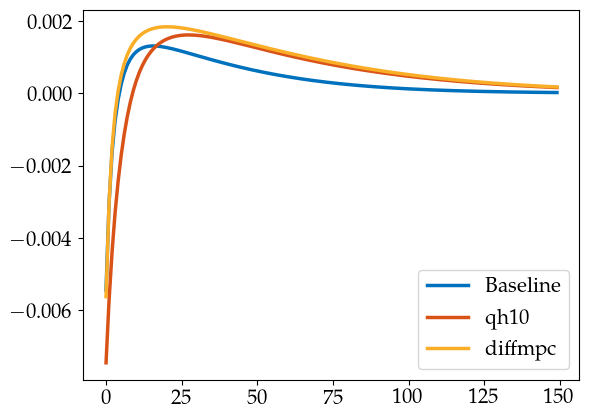

In [203]:
plt.plot(pe_irf['baseline']['C_BHAT'], label='Baseline')
plt.plot(pe_irf['qh10']['C_BHAT'], label='qh10')
plt.plot(pe_irf['diffmpc']['C_BHAT'], label='diffmpc')
plt.legend()

In [42]:
print_calibration(ss['baseline'])
print_calibration(ss['qh10'])
print_calibration(ss['diffmpc'])

beta_hi: 0.967, theta: 0.056,varphi: 0.835, dbeta: 0.039, MPC: 0.120
beta_hi: 0.981, theta: 0.092,varphi: 0.835, dbeta: 0.086, MPC: 0.120
beta_hi: 0.977, theta: 0.082,varphi: 0.835, dbeta: 0.039, MPC: 0.086


In [43]:
real_rigid = 5
calvo_keep = 0.75 #0.926
calvo_change = 1 - calvo_keep

beta = model['baseline']['omega'] * model['baseline']['beta_hi'] +\
      (1 - model['baseline']['omega']) * (model['baseline']['beta_hi'] - model['baseline']['dbeta'])

kappa = 1 / (1 + real_rigid) * (calvo_change * (1 - beta*calvo_keep)/(calvo_keep))

# 2. Figures for steady state

In [44]:
H = 10

In [91]:
exogenous = ['epsm']
drawDAG = False
if drawDAG:
    drawdag(hank, exogenous, unknowns, targets)

In [45]:
use_model = model['baseline']

TT = 200
sigma_qh = use_model['qh']*0.01
rho_qh = 0.0
qh = sigma_qh*rho_qh** np.arange(TT)
qh_lag = np.zeros(TT)

for i in range(1, TT):
    qh_lag[i] = qh[i-1]

qh_only = hh1.impulse_linear(use_model, {'qh': qh}, outputs = ['C_BHAT'],internals=[hh_name])
qhlag_only = hh1.impulse_linear(use_model, {'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])
tot = hh1.impulse_nonlinear(use_model, {'qh': qh, 'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])

percent_c = 100*tot['C_BHAT']/use_model['C_BHAT']
percent_qh = 100*qh/use_model['qh']
elasticity = percent_c/percent_qh[0]

M_labor = hh2.jacobian(use_model, inputs=['w'], outputs=['C_BHAT'], T=T)['C_BHAT','w']
# M_labor_higmpc = hh2.jacobian(model['highmpc'], inputs=['w'], outputs=['C_BHAT'], T=T)['C_BHAT','w']
impcs = M_labor[:, 0]
# impcs_highmpc = M_labor_higmpc[:, 0]

In [46]:
use_model = model['qh10']

TT = 200
sigma_qh = use_model['qh']*0.01
rho_qh = 0.0
qh = sigma_qh*rho_qh** np.arange(TT)
qh_lag = np.zeros(TT)

for i in range(1, TT):
    qh_lag[i] = qh[i-1]

qh_only = hh1.impulse_linear(use_model, {'qh': qh}, outputs = ['C_BHAT'],internals=[hh_name])
qhlag_only = hh1.impulse_linear(use_model, {'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])
tot = hh1.impulse_nonlinear(use_model, {'qh': qh, 'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])

percent_c = 100*tot['C_BHAT']/use_model['C_BHAT']
percent_qh = 100*qh/use_model['qh']
elasticity_hw = percent_c/percent_qh[0]

In [47]:
use_model = model['diffmpc']

TT = 200
sigma_qh = use_model['qh']*0.01
rho_qh = 0.0
qh = sigma_qh*rho_qh** np.arange(TT)
qh_lag = np.zeros(TT)

for i in range(1, TT):
    qh_lag[i] = qh[i-1]

qh_only = hh1.impulse_linear(use_model, {'qh': qh}, outputs = ['C_BHAT'],internals=[hh_name])
qhlag_only = hh1.impulse_linear(use_model, {'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])
tot = hh1.impulse_nonlinear(use_model, {'qh': qh, 'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=[hh_name])

percent_c = 100*tot['C_BHAT']/use_model['C_BHAT']
percent_qh = 100*qh/use_model['qh']
elasticity_diffmpc = percent_c/percent_qh[0]

### Figure 1: iMPC out of income

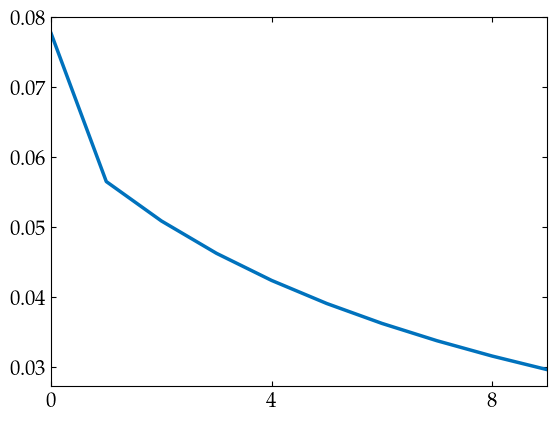

In [48]:
plt.plot(impcs[:H], label='MPC out of income')
# plt.plot(impcs_highmpc[:H], label='MPC out of income high mpc')
plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
# Get the current Axes object
ax = plt.gca()

# Set the major locator for the x-axis
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlim(0, H -1)

plt.show()

### Figure 2: Average MPC out of housing

MPC at 0: 0.001


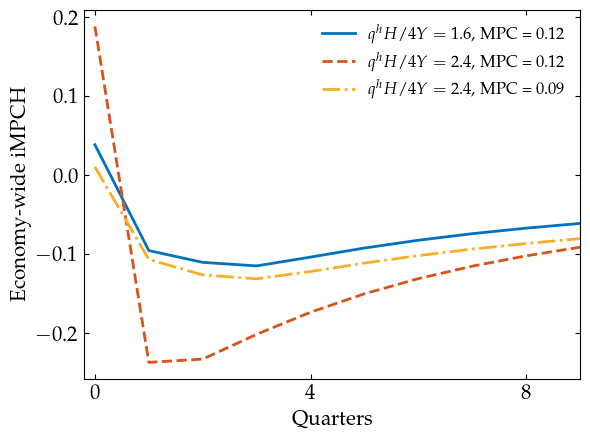

In [49]:
fig, ax = plt.subplots()

lw = 2.0
ax.plot(elasticity[:H], label=fr"$q^hH/4Y = 1.6$, MPC = {ss['baseline']['MPC']:.2f}", linewidth=lw)
ax.plot(elasticity_hw[:H], label=fr"$q^hH/4Y = 2.4$, MPC = {ss['qh10']['MPC']:.2f}", linestyle='dashed', linewidth=lw)
ax.plot(elasticity_diffmpc[:H], label=fr"$q^hH/4Y = 2.4$, MPC = {ss['diffmpc']['MPC']:.2f}", linestyle='dashdot', linewidth=lw)
# plt.title('MPC/Elasticity out of housing wealth')
ax.set_xlabel('Quarters')
ax.set_ylabel('Economy-wide iMPCH')
ax.legend(frameon=False, fontsize=12)
# print(f"Elasticity at 0: {elasticity[0]:.3f}")
print(f"MPC at 0: {tot['C_BHAT'][0]/qh[0]:.3f}")
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)

ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlim(-0.2, H - 1)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'iMPCh_v001.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Figure 4: MPCH over the distribution

In [50]:
b_grid = model['baseline'].internals[hh_name]['b_bhat_grid']
z_grid = model['baseline'].internals[hh_name]['z_grid']
h_grid = model['baseline'].internals[hh_name]['h_bhat_grid']

bdmargdist = np.sum(model['baseline'].internals[hh_name]['D'], axis=0)
b_margdist = np.sum(bdmargdist,axis=1) # sum out housing
h_margdist = np.sum(bdmargdist,axis=0) # sum out bonds
bmargcum = np.cumsum(b_margdist)
hmargcum = np.cumsum(h_margdist)
index_b = np.argmin(np.abs(bmargcum - 0.5))
print(f"Median b: {b_grid[index_b]:.3f} at index {index_b}")
index_h = np.argmin(np.abs(hmargcum - 0.5))
print(f"Median h: {h_grid[index_h]:.3f} at index {index_h}")

Median b: 1.438 at index 18
Median h: 0.693 at index 30


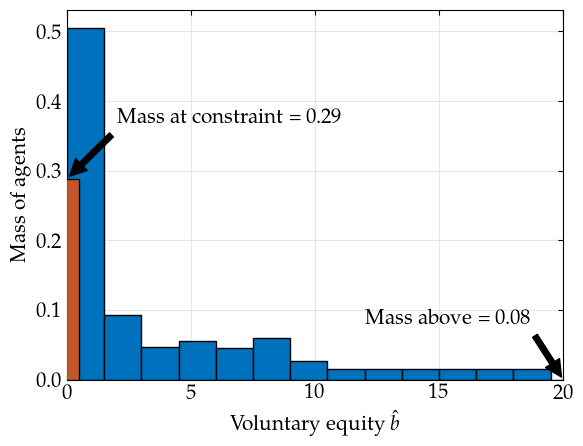

In [98]:
# Create the histogram
fig, ax = plt.subplots()
ax.grid(True, alpha=0.3, zorder = 0)
ax.hist(b_grid, weights=b_margdist, bins=30, edgecolor='k', alpha=1.0, zorder = 2)

# Customize the plot
ax.set_xlabel(r'Voluntary equity $\hat{b}$')
ax.set_ylabel('Mass of agents')
# ax.set_title('Histogram of b_margdist as a function of b_grid')
ax.set_xlim(left=0, right=20)
ax.hist(b_grid[0:1], weights=b_margdist[0:1], bins=1, edgecolor='k', alpha=0.9, zorder = 3)

ax.annotate(f'Mass at constraint = {b_margdist[0]:.2f}',
            xy=(b_grid[0], b_margdist[0]), xycoords='data',
            xytext=(b_grid[0] + 2, b_margdist[0] + 0.1), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top')

# Calculate the mass of agents with b_margdist corresponding to b_grid > 20
mass_greater_than_20 = np.sum(b_margdist[b_grid > 20])

# Add an arrow pointing to the end of the x-axis and show the mass of agents with b_margdist > 20
ax.annotate(f'Mass above = {mass_greater_than_20:.2f}',
            xy=(20, 0), xycoords='data',
            xytext=(12, 0.1), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='left', verticalalignment='top')
plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'bhat_ss_dist.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

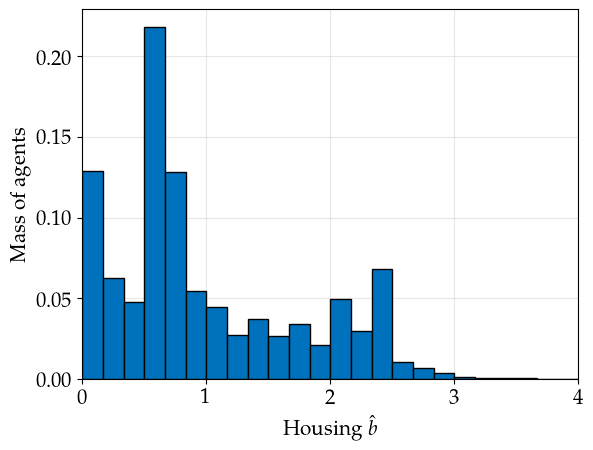

In [95]:
# Create the histogram
fig, ax = plt.subplots()
ax.grid(True, alpha=0.3, zorder = 0)
ax.hist(h_grid, weights=h_margdist, bins=30, edgecolor='k', alpha=1.0, zorder = 2)

# Customize the plot
ax.set_xlabel(r'Housing $\hat{b}$')
ax.set_ylabel('Mass of agents')
# ax.set_title('Histogram of b_margdist as a function of b_grid')
ax.set_xlim(left=0, right=4)
# ax.hist(h_margdist[0:1], weights=h_margdist[0:1], bins=1, edgecolor='k', alpha=0.7)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'h_ss_dist.pdf'), dpi=1000, bbox_inches='tight', transparent=True)


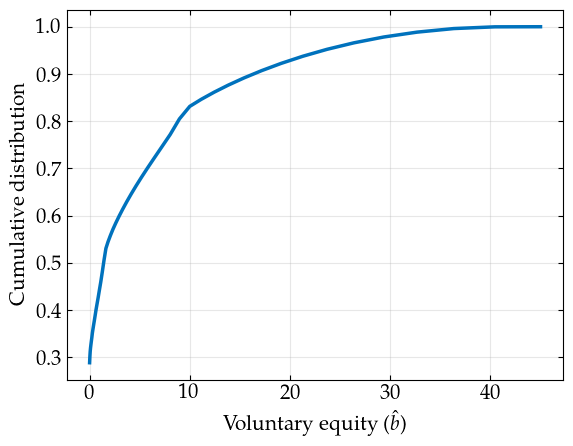

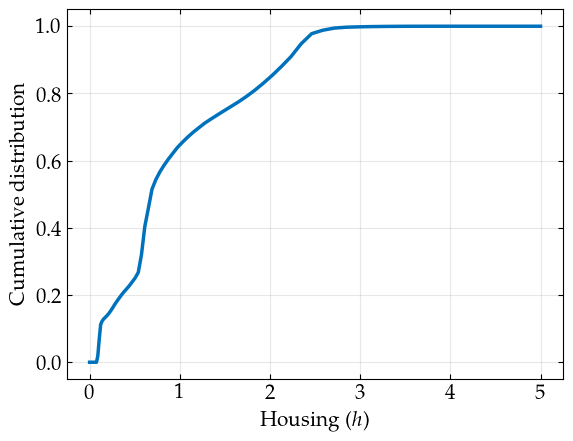

In [79]:
plt.plot(b_grid, bmargcum, label='b')
plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
plt.xlabel(r'Voluntary equity ($\hat{b}$)')
plt.ylabel('Cumulative distribution')
plt.grid(True, alpha=0.3, zorder = 0)
plt.show()

plt.plot(h_grid, hmargcum, label='b')
plt.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
plt.grid(True, alpha=0.3, zorder = 0)
plt.xlabel(r'Housing ($h$)')
plt.ylabel('Cumulative distribution')
plt.show()

### Figure 4: MPCH over the distribution

Mean MPC: 0.018
Mean MPC: 0.120


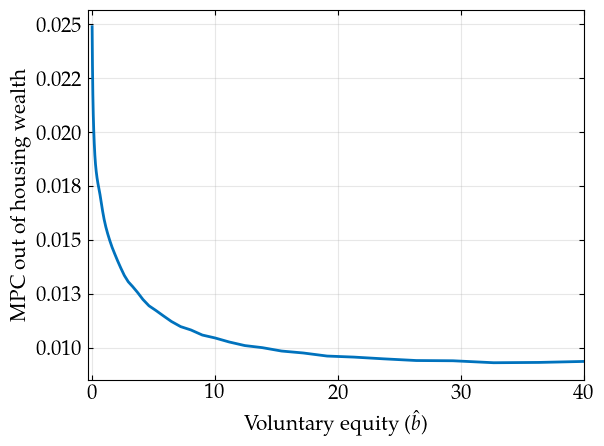

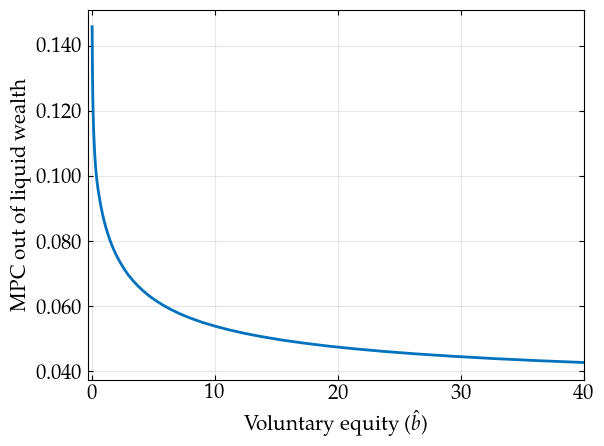

In [81]:
MPCH, mean_MPC = utils.calc_mpch(model['baseline'], hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")

MPC, mean_MPC = utils.calc_mpc(model['baseline'], hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")

z_idx = 1
h_idx = 10
b_idx = 10
# plt.plot(b_grid, MPCH[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
# plt.plot(h_grid, model['baseline'].internals[hh_name]['c_bhat'][z_idx,b_idx,:], label='c')
# plt.plot(b_grid, model['baseline'].internals[hh_name]['c_bhat'][z_idx,:,index_h], label='c')

def format_func(value, tick_number):
    return f'{value:.3f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

MPCH_average = np.mean(MPCH, axis=0) # average over income state and discount factor

fig, ax = plt.subplots()
ax.plot(b_grid, MPCH[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax.set_xlabel(r'Voluntary equity ($\hat{b}$)')
ax.set_ylabel('MPC out of housing wealth')
ax.set_xlim(-0.35, 40)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, alpha=0.3, zorder = 0)
# ax.grid(True, axis='y')
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MPCH_v001.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

fig, ax = plt.subplots()
ax.plot(b_grid[:-1], MPC[z_idx,:-1,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
# plt.legend(frameon=False)
ax.set_xlabel(r'Voluntary equity ($\hat{b}$)')
ax.set_ylabel('MPC out of liquid wealth')
ax.set_xlim(-0.35, 40)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, alpha=0.3, zorder = 0)
# ax.grid(True, axis='y')
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MPC_v001.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

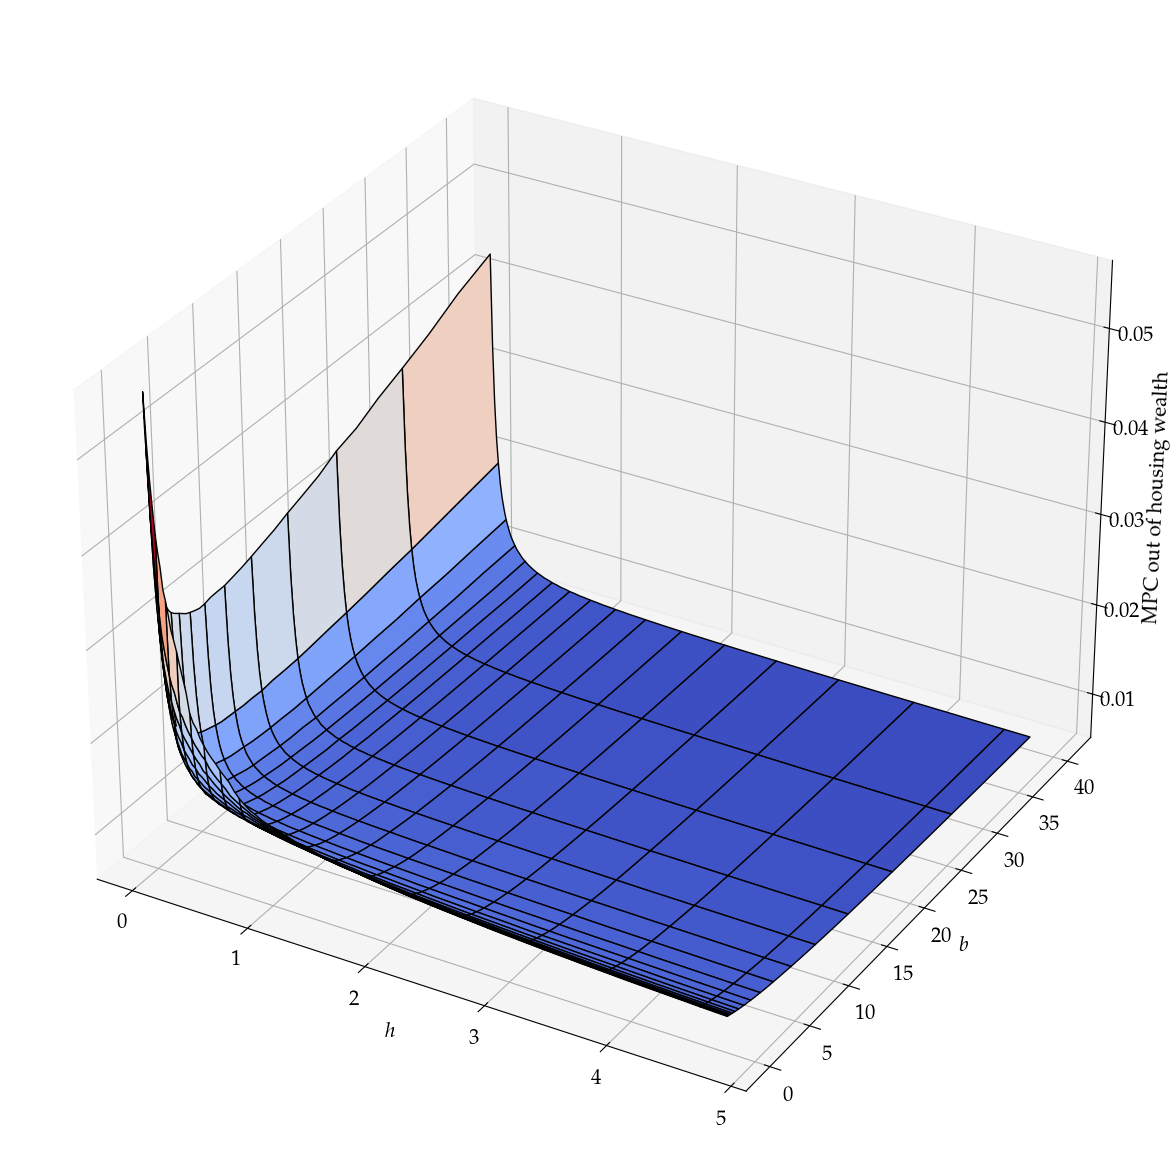

In [55]:
XX, YY = np.meshgrid(ss['baseline'].internals[hh_name]['h_bhat_grid'],ss['baseline'].internals[hh_name]['b_bhat_grid'])

fig = plt.figure(figsize=(12, 16))
ax = fig.add_subplot(111, projection='3d')
surf2 = ax.plot_surface(XX[:-1,3:-1], YY[:-1,3:-1], MPCH_average[:-1,3:-1], cmap='coolwarm', alpha=1.0, label = ' z = 0',
                        edgecolor='k', rcount = 20, ccount = 20)
ax.set_xlabel('$h$')
ax.set_ylabel('$b$')
ax.set_zlabel('MPC out of housing wealth')
fig.tight_layout()
plt.show()

# 3. Figures for transition dynamics

In [83]:
input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p', 'r_opp', 'qh_col']
output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT', 'C_BHAT_UNC', 'C_BHAT_CON']

T = 150
sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

In [84]:
H = 17
interval = 2
devss = ['Y', 'qh', 'C_BHAT', 'w', 'N', 'Div', 'Tax', 'CHI']

# Function to format y-axis labels with the same number of digits
def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

In [85]:
Js_dict = {}    # empty dictionary to store Jacobians
irfs = {}       # empty dictionary to store impulse responses

xi = 0.99 # persistence of expectations
# model['baseline']['rhom'] = 0.85
# model['qh10']['rhom'] = 0.85

irfs['fire'], Js_dict['fire'] = inattention_irf(0, model['baseline'], hh2, hank, hh_name, 
                                    input_list, output_list, unknowns, targets, dr)

irfs['inatt'], Js_dict['inatt'] = inattention_irf(xi, model['baseline'], hh2, hank, hh_name, 
                                                    input_list, output_list, unknowns, targets, dr)

irfs['inatt_hw'], Js_dict['inatt_hw'] = inattention_irf(xi, model['qh10'], hh2, hank, hh_name, 
                                                    input_list, output_list, unknowns, targets, dr)

if compute_differentmpc:
    irfs['diffmpc'], Js_dict['diffmpc'] = inattention_irf(xi, model['diffmpc'], hh2, hank, hh_name, 
                                                    input_list, output_list, unknowns, targets, dr)

<class 'types.SimpleNamespace'>


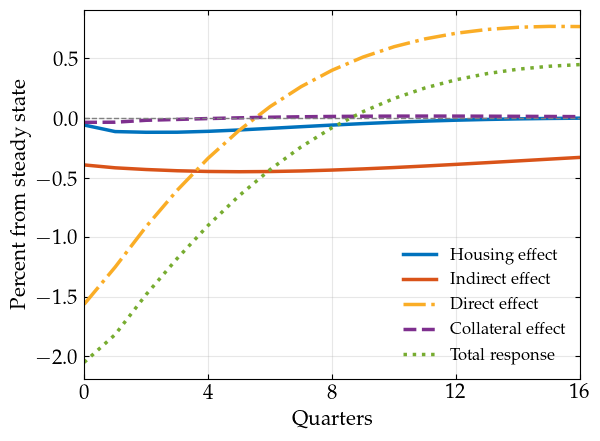

In [86]:
c_test = consumption_decomp(Js_dict['fire'], irfs['inatt'], hh_name, do_assert=False)

fig = plot_decomp_single(c_test, model['baseline'], H = 17)

### Figure 1: Comparing the response with and without inattention

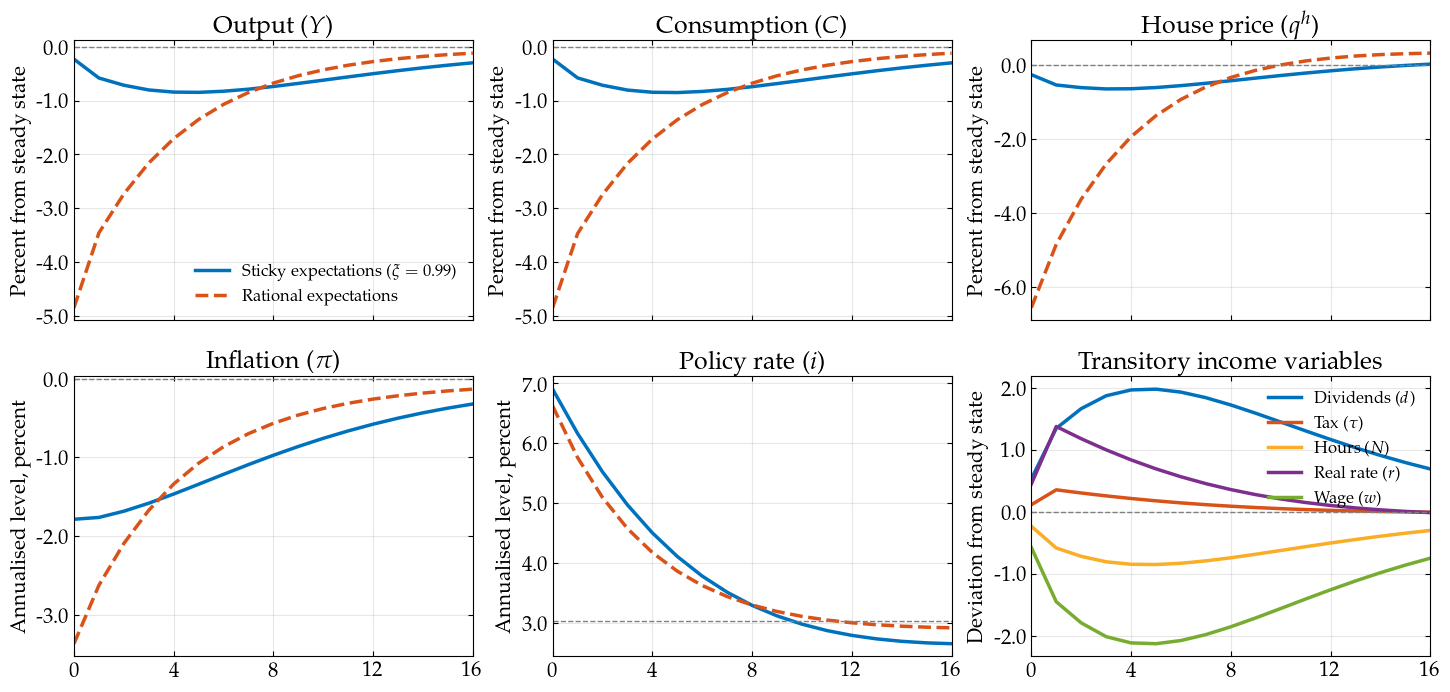

In [63]:
fig, ax = plt.subplots(2, 3, figsize=(17.5,12*2/3), sharex = True)
ax = ax.flatten()

irf1 = irfs['fire']
irf2 = irfs['inatt']
model_ss = model['baseline']

irf3 = irfs['inatt_hw']
model_hw = model['qh10']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'qh': r'House price ($q^h$)', 
            'pi': r'Inflation ($\pi$)', 'i': r'Policy rate ($i$)'}

for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:
        ax[i].plot(100*(irf2[key][:H]/model_ss[key]))   
        ax[i].plot(100*(irf1[key][:H]/model_ss[key]), linestyle='--')
        # ax[i].plot(100*(irf2[key][:H]/model_ss[key]), linestyle='--')
        # ax[i].plot(100*(irf3[key][:H]/model_hw[key]), linewidth=2)
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf2[key][:H])**4-1))
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:H])**4-1), linestyle='--')
        ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 0:
        ax[i].legend([fr'Sticky expectations ($\xi =$ {xi})','Rational expectations'], fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)
    ax[i].grid(True, alpha=0.3)

trans_inc_var = {'Div': r'Dividends ($d$)', 'Tax': r'Tax ($\tau$)', 'N': r'Hours ($N$)', 'r': r'Real rate ($r$)', 'w': r'Wage ($w$)'}

for i, (key, value) in enumerate(trans_inc_var.items()):   
    ax[5].plot(100*(irf2[key][:H]), label=f"{value}")

# ax[5].axhline(y=0, label = 'Wage ($w$)', color = '#77AC30')
ax[5].axhline(y=0, color='grey', linestyle='--', linewidth=1.0)
ax[5].set_ylabel('Deviation from steady state')

ax[5].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[5].yaxis.set_major_formatter(formatter)
ax[5].xaxis.set_major_locator(MultipleLocator(4))
ax[5].set_xlim(0, H -1)
ax[5].set_title('Transitory income variables')
ax[5].legend(fontsize=12, frameon=False, ncols = 1, loc = 'upper right')
ax[5].grid(True, alpha=0.3)

plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MainModelIrf_v5.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

In [111]:
print(100*irfs['fire']['C_BHAT'][0]/model['baseline']['C_BHAT'])
print(100*irfs['fire']['qh'][0]/model['baseline']['qh'])

print(100*irfs['inatt']['C_BHAT'][0:7]/model['baseline']['C_BHAT'])
print(100*irfs['inatt']['qh'][0:7]/model['baseline']['qh'])

-4.851590986812934
-6.561967962814148
[-0.228356   -0.57822429 -0.71494795 -0.80443083 -0.8451377  -0.85058051
 -0.83019976]
[-0.27156304 -0.55005616 -0.6212148  -0.65635304 -0.65152996 -0.61909792
 -0.56768838]


### Figure 2: Comparing with empirical IRFs

In [112]:
# Define the path to the Excel file
subfolder = 'Misc'
filename = 'rrshockirfs_v5.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='gamma', header = None)

col_name = ['i', 'C_BHAT', 'qh', 'Y', 'pi', 'Investment', 'w', 'Mortgage', 'Rent']
df.columns = col_name

bounds_name = ['lb', 'ub']
col_name_bands = []
for i in bounds_name:
    for j in col_name:
        col_name_bands.append(f'{i}_{j}')
df_bands = pd.read_excel(file_path, sheet_name='gammabands', header = None)
df_bands.columns = col_name_bands

filename = 'rrshockirfs_v5_68bands.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)
df_bands68 = pd.read_excel(file_path, sheet_name='gammabands', header = None)
df_bands68.columns = col_name_bands

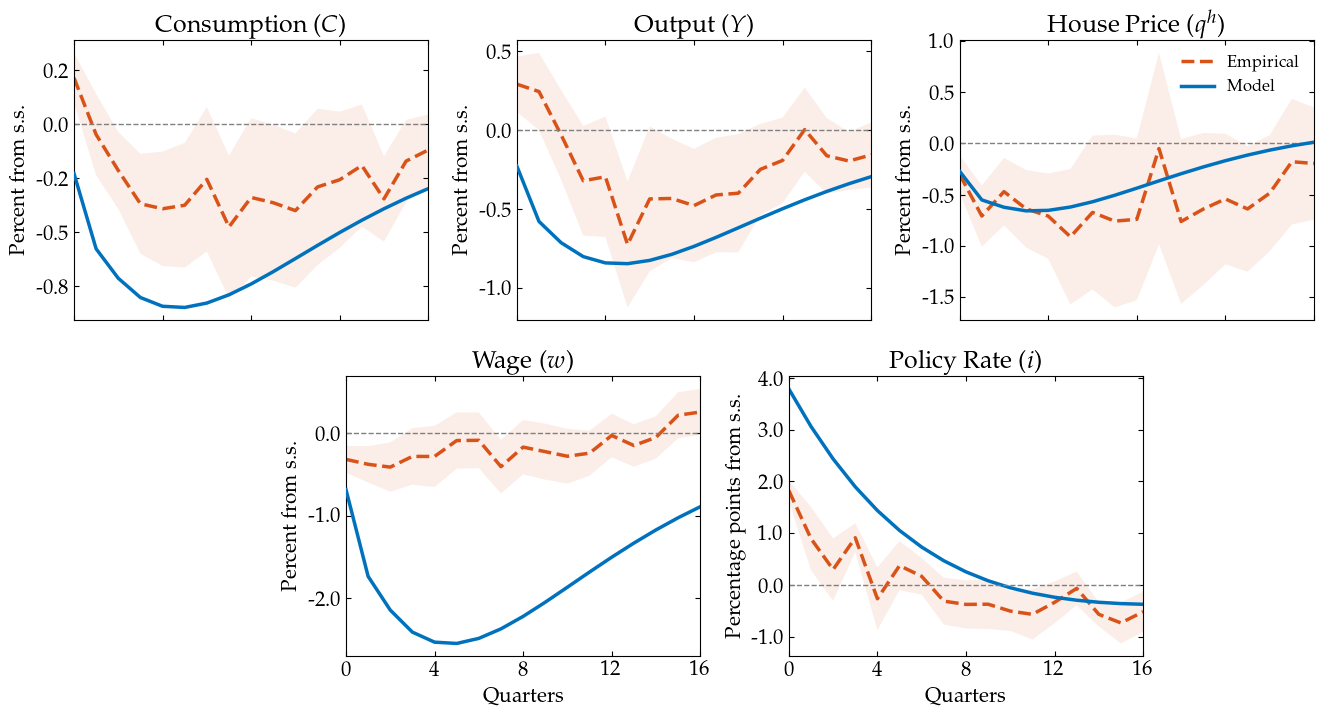

In [116]:
irf2 = irfs['inatt']
model_ss = model['baseline']

fig, ax = plt.subplots(2, 3, figsize=(16*3/3,8), sharex=True)
ax = ax.flatten()

var_name = {'C_BHAT': r'Consumption ($C$)', 'Y': 'Output ($Y$)', 'qh': 'House Price ($q^h$)', 
            'w': r'Wage ($w$)', 'i': r'Policy Rate ($i$)'}

# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0072BD', '#D95319', '#FAAD26', '#7E2F8E', '#77AC30', '#4DBEEE',
#                                                      '#A2142F', '#000000'])  

for i, (key, value) in enumerate(var_name.items()):   

    ax[i].plot(100*df[key][:H], ls = '--', color = '#D95319', label = 'Empirical')
    ax[i].fill_between(range(H), 100*df_bands[f"lb_{key}"][:H], 100*df_bands[f"ub_{key}"][:H], 
                       alpha = 0.1, color = '#D95319', edgecolor = None)
    
    if key in devss:   
        ax[i].plot(100*(irf2[key][:H]/model_ss[key]), color = '#0072BD', label = 'Model', zorder = 10)
    else:
        ax[i].plot(100*((1 + irf2[key][:H])**4-1), color = '#0072BD', label = 'Model')
    
    ax[i].set_title(var_name[key])
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].set_xlim(0, 16)
    ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))

    if key != 'i':
        ax[i].set_ylabel('Percent from s.s.')
    else:
        ax[i].set_ylabel('Percentage points from s.s.')

    if i == 3 or i == 4:
        ax[i].set_xlabel('Quarters')

    if i == 2:
        ax[i].legend(fontsize=12, frameon=False)

ax[5].axis('off')
fig.subplots_adjust(hspace=0.2, wspace=0.25)
for i in range(3, 5):
    pos = ax[i].get_position()
    ax[i].set_position([pos.x0 + 0.17, pos.y0, pos.width, pos.height])

plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'ModelEmpiricalComparision_v5.pdf'), dpi=1000, bbox_inches='tight')

### Alternative version of the plot

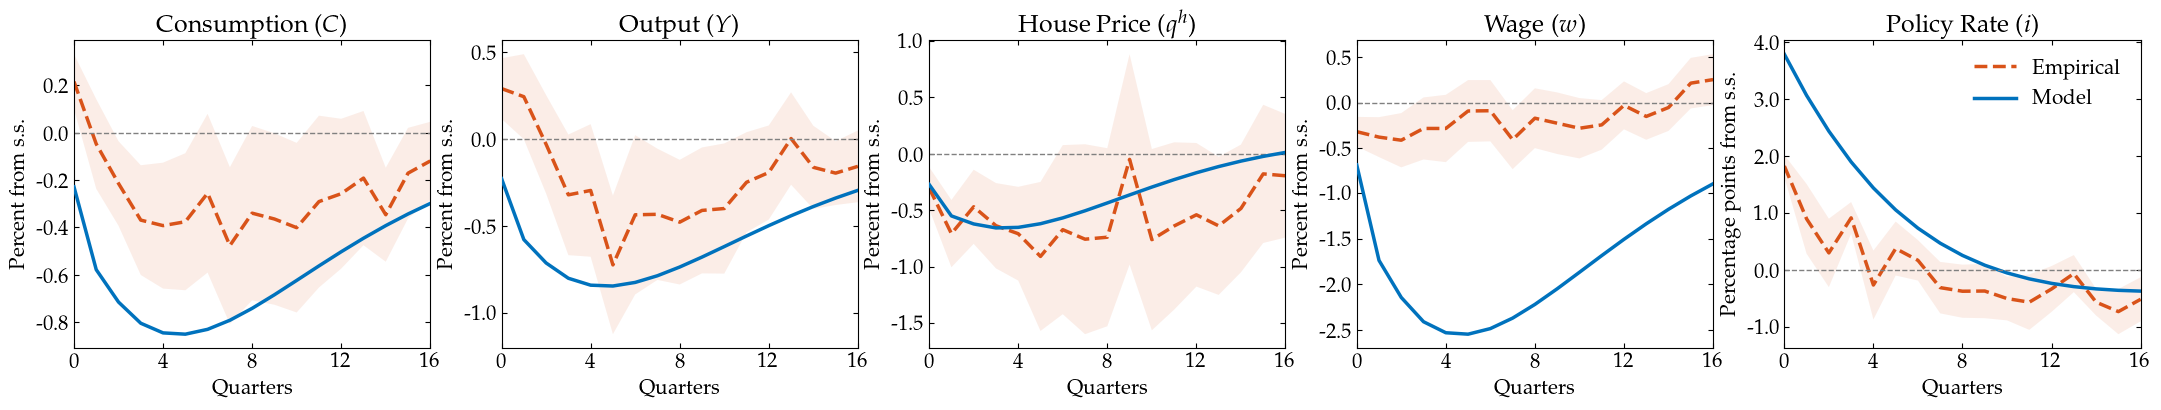

In [126]:
irf2 = irfs['inatt']
model_ss = model['baseline']

fig, ax = plt.subplots(1, 5, figsize=(16*5/3,4), sharex=True)
ax = ax.flatten()

var_name = {'C_BHAT': r'Consumption ($C$)', 'Y': 'Output ($Y$)', 'qh': 'House Price ($q^h$)', 
            'w': r'Wage ($w$)', 'i': r'Policy Rate ($i$)'}

# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0072BD', '#D95319', '#FAAD26', '#7E2F8E', '#77AC30', '#4DBEEE',
#                                                      '#A2142F', '#000000'])  

for i, (key, value) in enumerate(var_name.items()):   

    ax[i].plot(100*df[key][:H], ls = '--', color = '#D95319', label = 'Empirical')
    ax[i].fill_between(range(H), 100*df_bands[f"lb_{key}"][:H], 100*df_bands[f"ub_{key}"][:H], 
                       alpha = 0.1, color = '#D95319', edgecolor = None)
    
    if key in devss:   
        ax[i].plot(100*(irf2[key][:H]/model_ss[key]), color = '#0072BD', label = 'Model', zorder = 10)
    else:
        ax[i].plot(100*((1 + irf2[key][:H])**4-1), color = '#0072BD', label = 'Model')
    
    ax[i].set_title(var_name[key])
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].set_xlim(0, 16)
    ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlabel('Quarters')
    if key != 'i':
        ax[i].set_ylabel('Percent from s.s.')
    else:
        ax[i].set_ylabel('Percentage points from s.s.')

    # if i == 3 or i == 4:
    #     ax[i].set_xlabel('Quarters')

    if i == 4:
        ax[i].legend(fontsize=15, frameon=False)

# ax[5].axis('off')
# fig.subplots_adjust(hspace=0.2, wspace=0.25)
# for i in range(3, 5):
#     pos = ax[i].get_position()
#     ax[i].set_position([pos.x0 + 0.17, pos.y0, pos.width, pos.height])

plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'ModelEmpiricalComparision_v6.pdf'), dpi=1000, bbox_inches='tight')

### Figure 3: Decomposing the consumption response

<class 'types.SimpleNamespace'>
<class 'types.SimpleNamespace'>
<class 'types.SimpleNamespace'>
dict_keys(['fire', 'inatt', 'inatt_hw'])
dict_keys(['diffmpc', 'fire', 'inatt', 'inatt_hw'])


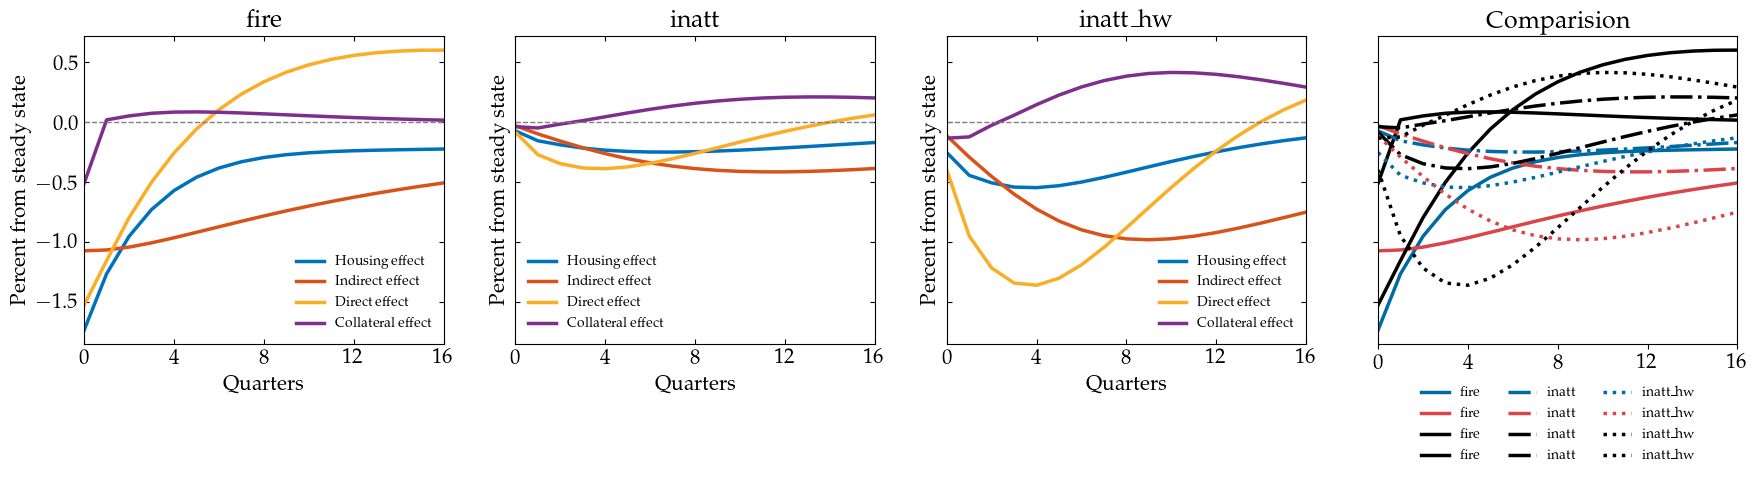

In [84]:
c_decomp = {}
c_decomp['fire'] = consumption_decomp(Js_dict['fire'], irfs['fire'], hh_name)
c_decomp['inatt'] = consumption_decomp(Js_dict['inatt'], irfs['inatt'], hh_name)
c_decomp['inatt_hw'] = consumption_decomp(Js_dict['inatt_hw'], irfs['inatt_hw'], hh_name)
# c_decomp['diffmpc'] = consumption_decomp(Js_dict['diffmpc'], irfs['diffmpc'], hh_name)
print(c_decomp.keys())

model_decomp = model.copy() # copy the model dictionary to match the keys
model_decomp['fire'] = model_decomp['baseline']
model_decomp['inatt'] = model_decomp.pop('baseline')
model_decomp['inatt_hw'] = model_decomp.pop('qh10')
# model_decomp['diffmpc'] = model_decomp.pop('diffmpc')
print(model_decomp.keys())
plot_decomp(1, 4, c_decomp, model_decomp, H = 17, plot_together=True)

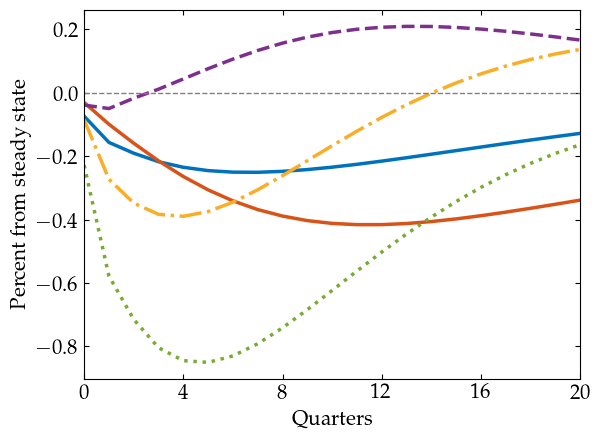

In [85]:
fig = plot_decomp_single(c_decomp['inatt'], model_decomp['inatt'], H = 21, legend = False)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'ConsumptionDecomp_v4.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

<class 'types.SimpleNamespace'>


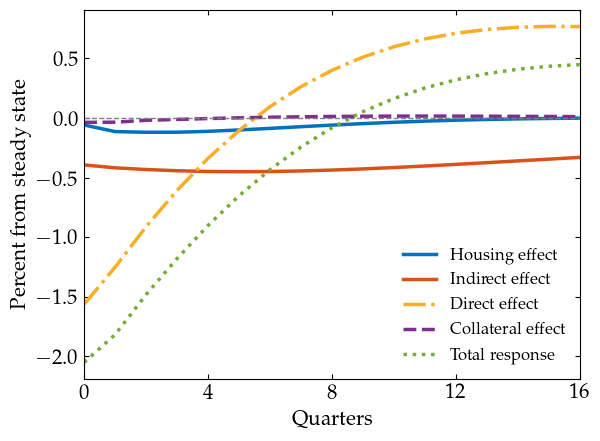

In [86]:
c_test = consumption_decomp(Js_dict['fire'], irfs['inatt'], hh_name, do_assert=False)

fig = plot_decomp_single(c_test, model['baseline'], H = 17)

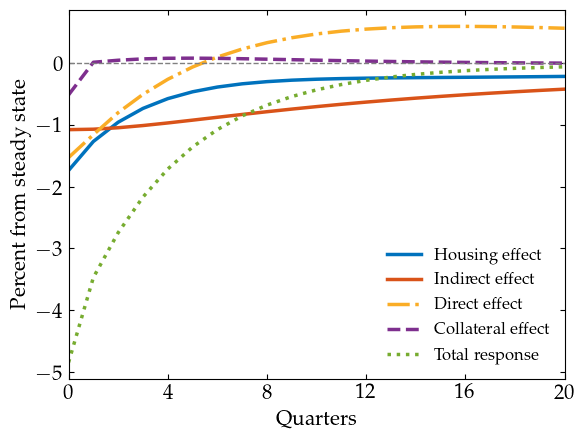

In [87]:
fig = plot_decomp_single(c_decomp['fire'], model_decomp['fire'], H = 21, legend = True)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'ConsumptionDecompFire_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Numbers for table

In [88]:
print(f"Total cumulative effect: {np.round(100*np.cumsum(c_decomp['inatt']['total']/model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]],2)}")
print(f"qh cumulative effect: {np.round(100*np.cumsum(c_decomp['inatt']['housing']/model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]],2)}")
print(f"indirect cumulative effect: {np.round(100*np.cumsum(c_decomp['inatt']['indirect']/model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]],2)}")
print(f"Direct cumulative effect: {np.round(100*np.cumsum(c_decomp['inatt']['direct']/model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]],2)}")
print(f"Collateral cumulative effect: {np.round(100*np.cumsum(c_decomp['inatt']['collateral']/model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]],2)}")

Total cumulative effect: [-0.23 -2.33 -5.64 -8.26 -9.94]
qh cumulative effect: [-0.07 -0.64 -1.62 -2.57 -3.37]
indirect cumulative effect: [-0.03 -0.5  -1.78 -3.4  -5.04]
Direct cumulative effect: [-0.09 -1.09 -2.5  -3.27 -3.35]
Collateral cumulative effect: [-0.04 -0.09  0.27  0.99  1.82]


In [89]:
# Calculate cumulative effects
total_cumulative = np.round(100 * np.cumsum(c_decomp['inatt']['total'] / model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]], 2)
qh_cumulative = np.round(100 * np.cumsum(c_decomp['inatt']['housing'] / model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]], 2)
indirect_cumulative = np.round(100 * np.cumsum(c_decomp['inatt']['indirect'] / model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]], 2)
direct_cumulative = np.round(100 * np.cumsum(c_decomp['inatt']['direct'] / model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]], 2)
collateral_cumulative = np.round(100 * np.cumsum(c_decomp['inatt']['collateral'] / model['baseline']['C_BHAT'])[[0, 3, 7, 11, 15]], 2)

# Create a table
table_data = [
    ["Total"] + total_cumulative.tolist(),
    ["Housing"] + qh_cumulative.tolist(),
    ["Collateral"] + collateral_cumulative.tolist(),
    ["Indirect"] + indirect_cumulative.tolist(),
    ["Direct"] + direct_cumulative.tolist()
]

# Generate LaTeX table
latex_table = tabulate(table_data, headers=["Effect", "0", "3", "7", "11", "15"], tablefmt="latex")

# Print the LaTeX table
print(latex_table)

\begin{tabular}{lrrrrr}
\hline
 Effect     &     0 &     3 &     7 &    11 &    15 \\
\hline
 Total      & -0.23 & -2.33 & -5.64 & -8.26 & -9.94 \\
 Housing    & -0.07 & -0.64 & -1.62 & -2.57 & -3.37 \\
 Collateral & -0.04 & -0.09 &  0.27 &  0.99 &  1.82 \\
 Indirect   & -0.03 & -0.5  & -1.78 & -3.4  & -5.04 \\
 Direct     & -0.09 & -1.09 & -2.5  & -3.27 & -3.35 \\
\hline
\end{tabular}


In [90]:
housing_cum_share = np.round(np.cumsum(c_decomp['inatt']['housing']) / np.cumsum(c_decomp['inatt']['total']), 2)
indirect_cum_share = np.round(np.cumsum(c_decomp['inatt']['indirect']) / np.cumsum(c_decomp['inatt']['total']),2)
direct_cum_share = np.round(np.cumsum(c_decomp['inatt']['direct']) / np.cumsum(c_decomp['inatt']['total']),2)
collateral_cum_share = np.round(np.cumsum(c_decomp['inatt']['collateral']) / np.cumsum(c_decomp['inatt']['total']),2)

housing_cum_share = 100*housing_cum_share[[0, 3, 7, 11, 15]]
indirect_cum_share = 100*indirect_cum_share[[0, 3, 7, 11, 15]]
direct_cum_share = 100*direct_cum_share[[0, 3, 7, 11, 15]]
collateral_cum_share = 100*collateral_cum_share[[0,3, 7, 11, 15]]

# Create a table
table_data = [
    ["Housing"] + housing_cum_share.tolist(),
    ["Collateral"] + collateral_cum_share.tolist(),
    ["Indirect"] + indirect_cum_share.tolist(),
    ["Direct"] + direct_cum_share.tolist()
]

# Generate LaTeX table
latex_table = tabulate(table_data, headers=["Effect", "0", "3", "7", "11", "15"], tablefmt="latex")

# Print the LaTeX table
print(latex_table)

# print(f"qh share of cumulative effect (%): {np.round(100*housing_cum_share[[0, 3, 7, 11, 15]],0)}")
# print(f"indirect share of cumulative effect (%): {np.round(100*indirect_cum_share[[0, 3, 7, 11, 15]],0)}")
# print(f"Direct share of cumulative effect (%): {np.round(100*direct_cum_share[[0, 3, 7, 11, 15]],0)}")
# print(f"Collateral share of cumulative effect (%): {np.round(100*collateral_cum_share[[0, 3, 7, 11, 15]],0)}")

\begin{tabular}{lrrrrr}
\hline
 Effect     &   0 &   3 &   7 &   11 &   15 \\
\hline
 Housing    &  32 &  27 &  29 &   31 &   34 \\
 Collateral &  17 &   4 &  -5 &  -12 &  -18 \\
 Indirect   &  13 &  22 &  32 &   41 &   51 \\
 Direct     &  37 &  47 &  44 &   40 &   34 \\
\hline
\end{tabular}


# 4. -- Figures for state dependence -- 

### Figure 1: Effects across different wealth levels

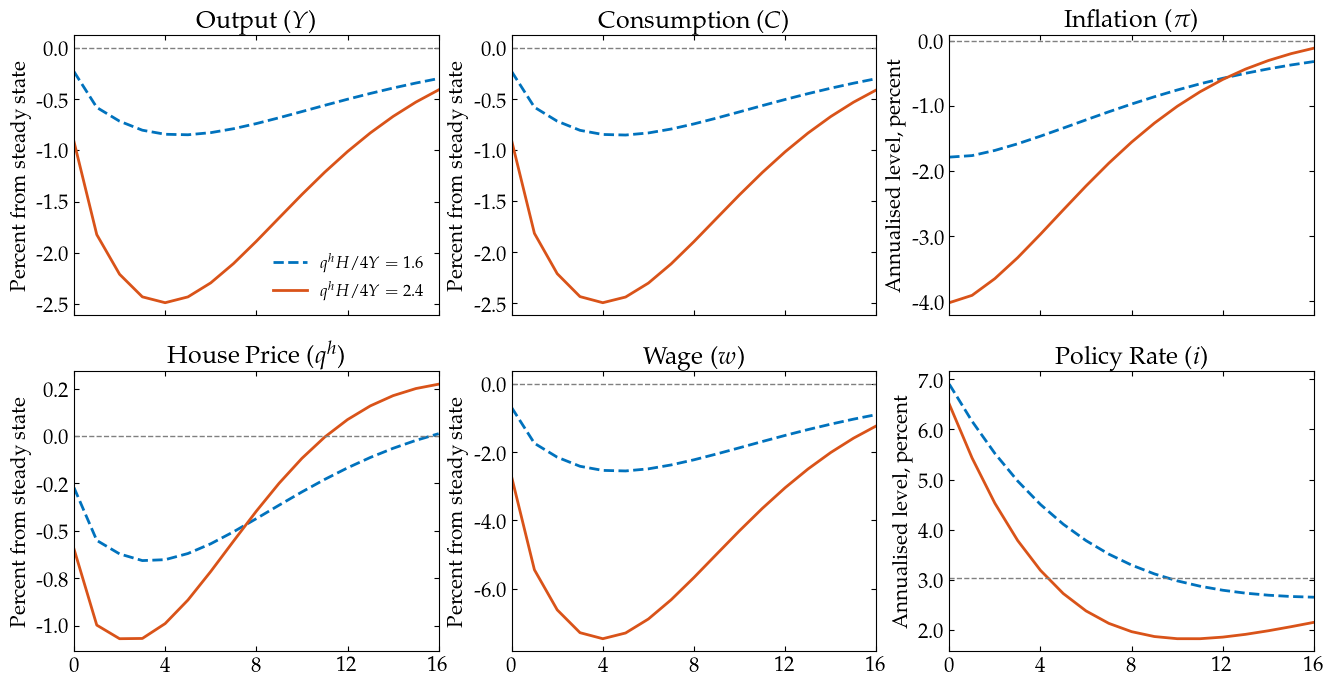

In [91]:
fig, ax = plt.subplots(2, 3, figsize=(16,12*2/3), sharex = True)
ax = ax.flatten()

irf1 = irfs['inatt']
irf2 = irfs['inatt_hw']
model_ss = model['baseline']
model_highwealth = model['qh10']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'pi': r'Inflation ($\pi$)', 
            'qh': r'House Price ($q^h$)','w': r'Wage ($w$)', 'i': r'Policy Rate ($i$)'}

for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:H]/model_ss[key]), linewidth=2, linestyle='--')
        ax[i].plot(100*(irf2[key][:H]/model_highwealth[key]), linewidth=2)
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:H])**4-1), linewidth=2, linestyle='--')
        ax[i].plot(100*((1 + model_highwealth[key] +irf2[key][:H])**4-1), linewidth=2)
        ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 0:
        ax[i].legend([r'$q^hH/4Y = 1.6$',r'$q^hH/4Y = 2.4$'], fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)
    
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'StateDependence_v3.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Figure 2: Decomposing the effect

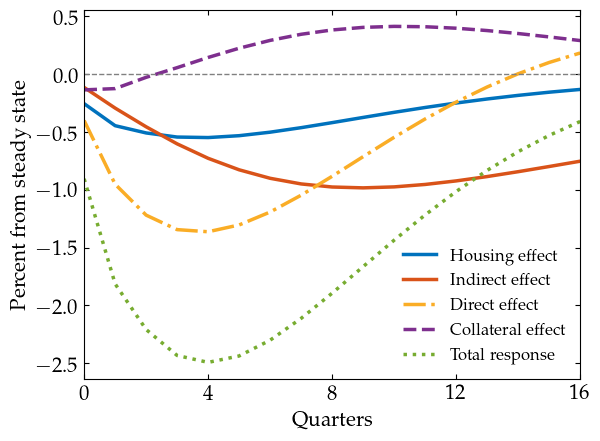

In [92]:
fig = plot_decomp_single(c_decomp['inatt_hw'], model_decomp['inatt_hw'], H = 17)

### Figure 2b: Decomposing the effect

<class 'types.SimpleNamespace'>
<class 'types.SimpleNamespace'>
<class 'types.SimpleNamespace'>


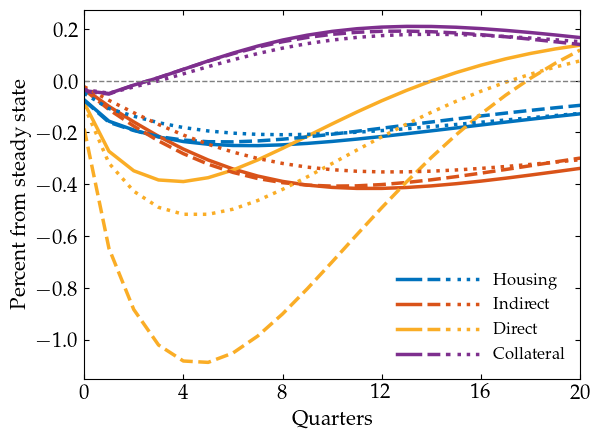

In [93]:
from matplotlib.legend_handler import HandlerTuple
fig, ax = plt.subplots()
colors=['#0072BD', '#D95319', '#FAAD26', '#7E2F8E', '#77AC30', '#4DBEEE','#A2142F', '#000000']
counterfactual_decom_baseline =  consumption_decomp(Js_dict['inatt'], irfs['inatt'], hh_name, do_assert=False)
counterfactual_decom_qh10 =  consumption_decomp(Js_dict['inatt_hw'], irfs['inatt'], hh_name, do_assert=False)
counterfactual_decom_diffmpc =  consumption_decomp(Js_dict['diffmpc'], irfs['inatt'], hh_name, do_assert=False)

H = 21
p1 = ax.plot(100*counterfactual_decom_baseline['housing'][:H]/model['qh10']['C_BHAT'], label='Housing effect')
p2 = ax.plot(100*counterfactual_decom_baseline['indirect'][:H]/model['qh10']['C_BHAT'], label='Indirect effect')
p3 = ax.plot(100*counterfactual_decom_baseline['direct'][:H]/model['qh10']['C_BHAT'], label='Direct effect')
p4 = ax.plot(100*counterfactual_decom_baseline['collateral'][:H]/model['qh10']['C_BHAT'], label='Collateral effect')

p5 = ax.plot(100*counterfactual_decom_qh10['housing'][:H]/model['qh10']['C_BHAT'], color = colors[0], linestyle='dashed')
p6 = ax.plot(100*counterfactual_decom_qh10['indirect'][:H]/model['qh10']['C_BHAT'], color = colors[1], linestyle='dashed')
p7 = ax.plot(100*counterfactual_decom_qh10['direct'][:H]/model['qh10']['C_BHAT'], color = colors[2], linestyle='dashed')
p8 = ax.plot(100*counterfactual_decom_qh10['collateral'][:H]/model['qh10']['C_BHAT'], color = colors[3], linestyle='dashed')
# p10 = ax.plot(100*counterfactual_decom_qh10['total'][:H]/model['qh10']['C_BHAT'], label='Total response')

p9 = ax.plot(100*counterfactual_decom_diffmpc['housing'][:H]/model['diffmpc']['C_BHAT'], color = colors[0], linestyle='dotted')
p10 = ax.plot(100*counterfactual_decom_diffmpc['indirect'][:H]/model['diffmpc']['C_BHAT'], color = colors[1], linestyle='dotted')
p11 = ax.plot(100*counterfactual_decom_diffmpc['direct'][:H]/model['diffmpc']['C_BHAT'], color = colors[2], linestyle='dotted')
p12 = ax.plot(100*counterfactual_decom_diffmpc['collateral'][:H]/model['diffmpc']['C_BHAT'], color = colors[3], linestyle='dotted')
# ax.plot(100*counterfactual_decom_diffmpc['total'][:H]/model['diffmpc']['C_BHAT'], label='Total response')
plt.legend([(p1[0], p5[0], p9[0]), (p2[0], p6[0], p10[0]), (p3[0], p7[0], p11[0]), (p4[0], p8[0], p12[0])], 
           ['Housing', 'Indirect', 'Direct', 'Collateral'], numpoints=1, 
           handler_map={tuple: HandlerTuple(ndivide=None)}, handlelength=5, frameon=False, fontsize = 12)
ax.set_xlabel('Quarters')
ax.set_ylabel('Percent from steady state')
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlim(0, H-1)
ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'CounterfactualCDecomp_v2.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Figure 3. Housing wealth elasticity for different levels of wealth

Mean MPC: 0.018
Mean MPC: 0.013


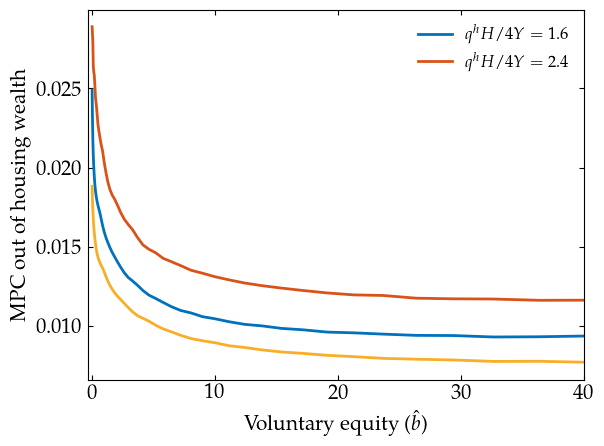

In [94]:
MPCH_hw, mean_MPC = utils.calc_mpch(model['qh10'], hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")
MPCH_diffmpc, mean_MPC = utils.calc_mpch(model['diffmpc'], hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")

z_idx = 1
h_idx = 10
b_idx = 10

def format_func(value, tick_number):
    return f'{value:.3f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

fig, ax = plt.subplots()
ax.plot(b_grid, MPCH[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.plot(b_grid, MPCH_hw[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.plot(b_grid, MPCH_diffmpc[z_idx,:,index_h], label=f'z = {z_grid[z_idx]:.2f}, h = {h_grid[index_h]:.2f}', linewidth=2)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax.set_xlabel(r'Voluntary equity ($\hat{b}$)')
ax.set_ylabel('MPC out of housing wealth')
ax.legend([r'$q^hH/4Y = 1.6$',r'$q^hH/4Y = 2.4$'], fontsize=12, frameon=False)
ax.set_xlim(-0.35, 40)
ax.yaxis.set_major_formatter(formatter)
# ax.grid(True, axis='y')
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MPCH_differentWealth.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Figure 4. Allowing the average MPC to vary

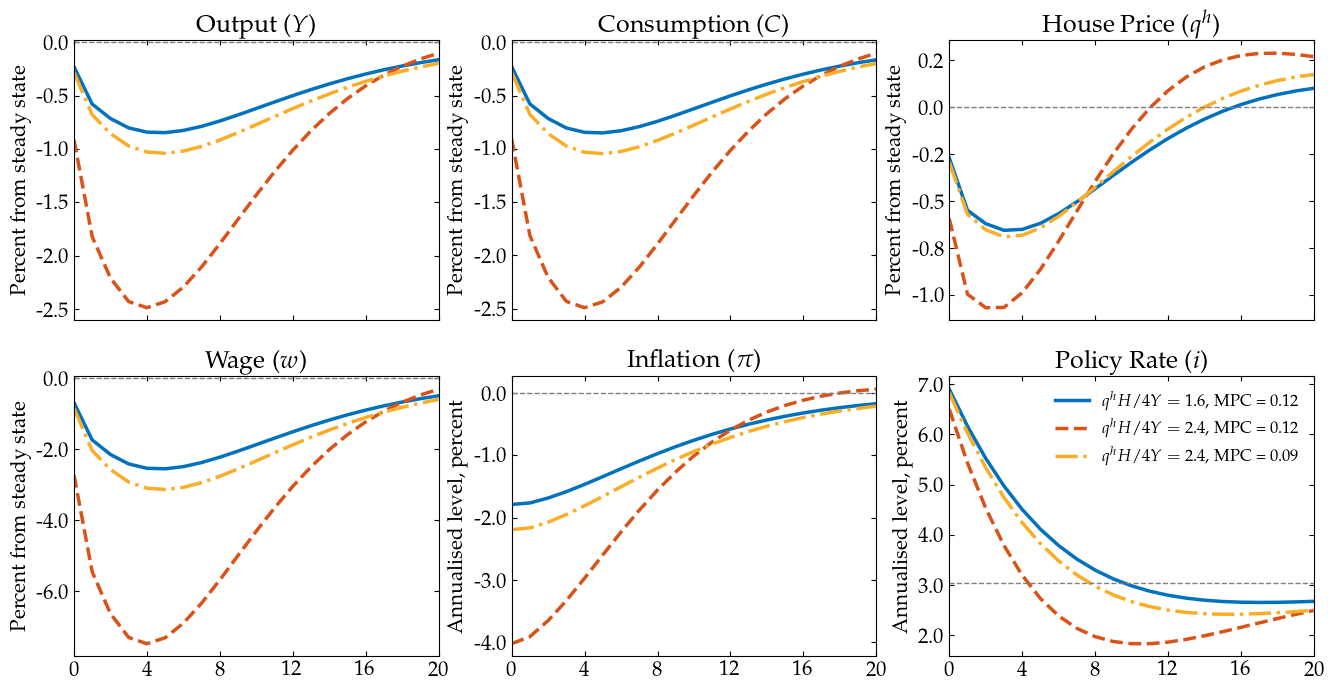

In [95]:
plt.rcParams['lines.linewidth'] = 2.5
fig, ax = plt.subplots(2, 3, figsize=(16,12*2/3), sharex = True)
ax = ax.flatten()

irf1 = irfs['inatt']
irf2 = irfs['inatt_hw']
irf3 = irfs['diffmpc']
model_ss = model['baseline']
model_highwealth = model['qh10']
model_diffmpc = model['diffmpc']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'qh': r'House Price ($q^h$)',
            'w': r'Wage ($w$)', 'pi': r'Inflation ($\pi$)', 'i': r'Policy Rate ($i$)'}

def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:H]/model_ss[key]), 
                   label=fr"$q^hH/4Y = 1.6$, MPC = {ss['baseline']['MPC']:.2f}")
        ax[i].plot(100*(irf2[key][:H]/model_highwealth[key]), 
                   label=fr"$q^hH/4Y = 2.4$, MPC = {ss['qh10']['MPC']:.2f}", linestyle='--')
        ax[i].plot(100*(irf3[key][:H]/model_diffmpc[key]), ls = 'dashdot',
                   label=fr"$q^hH/4Y = 2.4$, MPC = {ss['diffmpc']['MPC']:.2f}")
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:H])**4-1),
                   label=fr"$q^hH/4Y = 1.6$, MPC = {ss['baseline']['MPC']:.2f}")
        ax[i].plot(100*((1 + model_highwealth[key] +irf2[key][:H])**4-1),
                   label=fr"$q^hH/4Y = 2.4$, MPC = {ss['qh10']['MPC']:.2f}", linestyle='--')
        ax[i].plot(100*((1 + model_diffmpc[key] +irf3[key][:H])**4-1), ls = 'dashdot',
                   label=fr"$q^hH/4Y = 2.4$, MPC = {ss['diffmpc']['MPC']:.2f}")

        ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 5:
        # ax[i].legend([r'$q^hH/4Y = 1.6$',r'$q^hH/4Y = 2.4$'], fontsize=12, frameon=False)
        ax[i].legend(fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)
    
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    # fig.savefig(os.path.join(figure_path, 'ConsumptionDecomp_v3.pdf'), dpi=1000, bbox_inches='tight')
    fig.savefig(os.path.join(figure_path, 'ThreeVersionsWealth_v2.pdf'), dpi=1000, bbox_inches='tight')

# 5. Sticky wages HANK

In [173]:
hh = hh_housing_v3.hh_housecons_sep
hh_name = hh.name

# add hetinputs to the model
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])
hh2 = hh1.add_hetoutputs([utils.compute_mpc])

common_block = [hh2, utils.taylor, utils.real_rate, utils.fiscal, utils.qhouse_lag, utils.gamma_prime]
blocks_sw = [utils.real_wage, utils.mkt_clearing_wage, utils.nkpc_wage, utils.firm_wage]

blocks_sw = common_block + blocks_sw 

unknowns_sw = ['pi', 'N', 'qh']
targets_sw = ['nkpc_res', 'asset_mkt', 'house_mkt']

hank_ss_sw = create_model(blocks_sw, name="Housing HANK SS")
hank_sw = create_model(blocks_sw, name="Sticky Wages HANK")

ss_sw = {}
model_sw = {}
irf_sw = {}

In [174]:
cali_main_sw = {'gamma': 0.8, 'qh': 1.61*4, 'sigma': 2.0, 'alpha': 0.05, 'bmax': 45, 'rhom': 0.89, 'omega': 0.5, 'q': 0.01,
                'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0,
                'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'muw': 1.2, 'bmin': 0.0,
                'kappaw': 0.0160685, 'rstar': 0.03/4, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}

unknowns_ss = {'beta_hi': 0.977, 'varphi': 0.836, 'theta': 0.077, 'dbeta': 0.082}

targets_ss = {'goods_mkt': 0, 'nkpc_res': 0, 'house_mkt': 0, 'MPC': 0.12}

ss_sw['baseline']  = hank_ss_sw.solve_steady_state(cali_main_sw, unknowns_ss, targets_ss, solver="hybr")
model_sw['baseline'] = hank_sw.steady_state(ss_sw['baseline'])

ss_sw['recali_kappaw'] = ss_sw['baseline'].copy()
ss_sw['recali_kappaw']['kappaw'] = 0.01

# ss_sw['baseline']  = hank_ss_sw.solve_steady_state(cali_main_sw, unknowns_ss, targets_ss, solver="hybr")
model_sw['recali_kappaw'] = hank_sw.steady_state(ss_sw['recali_kappaw'])

In [182]:
T = 150

irf_sw['baseline'], _ = inattention_irf(xi, model_sw['baseline'], hh2, hank_sw, hh_name, input_list, output_list, unknowns_sw, targets_sw, dr)
irf_sw['recali_kappaw'], _ = inattention_irf(xi, ss_sw['recali_kappaw'], hh2, hank_sw, hh_name, input_list, output_list, unknowns_sw, targets_sw, dr)

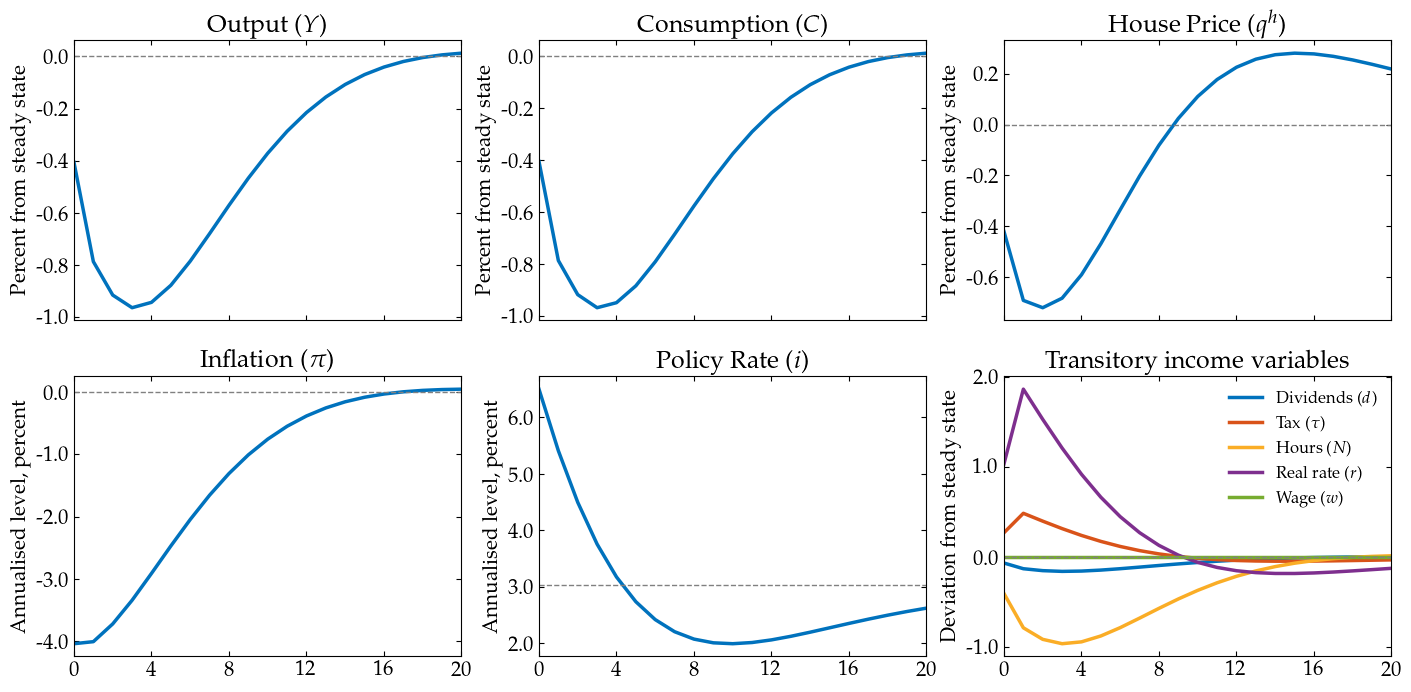

In [218]:
plt.rcParams['lines.linewidth'] = 2.5
fig, ax = plt.subplots(2, 3, figsize=(17,12*2/3), sharex = True)
ax = ax.flatten()

irf1 = irf_sw['baseline']
irf2 = irf_sw['recali_kappaw']
model_ss = model_sw['baseline']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'qh': r'House Price ($q^h$)',
            'pi': r'Inflation ($\pi$)', 'i': r'Policy Rate ($i$)'}

def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

H = 21
for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:H]/model_ss[key]))
        # ax[i].plot(100*(irf2[key][:H]/model_ss[key]))
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:H])**4-1))
        # ax[i].plot(100*((1 + model_ss[key] +irf2[key][:H])**4-1))

        ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    # if i == 0:
    #     ax[i].legend([r'$\kappa_w = 0.016$',r'$\kappa_w = 0.01$'], fontsize=14, frameon=False)
        # ax[i].legend(fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)

trans_inc_var = {'Div': r'Dividends ($d$)', 'Tax': r'Tax ($\tau$)', 'N': r'Hours ($N$)', 'r': r'Real rate ($r$)'}

for i, (key, value) in enumerate(trans_inc_var.items()):   
    ax[5].plot(100*(irf1[key][:H]), label=f"{value}")

ax[5].axhline(y=0, label = 'Wage ($w$)', color = '#77AC30')
ax[5].axhline(y=0, color='grey', linestyle='--', linewidth=1.0)
ax[5].set_ylabel('Deviation from steady state')

ax[5].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[5].yaxis.set_major_formatter(formatter)
ax[5].xaxis.set_major_locator(MultipleLocator(4))
ax[5].set_xlim(0, H -1)
ax[5].set_title('Transitory income variables')
ax[5].legend(fontsize=12, frameon=False)
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'StickyWages_v001.pdf'), dpi=1000, bbox_inches='tight')

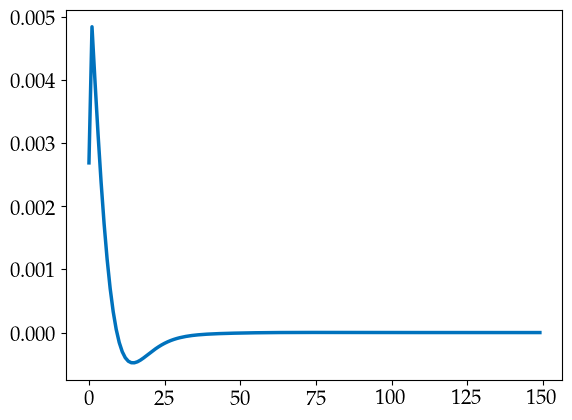

In [189]:
plt.plot(irf_sw['baseline']['Tax'])

In [193]:
model['baseline']['Tax']

0.0019500000001300278

In [138]:
compute_highgam = True
if compute_highgam:

    warnings.simplefilter('default', RuntimeWarning)

    cali_gam = {}
    Js_gam = {}
    Js_gam_mynopic = {}
    irfs_gam = {}
    irfs_gam_myopic = {}

    ss_gam = {}
    model_gam = {}

    c_decomp_gam = {}
    c_decomp_gam_inatt = {}

    sig_r = 0.01
    dr = np.zeros(T)
    dr[0] = sig_r

    input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p', 'r_opp', 'qh_col']
    output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT', 'C_BHAT_UNC', 'C_BHAT_CON']

    # gam_list = [0.6, 0.705, 0.8, 0.85]
    # gam_names = ['gamma60', 'gamma70', 'gamma80', 'gamma85']

    gam_list = [0.0, 0.05, 0.11, 0.15]
    gam_names = ['gamma60', 'gamma70', 'gamma80', 'gamma85']

    xi = 0.9
    cali_gam_main = {'gamma': 0.8, 'qh': 1.61*4, 'sigma': 2.0, 'alpha': 0.05, 'bmax': 45, 'rhom': 0.89, 'dbeta': 0.03948646900302428, 'q': 0.01,
             'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0, 'omega': 0.5,
             'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
             'kappa': 0.0160685, 'rstar': 0.03/4, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}
    
    unknowns_gam = {'beta_hi': 0.967, 'varphi': 0.836, 'theta': 0.057}
    targets_gam = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}
    cali_gam_main['sigma'] = 2.0

    for idx_gam, gam in enumerate(gam_list):
        print(f"Computing gamma: {gam}")
        cali_gam = cali_gam_main.copy()
        # cali_gam['gamma'] = gam
        cali_gam['alpha'] = gam
        ss_gam[gam_names[idx_gam]] = hank_ss.solve_steady_state(cali_gam, unknowns_gam, targets_gam, solver="hybr")
        model_gam[gam_names[idx_gam]] = hank.steady_state(ss_gam[gam_names[idx_gam]])

        # Js_gam[gam_names[idx_gam]] = {hh_name: hh2.jacobian(model_gam[gam_names[idx_gam]], inputs=input_list, outputs=output_list, T=T)}
        irfs_gam[gam_names[idx_gam]] = hank.solve_impulse_linear(model_gam[gam_names[idx_gam]], unknowns, targets, {'epsm': dr})

        irfs_gam_myopic[gam_names[idx_gam]], Js_gam_mynopic[gam_names[idx_gam]] = inattention_irf(xi, model_gam[gam_names[idx_gam]], hh2, hank, hh_name, 
                                                    input_list, output_list, unknowns, targets, dr)
        
        # c_decomp_gam[gam_names[idx_gam]] = consumption_decomp(Js_gam[gam_names[idx_gam]], irfs_gam[gam_names[idx_gam]], hh_name)
        # c_decomp_gam_inatt[gam_names[idx_gam]] = consumption_decomp(Js_gam_mynopic[gam_names[idx_gam]], irfs_gam_myopic[gam_names[idx_gam]], hh_name)

Computing gamma: 0.0
Computing gamma: 0.05
Computing gamma: 0.11
Computing gamma: 0.15


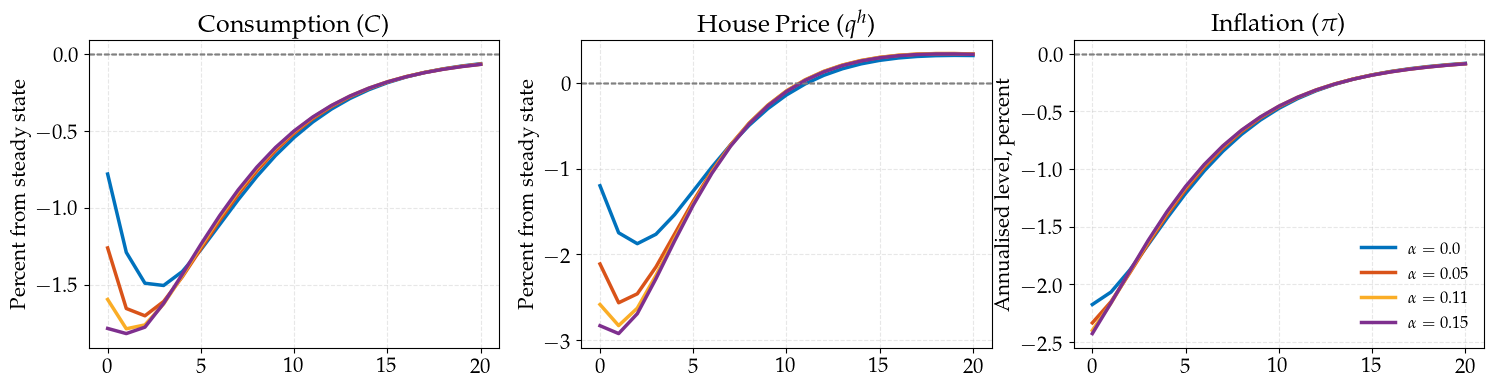

In [139]:
fig, ax = plt.subplots(1, 3, figsize=(18,12*1/3), sharex = True)
ax = ax.flatten()

var_name = {'C_BHAT': r'Consumption ($C$)', 'qh': r'House Price ($q^h$)', 'pi': r'Inflation ($\pi$)',}

def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

H = 21
for i, (key, value) in enumerate(var_name.items()):
    for idx_gam, gam in enumerate(gam_list):
        if key not in ['pi']:
            ax[i].plot(100*irfs_gam_myopic[gam_names[idx_gam]][key][:H]/model_gam[gam_names[idx_gam]][key])
            ax[i].set_ylabel('Percent from steady state')
        else:
            ax[i].plot(100*((1 + model_gam[gam_names[idx_gam]][key] +irfs_gam_myopic[gam_names[idx_gam]][key][:H])**4-1), label = fr"$\alpha = {gam}$")
            ax[i].set_ylabel('Annualised level, percent')
            ax[i].legend(fontsize=12, frameon=False)
            
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_title(var_name[key])
        ax[i].grid(True, alpha = 0.3, linestyle = '--')

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'AlphaSensitivity_v1.pdf'), dpi=1000, bbox_inches='tight')

# 5. -- Not for paper -- 

### Sign effects

In [96]:
irf_nonlin = {}

# sig_r_nonlin = 0.0099
sig_r_nonlin = 0.01/4
dr_nonlin = np.zeros(T)
dr_nonlin[0] = sig_r_nonlin

irf_nonlin['pos'] = hank.solve_impulse_nonlinear(model['baseline'], unknowns, targets, {'epsm': dr_nonlin}, verbose = False)
irf_nonlin['neg'] = hank.solve_impulse_nonlinear(model['baseline'], unknowns, targets, {'epsm': -dr_nonlin}, verbose = False)

Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 2.52E-03
On iteration 1
   max error for i_res is 3.08E-07
On iteration 2
   max error for i_res is 1.13E-10
Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 2.16E-03
On iteration 1
   max error for i_res is 7.64E-07
On iteration 2
   max error for i_res is 3.18E-10
Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 2.17E-03
On iteration 1
   max error for i_res is 7.53E-07
On iteration 2
   max error for i_res is 3.10E-10
Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 2.16E-03
On iteration 1
   max error for i_res is 7.53E-07
On iteration 2
   max error for i_res is 3.10E-10
Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 2.16E-03
On iteration 1
   max error for i_res is 7.53E-07
On iteration 2
   max error for i_res is 3.10E-10
Solving ta

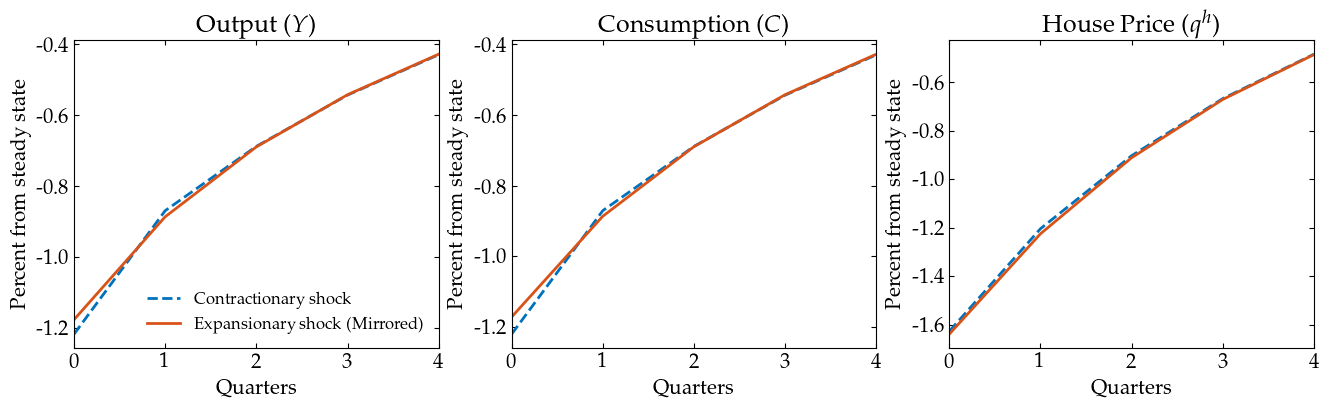

In [97]:
fig, ax = plt.subplots(1, 3, figsize=(16,12*1/3), sharex = True)
ax = ax.flatten()

irf1 = irf_nonlin['pos']
irf2 = irf_nonlin['neg']
model_ss = model['baseline']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'qh': r'House Price ($q^h$)'}

def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

HH = 5
for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:HH]/model_ss[key]), linewidth=2, linestyle='--')
        ax[i].plot(-100*(irf2[key][:HH]/model_ss[key]), linewidth=2)
        # ax[i].plot(100*(irf3[key][:H]/model_hw[key]), linewidth=2)
        # ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:HH])**4-1), linewidth=2, linestyle='--')
        ax[i].plot(-100*((1 + model_ss[key] +irf2[key][:HH])**4-1), linewidth=2)
        # ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 0:
        ax[i].legend(['Contractionary shock',fr'Expansionary shock (Mirrored)'], fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(1))
    ax[i].set_xlim(0, HH -1)
    ax[i].set_xlabel('Quarters')
    
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'SignEffects25bps_v001.pdf'), dpi=1000, bbox_inches='tight')

## The distributional effects of a monetary policy shock

In [99]:
irf_nonlin = {}

sig_r_nonlin = 0.01
# sig_r_nonlin = 0.01/4
dr_nonlin = np.zeros(T)
dr_nonlin[0] = sig_r_nonlin

irf_nonlin['pos'] = hank.solve_impulse_nonlinear(model['baseline'], unknowns, targets, {'epsm': dr_nonlin},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

In [100]:
b_bhat = model['baseline'].internals[hh_name]['b_bhat'].copy()
b_grid = model['baseline'].internals[hh_name]['b_bhat_grid'].copy()
D_con = model['baseline'].internals[hh_name]['D'].copy()
D_unc = model['baseline'].internals[hh_name]['D'].copy()

D_con[b_bhat > b_grid[0]] = 0
D_unc[b_bhat <= b_grid[0]] = 0

print(np.sum(D_con*model['baseline'].internals[hh_name]['c_bhat']))
print(np.sum(D_unc*model['baseline'].internals[hh_name]['c_bhat']))

D0 = model['baseline'].internals[hh_name]['D'] + irf_nonlin['pos'].internals[hh_name]['D'][0]
D0_con = D0.copy()
D0_unc = D0.copy()
D0_con[b_bhat > b_grid[0]] = 0
D0_unc[b_bhat <= b_grid[0]] = 0

css_con = np.sum(D0_con*model['baseline'].internals[hh_name]['c_bhat'])
css_unc = np.sum(D0_unc*model['baseline'].internals[hh_name]['c_bhat'])
c0_pol = irf_nonlin['pos'].internals[hh_name]['c_bhat'][0]
c0_con = np.sum(D0_con*c0_pol)
c0_unc = np.sum(D0_unc*c0_pol) 

print(f"Constrained c: {100*c0_con:.4f}, unconstrained c: {100*c0_unc:.4f}, total c: {c0_con + c0_unc:.4f}")
print(np.sum(D0_unc*c0_pol))

0.114929736191255
0.8843217903365899
Constrained c: -1.5330, unconstrained c: -3.4073, total c: -0.0494
-0.03407253725744104


In [118]:
print(np.sum(irf_nonlin['pos'].internals[hh_name]['D'][0]))

0.0


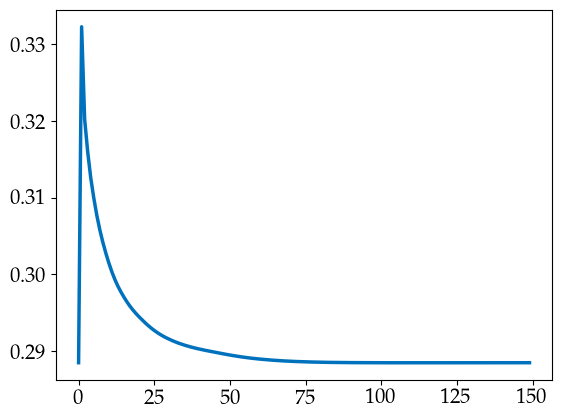

In [117]:
constrained_share = []

for t in range(T):
    bmarg = np.sum(model['baseline'].internals[hh_name]['D'] + irf_nonlin['pos'].internals[hh_name]['D'][t], axis = (0,2))
    cons_share = bmarg[0]
    constrained_share.append(cons_share)
# bmarg = np.sum(model)
plt.plot(constrained_share[:20])

In [102]:
css_D = model['baseline'].internals[hh_name]['D'] * model['baseline'].internals[hh_name]['c_bhat']
c0_D = D0 * irf_nonlin['pos'].internals[hh_name]['c_bhat'][0]
print(css_D.shape, c0_D.shape)
css_D_bh = np.sum(css_D, axis = 0)
c0_D_bh = np.sum(c0_D, axis = 0)
print(css_D_bh.shape, c0_D_bh.shape)

change = 100*c0_D_bh/css_D_bh
# change = np.where(css_D_bh != 0, 100 * c0_D_bh / css_D_bh, 0)

(6, 50, 70) (6, 50, 70)
(50, 70) (50, 70)


C:\Users\thoma\AppData\Local\Temp\ipykernel_27388\1671820074.py:8: RuntimeWarning: invalid value encountered in divide


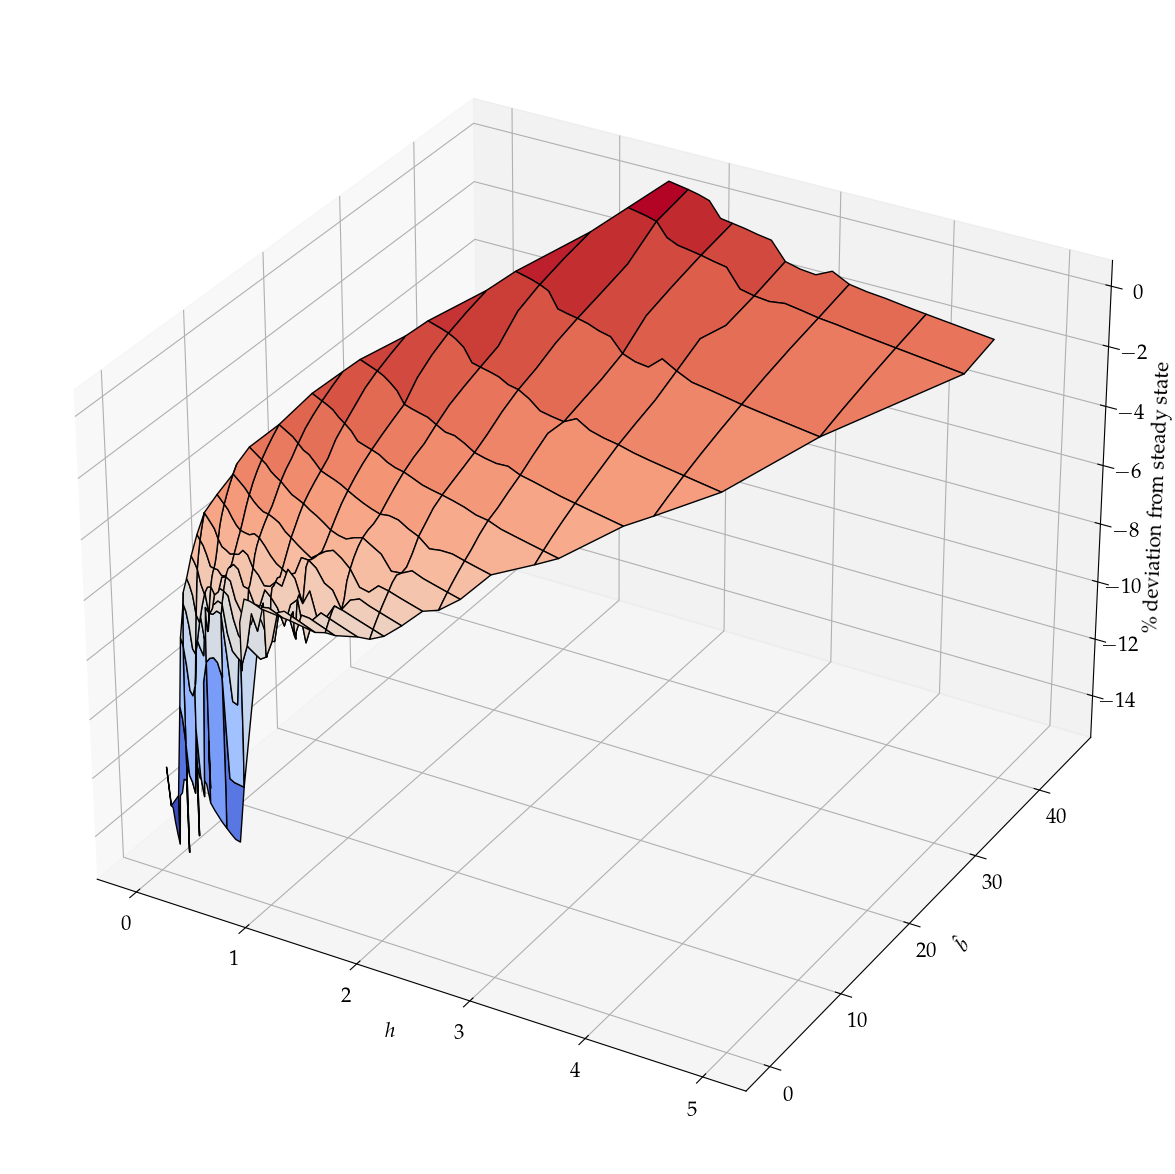

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
XX, YY = np.meshgrid(ss['baseline'].internals[hh_name]['h_bhat_grid'],ss['baseline'].internals[hh_name]['b_bhat_grid'])

fig = plt.figure(figsize=(12, 14))
ax = fig.add_subplot(111, projection='3d')
surf2 = ax.plot_surface(XX, YY, change, cmap='coolwarm', alpha=1.0, label = ' z = 0',
                        edgecolor='k', rcount = 20, ccount = 20)
ax.set_xlabel('$h$')
ax.set_ylabel('$\hat{b}$')
ax.set_zlabel('\% deviation from steady state')
fig.tight_layout()
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'c0_dist_v1.pdf'), dpi=1000, bbox_inches='tight')

# 6. Comparing with old model

In [98]:
hh = hh_housing_v3.hh_housecons_sep_old
hh1 = hh.add_hetinputs([utils.make_grids_old, utils.income_old])
hh2_old = hh1.add_hetoutputs([utils.compute_mpc])
hh_name_old = hh.name

blocks_ss = [hh2_old, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]

hank_ss_old = create_model(blocks_ss, name="Housing HANK SS")

blocks = [hh2_old, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]

hank_old = create_model(blocks, name="Housing HANK")

In [99]:
real_rigid = 5
calvo_keep = 0.75 #0.926
calvo_change = 1 - calvo_keep

beta = model['baseline']['omega'] * model['baseline']['beta_hi'] +\
      (1 - model['baseline']['omega']) * (model['baseline']['beta_hi'] - model['baseline']['dbeta'])

kappa = 1 / (1 + real_rigid) * (calvo_change * (1 - beta*calvo_keep)/(calvo_keep))

In [100]:
cali_main_old = {'gamma': 0.8, 'qh': 1.61*4, 'sigma': 2.0, 'alpha': 0.05, 'bmax': 45, 'rhom': 0.89,
                'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0,
                'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
                'kappa': 0.01, 'rstar': 0.03/4, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}

cali_main_old['kappa'] = 0.1 #kappa
cali_main_old['alpha'] = 0.0
cali_main_old['gamma'] = 0.0


unknowns_ss_old = {'beta': 0.970, 'varphi': 0.836, 'theta': 0.061}
targets_ss_old = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss['old'] = hank_ss_old.solve_steady_state(cali_main_old, unknowns_ss_old, targets_ss_old, solver="hybr")
model['old'] = hank_old.steady_state(ss['old'])

In [101]:
Js_gammalow = {hh_name_old: hh2_old.jacobian(model['old'], inputs=input_list, outputs=output_list, T=50)}

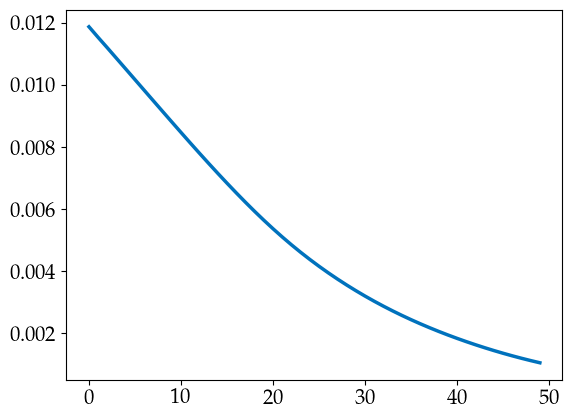

In [102]:
plt.plot(Js_gammalow[hh_name_old]['C_BHAT']['r'][:,0])

In [103]:
cali_main_old_qh10 = cali_main_old.copy()
cali_main_old_qh10['qh'] = 2.4*4
ss['old_qh10'] = hank_ss_old.solve_steady_state(cali_main_old_qh10, unknowns_ss_old, targets_ss_old, solver="hybr")
model['old_qh10'] = hank_old.steady_state(ss['old_qh10'])

c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:358: RuntimeWarning: invalid value encountered in power
c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:358: RuntimeWarning: invalid value encountered in power
c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:358: RuntimeWarning: invalid value encountered in power
c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:358: RuntimeWarning: invalid value encountered in power
c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:358: RuntimeWarning: invalid value encountered in power
c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:358: Runtime

In [104]:
print(f"beta: {ss['old']['beta']:.3f}, theta: {ss['old']['theta']:.3f}, varphi: {ss['old']['varphi']:.3f}, MPC: {ss['old']['MPC']:.3f}")
print(f"beta: {ss['old_qh10']['beta']:.3f}, theta: {ss['old_qh10']['theta']:.3f}, varphi: {ss['old_qh10']['varphi']:.3f}, MPC: {ss['old_qh10']['MPC']:.3f}")

beta: 0.946, theta: 0.087, varphi: 0.833, MPC: 0.071
beta: 0.954, theta: 0.134, varphi: 0.833, MPC: 0.053


In [105]:
cali_compare= {'gamma': 0.8, 'qh': 1.61*4, 'sigma': 2.0, 'alpha': 0.05, 'bmax': 45, 'rhom': 0.89, 'q': 0, 'dbeta': 0.0,
                'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0, 'omega': 0.0,
                'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
                'kappa': 0.01, 'rstar': 0.03/4, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}

cali_compare['kappa'] = kappa

unknowns_ss_compare = {'beta_hi': 0.970, 'varphi': 0.836, 'theta': 0.061}
targets_ss_compare = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss['compare_old'] = hank_ss.solve_steady_state(cali_compare, unknowns_ss_compare, targets_ss_compare, solver="hybr")
model['compare_old'] = hank.steady_state(ss['compare_old'])

print(f"beta_hi: {ss['compare_old']['beta_hi']:.3f}, theta: {ss['compare_old']['theta']:.3f}, varphi: {ss['compare_old']['varphi']:.3f}")

beta_hi: 0.954, theta: 0.054, varphi: 0.834


In [106]:
sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

Js_dict = {}

xi = 0.99 # persistence of expectations
irfs['old'], Js_dict['old'] = inattention_irf(xi, model['old'], hh2_old, hank_old, hh_name_old, 
                              input_list, output_list, unknowns, targets, dr)
# irfs['compare_old'], _ = inattention_irf(xi, model['compare_old'], hh2, hank, hh_name, 
#                                       input_list, output_list, unknowns, targets, dr)

KeyError: 'C_BHAT_UNC'

In [ ]:
irfs['old_qh10'], Js_dict['old_qh10'] = inattention_irf(xi, model['old_qh10'], hh2_old, hank_old, hh_name_old, 
                                   input_list, output_list, unknowns, targets, dr)

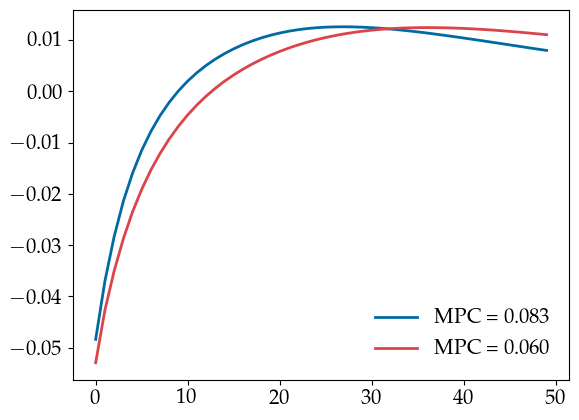

In [ ]:
i = 0
H_jac = 50
plt.plot(Js_dict['old'][hh_name_old]['C_BHAT']['r'][:H_jac,i], label = f"MPC = {ss['old']['MPC']:.3f}")
plt.plot(Js_dict['old_qh10'][hh_name_old]['C_BHAT']['r'][:H_jac,i], label = f"MPC = {ss['old_qh10']['MPC']:.3f}")
plt.legend(frameon=False)

In [ ]:
sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

xi = 0.99 # persistence of expectations

model_ss = model['old'] # steady state for qh = (baseline)
model_hw = model['compare_old'] # steady state for qh = 10

Js = {hh_name: hh2_old.jacobian(model_ss, inputs=input_list, outputs=output_list, T=T)}
Js_hw = {hh_name_old: hh2.jacobian(model_hw, inputs=input_list, outputs=output_list, T=T)}

jac_ = manipulate_jac(xi, Js, input_list, output_list, hh_name)
jac_hw = manipulate_jac(xi, Js_hw, input_list, output_list, hh_name_old)

Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hank')}
Js_myopic_hw = {hh_name_old: JacobianDict(jac_hw, inputs=input_list, outputs=output_list, name='hank')}

irfs['old'] = (hank_old.solve_jacobian(model_ss, unknowns=unknowns, targets=targets, T=T,
                                              Js=Js_myopic, inputs=['epsm'], 
                                              outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

irfs['compare_old'] = (hank.solve_jacobian(model_hw, unknowns=unknowns, targets=targets, T=T,
                                              Js=Js_myopic_hw, inputs=['epsm'], 
                                              outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

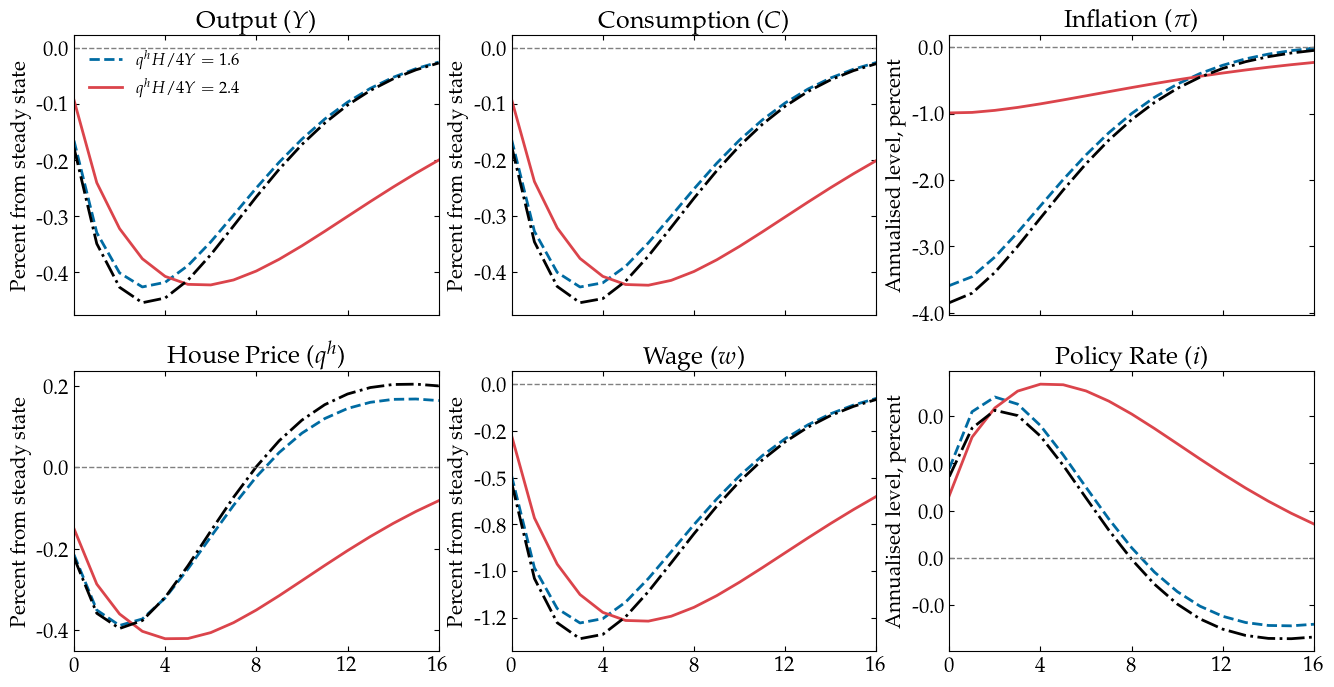

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(16,12*2/3), sharex = True)
ax = ax.flatten()

irf1 = irfs['old']
irf2 = irfs['compare_old']
irf3 = irfs['old_qh10']
model_ss = model['old']
model_highwealth = model['compare_old']
model_hw = model['old_qh10']

var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 'pi': r'Inflation ($\pi$)', 
            'qh': r'House Price ($q^h$)','w': r'Wage ($w$)', 'i': r'Policy Rate ($i$)'}

for i, (key, value) in enumerate(var_name.items()):   
    if key in devss:   
        ax[i].plot(100*(irf1[key][:H]/model_ss[key]), linewidth=2, linestyle='--')
        ax[i].plot(100*(irf2[key][:H]/model_highwealth[key]), linewidth=2)
        ax[i].plot(100*(irf3[key][:H]/model_hw[key]), linewidth=2, ls = 'dashdot')
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + model_ss[key] +irf1[key][:H])**4-1), linewidth=2, linestyle='--')
        ax[i].plot(100*((1 + model_highwealth[key] +irf2[key][:H])**4-1), linewidth=2)
        ax[i].plot(100*((1 + model_hw[key] +irf3[key][:H])**4-1), linewidth=2, ls = 'dashdot')
        ax[i].axhline(y=100*((1 + model_ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 0:
        ax[i].legend([r'$q^hH/4Y = 1.6$',r'$q^hH/4Y = 2.4$'], fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)
    
plt.show()

In [ ]:
c_decomp = {}
c_decomp['old'] = consumption_decomp(Js_dict['old'], irfs['old'], hh_name_old)
c_decomp['old_qh10'] = consumption_decomp(Js_dict['old_qh10'], irfs['old_qh10'], hh_name_old)

In [ ]:
def plot_decomp(nrows, ncols, decomp_dict, irfs, H = 17, plot_together = False):
    fig, ax = plt.subplots(nrows, ncols, figsize=(16*ncols/3,12*nrows/3), sharex = True, sharey = True)

    if nrows == 1 and ncols == 1:
        ax = ax.flatten()

    plot_total = False

    ii = 0
    for key, value in decomp_dict.items():
        ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], label='Housing effect')
        ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], label='Indirect effect')
        ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], label='Direct effect')
        ax[ii].set_title(key)

        ax[ii].set_xlabel('Quarters')
        ax[ii].set_ylabel('Percent from steady state')
        ax[ii].xaxis.set_major_locator(MultipleLocator(4))
        ax[ii].set_xlim(0, 16)
        ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
        ax[ii].legend(fontsize=10, frameon=False) #, loc='center right', bbox_to_anchor=(1, 0.44)

        ii += 1

    if plot_together:
        jj = 0
        
        for key, value in decomp_dict.items():
            if jj == 0:
                ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#006BA2')
                ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#DB444B')
                ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], label=f'{key}', color = '#000000')
            else: 
                ax[ii].plot(100*decomp_dict[key]['housing'][:H]/irfs[key]['C_BHAT'], color = '#006BA2', ls = 'dashdot', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['indirect'][:H]/irfs[key]['C_BHAT'], color = '#DB444B', ls = 'dashdot', label=f'{key}')
                ax[ii].plot(100*decomp_dict[key]['direct'][:H]/irfs[key]['C_BHAT'], color = '#000000', ls = 'dashdot', label=f'{key}')

            jj += 1
            ax[ii].legend(fontsize=10, frameon=False, ncols = 2)
            ax[ii].set_title('Comparision')

    plt.show()

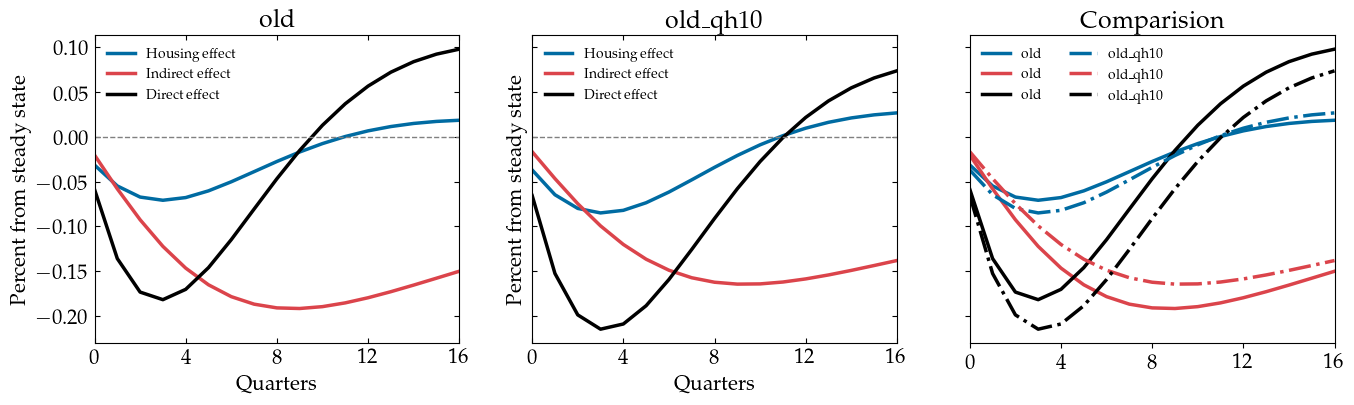

In [ ]:
plot_decomp(1, 3, c_decomp, model, H = 17, plot_together=True)

In [ ]:
# irfs = {}

# xi = 0.99 # persistence of expectations
# rhom = 0.89
# # kappa = 0.01
# model['baseline']['rhom'] = rhom
# model['baseline']['kappa'] = kappa

# model['qh10']['rhom'] = rhom
# model['qh10']['kappa'] = kappa

# model_ss = model['baseline'] # steady state for qh = (baseline)
# model_hw = model['qh10'] # steady state for qh = 10

# Js = {hh_name: hh2.jacobian(model_ss, inputs=input_list, outputs=output_list, T=T)}
# Js_hw = {hh_name: hh2.jacobian(model_hw, inputs=input_list, outputs=output_list, T=T)}

# jac_ = manipulate_jac(xi, Js, input_list, output_list, hh_name)
# jac_hw = manipulate_jac(xi, Js_hw, input_list, output_list, hh_name)

# Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hank')}
# Js_myopic_hw = {hh_name: JacobianDict(jac_hw, inputs=input_list, outputs=output_list, name='hank')}

# irfs['fire'] = (hank.solve_jacobian(model_ss, unknowns=unknowns, targets=targets, T=T, inputs=['epsm'], 
#                                               outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
#                                                        'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

# irfs['inatt'] = (hank.solve_jacobian(model_ss, unknowns=unknowns, targets=targets, T=T,
#                                               Js=Js_myopic, inputs=['epsm'], 
#                                               outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
#                                                        'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

# irfs['inatt_hw'] = (hank.solve_jacobian(model_hw, unknowns=unknowns, targets=targets, T=T,
#                                               Js=Js_myopic_hw, inputs=['epsm'], 
#                                               outputs=['Y', 'C_BHAT', 'pi', 'r', 'i', 'goods_mkt', 'house_mkt',
#                                                        'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'CHI']) @ {"epsm": dr})

# Comparison with Eskildsen

In [134]:
hh = hh_housing_v3.hh_housecons_sep
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])
hh2 = hh1.add_hetoutputs([utils.compute_mpc])

hh_name = hh.name

blocks_ss = [hh2, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime, utils.dummy_block]

hank_ss = create_model(blocks_ss, name="Housing HANK SS")

blocks = [hh2, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
            utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]

hank = create_model(blocks, name="Housing HANK")

T = 150 # REMEMBER TO CHANGE BACK TO 150
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
exogenous = ['rstar', 'Z', 'gamma']

ss_lin = {}
model_lin = {}

In [135]:
cali_main = {'gamma': 0.85, 'qh': 1.61*4, 'sigma': 2.0, 'alpha': 0.05, 'bmax': 75, 'rhom': 0.89, 'omega': 0.5, 'q': 0.01,
             'hmax': 8, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0,
             'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
             'kappa': 0.0160685, 'rstar': 0.03/4, 'phi': 1.27, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}

cali_main['rhom'] = 0.73
cali_main['phi'] = 1.27
cali_main['rstar'] = 1.0/0.99 - 1
# cali_main['alpha'] = 0.0 # REMEMBER TO CHANGE THIS BACK

# cali_main['gamma'] = 0.5 # REMEMBER TO CHANGE THIS BACK TO 0.85 AFTER TESTING
# cali_main['qh'] = 0.5*4
# cali_main['dbeta'] = 0.05

alt_numerical = False
if alt_numerical:
    cali_main['nB'] = 60
    cali_main['nZ'] = 11
    cali_main['bmax'] = 120 #90
    cali_main['hmax'] = 10

unknowns_ss = {'beta_hi': 0.970, 'varphi': 0.836, 'theta': 0.061, 'dbeta': 0.053}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0, 'MPC': 0.15}

# unknowns_ss = {'beta_hi': 0.933, 'varphi': 0.834, 'theta': 0.029}
# targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss_lin['baseline'] = hank_ss.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")
model_lin['baseline'] = hank.steady_state(ss_lin['baseline'])

c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:260: RuntimeWarning: invalid value encountered in power


In [62]:
cali_alt = cali_main.copy()
cali_alt['dbeta'] = 0.0
cali_alt['omega'] = 0.0
cali_alt['q'] = 0.00

unknowns_alt = {'beta_hi': 0.958, 'varphi': 0.836, 'theta': 0.072}
targets_alt = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss_lin['alt'] = hank_ss.solve_steady_state(cali_alt, unknowns_alt, targets_alt, solver="hybr")
model_lin['alt'] = hank.steady_state(ss_lin['alt'])

In [50]:
print(f"beta: {ss_lin['alt']['beta_hi']:.3f}, theta: {ss_lin['alt']['theta']:.3f}, varphi: {ss_lin['alt']['varphi']:.3f}, MPC: {ss_lin['alt']['MPC']:.3f}, dbeta: {ss_lin['alt']['dbeta']:.3f}")

beta: 0.952, theta: 0.071, varphi: 0.835, MPC: 0.097, dbeta: 0.000


In [108]:
cali_noborrow = cali_main.copy()
cali_noborrow['gamma'] = 0.0
cali_noborrow['alpha'] = 0.05
cali_noborrow['rstar'] = 1.0/0.99 - 1
cali_noborrow['dbeta'] = 0.0

unknowns_ss = {'beta_hi': 0.9441832474139153, 'varphi': 0.8340618192568453, 'theta': 0.11499300594278307}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss_lin['noborrow'] = hank_ss.solve_steady_state(cali_noborrow, unknowns_ss, targets_ss, solver="hybr")
model_lin['noborrow'] = hank.steady_state(ss_lin['noborrow'])

In [170]:
compute_mpc = False
compute_highwealth = True

if compute_mpc:
    mpc_list = [0.2, 0.25]
    mpc_names = ['mpc20', 'mpc25']

    for idx, (mpc, mpc_name) in enumerate(zip(mpc_list, mpc_names)):
        print(f"Computing MPC: {mpc}")
        # cali_mpc = cali_main.copy()
        targets_mpc = targets_ss.copy()
        targets_mpc['MPC'] = mpc
        ss_lin[mpc_name] = hank_ss.solve_steady_state(cali_main, unknowns_ss, targets_mpc, solver="hybr")
        model_lin[mpc_name] = hank.steady_state(ss_lin[mpc_name])

if compute_highwealth:
    cali_highwealth = cali_main.copy()
    cali_highwealth['qh'] = 2.4*4
    cali_highwealth['bmax'] = 100
    ss_lin['highwealth'] = hank_ss.solve_steady_state(cali_highwealth, unknowns_ss, targets_ss, solver="hybr")
    model_lin['highwealth'] = hank.steady_state(ss_lin['highwealth'])

In [169]:
if compute_highwealth:
    cali_highwealth = cali_main.copy()
    cali_highwealth['qh'] = 2.4*4
    cali_highwealth['bmax'] = 100
    cali_highwealth['gamma'] = model_lin['baseline']['gamma']*model_lin['baseline']['qh'] / cali_highwealth['qh']
    print(cali_highwealth['gamma'])
    ss_lin['highwealth_lowgam'] = hank_ss.solve_steady_state(cali_highwealth, unknowns_ss, targets_ss, solver="hybr")
    model_lin['highwealth_lowgam'] = hank.steady_state(ss_lin['highwealth_lowgam'])

NameError: name 'compute_highwealth' is not defined

In [279]:
compute_diffgamma = True
if compute_diffgamma:
    gamma_list = [0.5, 0.6, 0.8, 0.85]
    gamma_names = ['gamma50', 'gamma60', 'gamma80', 'gamma85']

    unknowns_gam = {'beta_hi': 0.970, 'varphi': 0.836, 'theta': 0.061}
    targets_gam = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

    for idx, (gamma, gamma_name) in enumerate(zip(gamma_list, gamma_names)):
        print(f"Computing gamma: {gamma}")
        cali_gamma = cali_main.copy()

        cali_gamma['dbeta'] = model_lin['baseline']['dbeta']
        cali_gamma['gamma'] = gamma
        
        ss_lin[gamma_name] = hank_ss.solve_steady_state(cali_gamma, unknowns_gam, targets_gam, solver="hybr")
        model_lin[gamma_name] = hank.steady_state(ss_lin[gamma_name])

Computing gamma: 0.5
Computing gamma: 0.6
Computing gamma: 0.8
Computing gamma: 0.85


c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:260: RuntimeWarning: invalid value encountered in power


In [280]:
print(f"beta_hi: {ss_lin['baseline']['beta_hi']:.3f}, beta_lo: {ss_lin['baseline']['beta_hi'] - ss_lin['baseline']['dbeta']:.3f}, theta: {ss_lin['baseline']['theta']:.3f}, varphi: {ss_lin['baseline']['varphi']:.3f}, MPC: {ss_lin['baseline']['MPC']:.3f}")
print(f"beta_hi: {ss_lin['highwealth']['beta_hi']:.3f}, beta_lo: {ss_lin['highwealth']['beta_hi'] - ss_lin['highwealth']['dbeta']:.3f} theta: {ss_lin['highwealth']['theta']:.3f}, varphi: {ss_lin['highwealth']['varphi']:.3f}, MPC: {ss_lin['highwealth']['MPC']:.3f}")
print(f"beta_hi: {ss_lin['gamma85']['beta_hi']}")

def print_calibrated(model_ss):
    print(f"beta_hi: {model_ss['beta_hi']:.3f}, beta_lo: {model_ss['beta_hi'] - model_ss['dbeta']:.3f}, theta: {model_ss['theta']:.3f}, varphi: {model_ss['varphi']:.3f}, MPC: {model_ss['MPC']:.3f}")

print_calibrated(model_lin['baseline'])

beta_hi: 0.969, beta_lo: 0.908, theta: 0.075, varphi: 0.835, MPC: 0.150
beta_hi: 0.979, beta_lo: 0.876 theta: 0.119, varphi: 0.836, MPC: 0.150
beta_hi: 0.9685509744145484


## Transition dynamics

In [136]:
freq = 0.25
real_rigid = 5
r = cali_main['rstar']
kappa_slope = 1 / (1 + real_rigid)* (1 - 1/(1 + r)*(1 - freq))*freq/(1 - freq)
print(f"kappa slope: {kappa_slope:.4f}")

kappa slope: 0.0143


In [137]:
# Shock settings
sig_r = 0.0029
dr = np.zeros(T)
dr[0] = sig_r

input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p', 'r_opp', 'qh_col']
output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT', 'C_BHAT_UNC', 'C_BHAT_CON']

irf_lin = {}
CurlyJs = {}
c_decomp = {}

In [64]:
# model_lin['baseline']['kappa'] = 0.05
CurlyJs['baseline'] = {hh_name: hh2.jacobian(model_lin['baseline'], inputs=input_list, outputs=output_list, T=T)}
irf_lin['baseline'] = hank.solve_impulse_linear(model_lin['baseline'], unknowns, targets, {'epsm': dr})

c_decomp['baseline'] = consumption_decomp(CurlyJs['baseline'], irf_lin['baseline'], hh_name, do_assert = True)

In [65]:
# model_lin['baseline']['kappa'] = 0.05
CurlyJs['alt'] = {hh_name: hh2.jacobian(model_lin['alt'], inputs=input_list, outputs=output_list, T=T)}
irf_lin['alt'] = hank.solve_impulse_linear(model_lin['alt'], unknowns, targets, {'epsm': dr})

c_decomp['alt'] = consumption_decomp(CurlyJs['alt'], irf_lin['alt'], hh_name, do_assert = True)

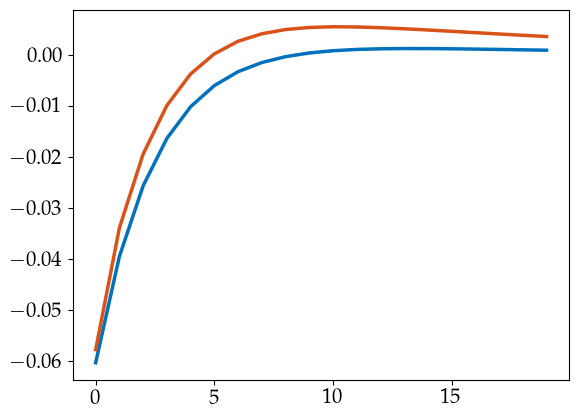

In [58]:
plt.plot(irf_lin['alt']['qh'][:20])
plt.plot(irf_lin['baseline']['qh'][:20])

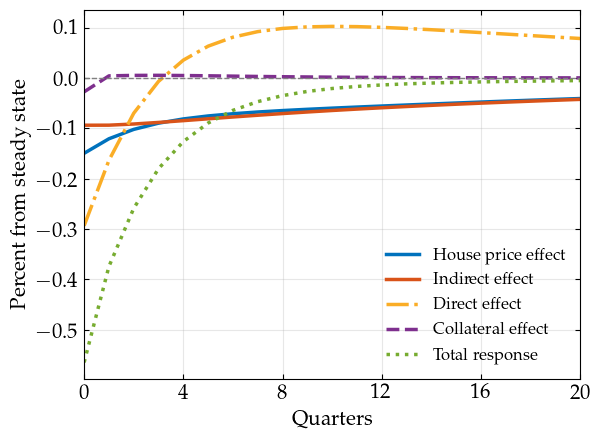

In [67]:
decomp_test = consumption_decomp(CurlyJs['alt'], irf_lin['alt'], hh_name, do_assert = True)
fig = plot_decomp_single(decomp_test, model_lin['alt'], H = 21)

In [385]:
if compute_mpc:
    irf_lin['mpc20'] = hank.solve_impulse_linear(model_lin['mpc20'], unknowns, targets, {'epsm': dr})
    irf_lin['mpc25'] = hank.solve_impulse_linear(model_lin['mpc25'], unknowns, targets, {'epsm': dr})

if compute_highwealth:
    CurlyJs['highwealth'] = {hh_name: hh2.jacobian(model_lin['highwealth'], inputs=input_list, outputs=output_list, T=T)}
    irf_lin['highwealth'] = hank.solve_impulse_linear(model_lin['highwealth'], unknowns, targets, {'epsm': dr})
    c_decomp['highwealth'] = consumption_decomp(CurlyJs['highwealth'], irf_lin['highwealth'], hh_name, do_assert = True)
    
if compute_highwealth:
    irf_lin['highwealth_lowgam'] = hank.solve_impulse_linear(model_lin['highwealth_lowgam'], unknowns, targets, {'epsm': dr})

In [283]:
if compute_diffgamma:
    for gamma_name in gamma_names:
        irf_lin[gamma_name] = hank.solve_impulse_linear(model_lin[gamma_name], unknowns, targets, {'epsm': dr})
        CurlyJs[gamma_name] = {hh_name: hh2.jacobian(model_lin[gamma_name], inputs=input_list, outputs=output_list, T=T)}
        c_decomp[gamma_name] = consumption_decomp(CurlyJs[gamma_name], irf_lin[gamma_name], hh_name, do_assert = True)

<class 'types.SimpleNamespace'>
<class 'types.SimpleNamespace'>
<class 'types.SimpleNamespace'>
<class 'types.SimpleNamespace'>


In [601]:
# model_lin['baseline']['kappa'] = 0.05
kappa_list = [0.01, 0.0160685, 0.05, 0.1]
kappa_names = ['kappa01', 'kappa016', 'kappa05', 'kappa1']

for idx, kappaa in enumerate(kappa_list):
    print(f"Computing kappa: {kappaa}")
    model_lin['baseline']['kappa'] = kappaa
    irf_lin[kappa_names[idx]] = hank.solve_impulse_linear(model_lin['baseline'], unknowns, targets, {'epsm': dr})
    
model_lin['baseline']['kappa'] = 0.0160685

Computing kappa: 0.01
Computing kappa: 0.0160685
Computing kappa: 0.05
Computing kappa: 0.1


In [8]:
# model_lin['baseline']['kappa'] = 0.05
phi_list = [1.0, 1.27, 1.5, 2.0]
phi_names = ['phi1', 'phi127', 'phi15', 'phi2']

for idx, phi in enumerate(phi_list):
    print(f"Computing phi: {phi}")
    model_lin['baseline']['phi'] = phi
    irf_lin[phi_names[idx]] = hank.solve_impulse_linear(model_lin['baseline'], unknowns, targets, {'epsm': dr})
    
model_lin['baseline']['phi'] = 1.27

Computing phi: 1.0
Computing phi: 1.27
Computing phi: 1.5
Computing phi: 2.0


In [381]:
# print(np.sum(100*(irf_lin['gamma60']['C_BHAT'][0] - irf_lin['gamma85']['C_BHAT'][0])/model_lin['baseline']['C_BHAT']))
print(f"Impact consumption effect: {100*irf_lin['gamma60']['C_BHAT'][0]/model_lin['gamma60']['C_BHAT']:.1f}")
print(f"Impact consumption effect: {100*irf_lin['gamma85']['qh'][0]/model_lin['gamma85']['qh']:.1f}")

gam60_c0 = irf_lin['gamma60']['C_BHAT'][0]/model_lin['gamma60']['C_BHAT']
gam85_c0 = irf_lin['gamma85']['C_BHAT'][0]/model_lin['gamma85']['C_BHAT']
print(gam60_c0/gam85_c0)

Impact consumption effect: -0.7
Impact consumption effect: -0.9
0.8060766068745123


## Non-linear IRFs

Computing the non-linear IRFs for positive and negative monetary policy shocks to assess sign asymmetries

In [125]:
irf_nonlin = {}

dr_nonlin = np.zeros(T)
sig_r_nonlin = 0.0029 # 0.01
dr_nonlin[0] = sig_r_nonlin

dr_nonlin_large = np.zeros(T)
sig_r_nonlin_large = 0.01
dr_nonlin_large[0] = sig_r_nonlin_large

irf_nonlin['neg'] = hank.solve_impulse_nonlinear(model_lin['baseline'], unknowns, targets, {'epsm': -dr_nonlin},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})
irf_nonlin['pos'] = hank.solve_impulse_nonlinear(model_lin['baseline'], unknowns, targets, {'epsm': dr_nonlin},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

irf_nonlin['neg_100bps'] = hank.solve_impulse_nonlinear(model_lin['baseline'], unknowns, targets, {'epsm': -dr_nonlin_large},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})
irf_nonlin['pos_100bps'] = hank.solve_impulse_nonlinear(model_lin['baseline'], unknowns, targets, {'epsm': dr_nonlin_large},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

In [93]:
irf_nonlin = {}

dr_nonlin = np.zeros(T)
sig_r_nonlin = 0.0029 # 0.01
dr_nonlin[0] = sig_r_nonlin

dr_nonlin_large = np.zeros(T)
sig_r_nonlin_large = 0.01
dr_nonlin_large[0] = sig_r_nonlin_large

irf_nonlin['neg'] = hank.solve_impulse_nonlinear(model_lin['noborrow'], unknowns, targets, {'epsm': -dr_nonlin},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})
irf_nonlin['pos'] = hank.solve_impulse_nonlinear(model_lin['noborrow'], unknowns, targets, {'epsm': dr_nonlin},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

irf_nonlin['neg_100bps'] = hank.solve_impulse_nonlinear(model_lin['noborrow'], unknowns, targets, {'epsm': -dr_nonlin_large},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})
irf_nonlin['pos_100bps'] = hank.solve_impulse_nonlinear(model_lin['noborrow'], unknowns, targets, {'epsm': dr_nonlin_large},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

In [113]:
shock_list = np.linspace(-0.0225, 0.0225, 18)
irf_nonlin_pos_dict = {}
irf_nonlin_neg_dict = {}

for idx, shock in enumerate(shock_list):
    print(f"Computing shock: {shock}")
    dr_nonlin = np.zeros(T)
    dr_nonlin[0] = shock
    irf_nonlin_pos_dict[idx] = hank.solve_impulse_nonlinear(model_lin['noborrow'], unknowns, targets, {'epsm': dr_nonlin},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

Computing shock: -0.0225
Computing shock: -0.019852941176470587
Computing shock: -0.017205882352941175
Computing shock: -0.014558823529411765
Computing shock: -0.011911764705882353
Computing shock: -0.00926470588235294
Computing shock: -0.00661764705882353
Computing shock: -0.003970588235294118
Computing shock: -0.001323529411764706
Computing shock: 0.001323529411764706
Computing shock: 0.003970588235294118
Computing shock: 0.00661764705882353
Computing shock: 0.009264705882352939
Computing shock: 0.011911764705882351
Computing shock: 0.014558823529411763
Computing shock: 0.017205882352941175
Computing shock: 0.019852941176470587
Computing shock: 0.0225


In [116]:
dr_1bps = np.zeros(T)
dr_1bps[0] = 1
irf25 = hank.solve_impulse_linear(model_lin['noborrow'], unknowns, targets, {'epsm': dr_1bps})

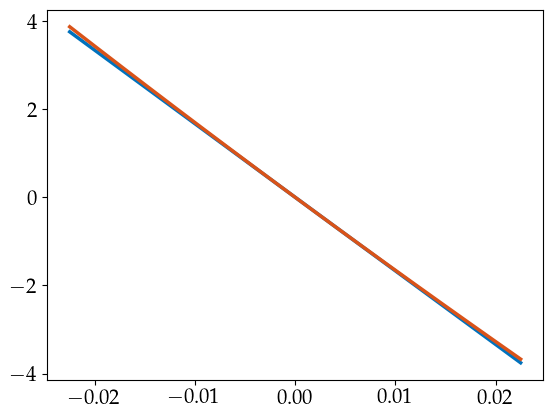

In [118]:
impact_linear = []
for idx, shock in enumerate(shock_list):
    impact_linear.append(100*irf25['C_BHAT'][0]*shock)

impact_pos = []
impact_neg = []
shock_list_bps = np.array([10000*shock for shock in shock_list])
shock_list_pp = np.array([100*shock for shock in shock_list])

for idx, shock in enumerate(shock_list):
    # impact_neg.append(irf_nonlin_neg_dict[idx]['C_BHAT'][0])
    impact_pos.append(100*irf_nonlin_pos_dict[idx]['C_BHAT'][0])

# plt.plot(shock_list, impact_neg)
# irf25 = hank.solve_impulse_linear(model_lin['baseline'], unknowns, targets, {'epsm': dr_nonlin})
plt.plot(shock_list, impact_linear)
plt.plot(shock_list, impact_pos)

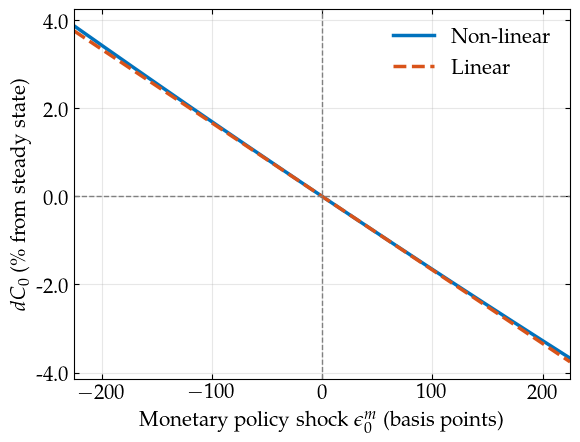

In [132]:
def different_shock_size(model_ss, impact_nonlin, impact_lin):
        
        fig, ax = plt.subplots()
        
        ax.plot(shock_list_bps, impact_nonlin/model_ss['C_BHAT'], 
                label=r'Non-linear')
        ax.plot(shock_list_bps, impact_lin/model_ss['C_BHAT'], 
                label=r'Linear', linestyle='--')
        ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax.axvline(x=0.0, color='grey', linestyle='--', linewidth=1.0)
        
        ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
        # ax.xaxis.set_major_locator(MultipleLocator(2))
        ax.set_xlim(-225, 225)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel(r'Monetary policy shock $\epsilon_0^m$ (basis points)')
        ax.set_ylabel(r'$dC_0$ (\% from steady state)')
        ax.legend(frameon=False)

        return fig

fig = different_shock_size(model_lin['baseline'], impact_pos, impact_linear)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'NonLinearVsLinDiffShock_noborr.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

In [128]:
print(impact_linear[1]/impact_linear[-2])

-1.0


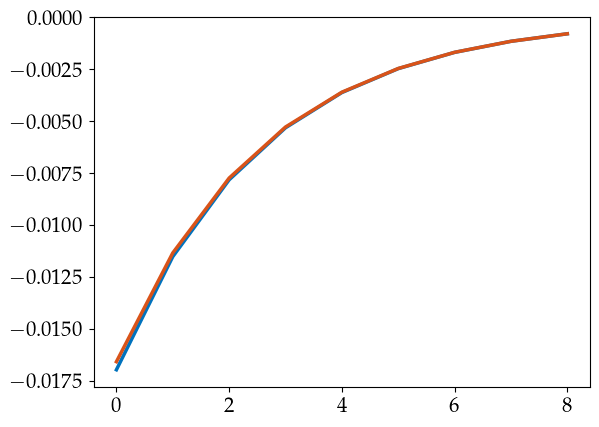

In [98]:
# fig = plots.nonlin_consumption(model_lin['baseline'], irf_nonlin, key = 'C_BHAT', H = 9, big_shock = False)
plt.plot(-irf_nonlin['neg_100bps']['C_BHAT'][:9])
plt.plot(irf_nonlin['pos_100bps']['C_BHAT'][:9])

In [90]:
sig_theta = 0.025
rho_theta = 0.65
dtheta = sig_theta*rho_theta**np.arange(T)

irf_nonlin_theta = {}

model_lin['baseline']['kappa'] = 0.05
irf_nonlin_theta['neg_theta'] = hank.solve_impulse_nonlinear(model_lin['noborrow'], unknowns, targets, {'theta': -dtheta},
                                                 internals = {hh_name}, verbose = True, options={'taylor': {'verbose': False}},
                                                 maxit = 200)
irf_nonlin_theta['pos_theta'] = hank.solve_impulse_nonlinear(model_lin['noborrow'], unknowns, targets, {'theta': dtheta},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}},
                                                 maxit = 200)

Solving Housing HANK for ['pi', 'w', 'N', 'qh'] to hit ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for asset_mkt is 1.59E-01
   max error for wage_res is 5.49E-03
   max error for house_mkt is 2.52E-02
On iteration 1
   max error for nkpc_res is 5.08E-08
   max error for asset_mkt is 5.90E-02
   max error for wage_res is 1.51E-03
   max error for house_mkt is 9.36E-03
On iteration 2
   max error for nkpc_res is 4.45E-08
   max error for asset_mkt is 3.27E-03
   max error for wage_res is 1.40E-03
   max error for house_mkt is 2.75E-04
On iteration 3
   max error for nkpc_res is 4.32E-08
   max error for asset_mkt is 6.31E-04
   max error for wage_res is 1.67E-04
   max error for house_mkt is 6.15E-05
On iteration 4
   max error for nkpc_res is 2.00E-08
   max error for asset_mkt is 4.82E-04
   max error for wage_res is 1.31E-04
   max error for house_mkt is 5.13E-05
On iteration 5
   max error for nkpc_res is 2.06E

ValueError: No convergence after 200 backward iterations!

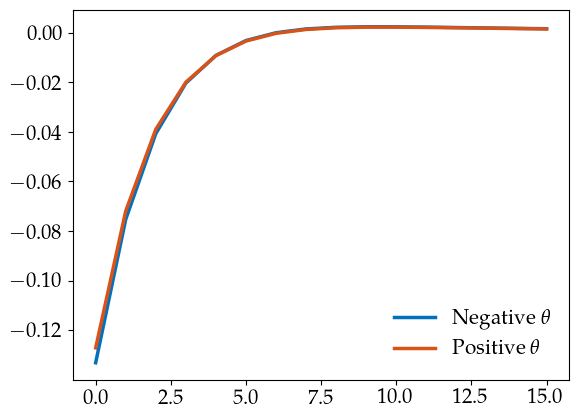

In [87]:
plt.plot(-100*irf_nonlin_theta['neg_theta']['C_BHAT'][:16], label = r'Negative $\theta$')
plt.plot(100*irf_nonlin_theta['pos_theta']['C_BHAT'][:16], label = r'Positive $\theta$')
plt.legend(frameon=False)

In [180]:
print(10000*irf_nonlin['neg']['C_BHAT'][0]/model_lin['baseline']['C_BHAT'])
print(10000*irf_nonlin['pos']['C_BHAT'][0]/model_lin['baseline']['C_BHAT'])
print(100*irf_nonlin['neg']['C_BHAT'][0]/model_lin['baseline']['C_BHAT'] + 100*irf_nonlin['pos']['C_BHAT'][0])

78.64206914141016
-81.29021048696072
-0.025724050399190457


In [206]:
irf25 = hank.solve_impulse_linear(model_lin['baseline'], unknowns, targets, {'epsm': dr_nonlin})
irf100 = hank.solve_impulse_linear(model_lin['baseline'], unknowns, targets, {'epsm': 4*dr_nonlin})

In [138]:
shock_list = np.linspace(-0.025, 0.025, 18)
irf_nonlin_pos_dict = {}
irf_nonlin_neg_dict = {}

for idx, shock in enumerate(shock_list):
    print(f"Computing shock: {shock}")
    dr_nonlin = np.zeros(T)
    dr_nonlin[0] = shock
    irf_nonlin_pos_dict[idx] = hank.solve_impulse_nonlinear(model_lin['baseline'], unknowns, targets, {'epsm': dr_nonlin},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})
    # irf_nonlin_neg_dict[idx] = hank.solve_impulse_nonlinear(model_lin['baseline'], unknowns, targets, {'epsm': -dr_nonlin},
    #                                              internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

Computing shock: -0.025
Computing shock: -0.022058823529411766
Computing shock: -0.01911764705882353
Computing shock: -0.016176470588235296
Computing shock: -0.01323529411764706
Computing shock: -0.010294117647058825
Computing shock: -0.00735294117647059
Computing shock: -0.004411764705882355
Computing shock: -0.0014705882352941194
Computing shock: 0.001470588235294116
Computing shock: 0.004411764705882351
Computing shock: 0.007352941176470583
Computing shock: 0.010294117647058822
Computing shock: 0.01323529411764706
Computing shock: 0.016176470588235292
Computing shock: 0.019117647058823524
Computing shock: 0.022058823529411763
Computing shock: 0.025


In [139]:
dr_1bps = np.zeros(T)
dr_1bps[0] = 1
irf25 = hank.solve_impulse_linear(model_lin['baseline'], unknowns, targets, {'epsm': dr_1bps})

In [140]:
impact_linear = []
for idx, shock in enumerate(shock_list):
    impact_linear.append(100*irf25['C_BHAT'][0]*shock)

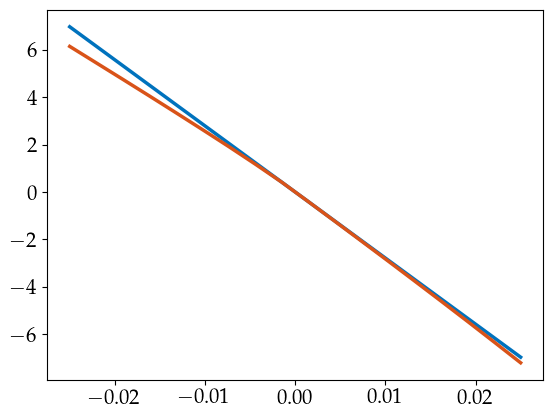

In [141]:
impact_pos = []
impact_neg = []
shock_list_bps = np.array([10000*shock for shock in shock_list])
shock_list_pp = np.array([100*shock for shock in shock_list])

for idx, shock in enumerate(shock_list):
    # impact_neg.append(irf_nonlin_neg_dict[idx]['C_BHAT'][0])
    impact_pos.append(100*irf_nonlin_pos_dict[idx]['C_BHAT'][0])

# plt.plot(shock_list, impact_neg)
# irf25 = hank.solve_impulse_linear(model_lin['baseline'], unknowns, targets, {'epsm': dr_nonlin})
plt.plot(shock_list, impact_linear)
plt.plot(shock_list, impact_pos)

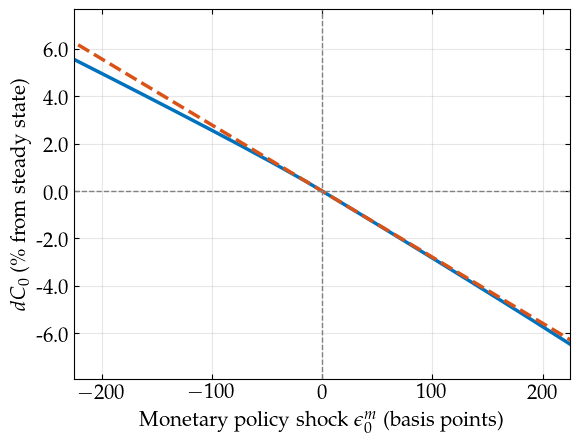

In [148]:
def different_shock_size(model_ss, impact_nonlin, impact_lin):
        
        fig, ax = plt.subplots()
        
        ax.plot(shock_list_bps, impact_nonlin/model_ss['C_BHAT'], 
                label=r'Non-linear')
        ax.plot(shock_list_bps, impact_lin/model_ss['C_BHAT'], 
                label=r'Linear', linestyle='--')
        ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax.axvline(x=0.0, color='grey', linestyle='--', linewidth=1.0)
        
        ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}'))
        # ax.xaxis.set_major_locator(MultipleLocator(2))
        ax.set_xlim(-225, 225)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel(r'Monetary policy shock $\epsilon_0^m$ (basis points)')
        ax.set_ylabel(r'$dC_0$ (\% from steady state)')
        # ax.legend(frameon=False)

        return fig

fig = different_shock_size(model_lin['baseline'], impact_pos, impact_linear)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'NonLinearVsLinDiffShock_v2.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

-0.016648617253085345


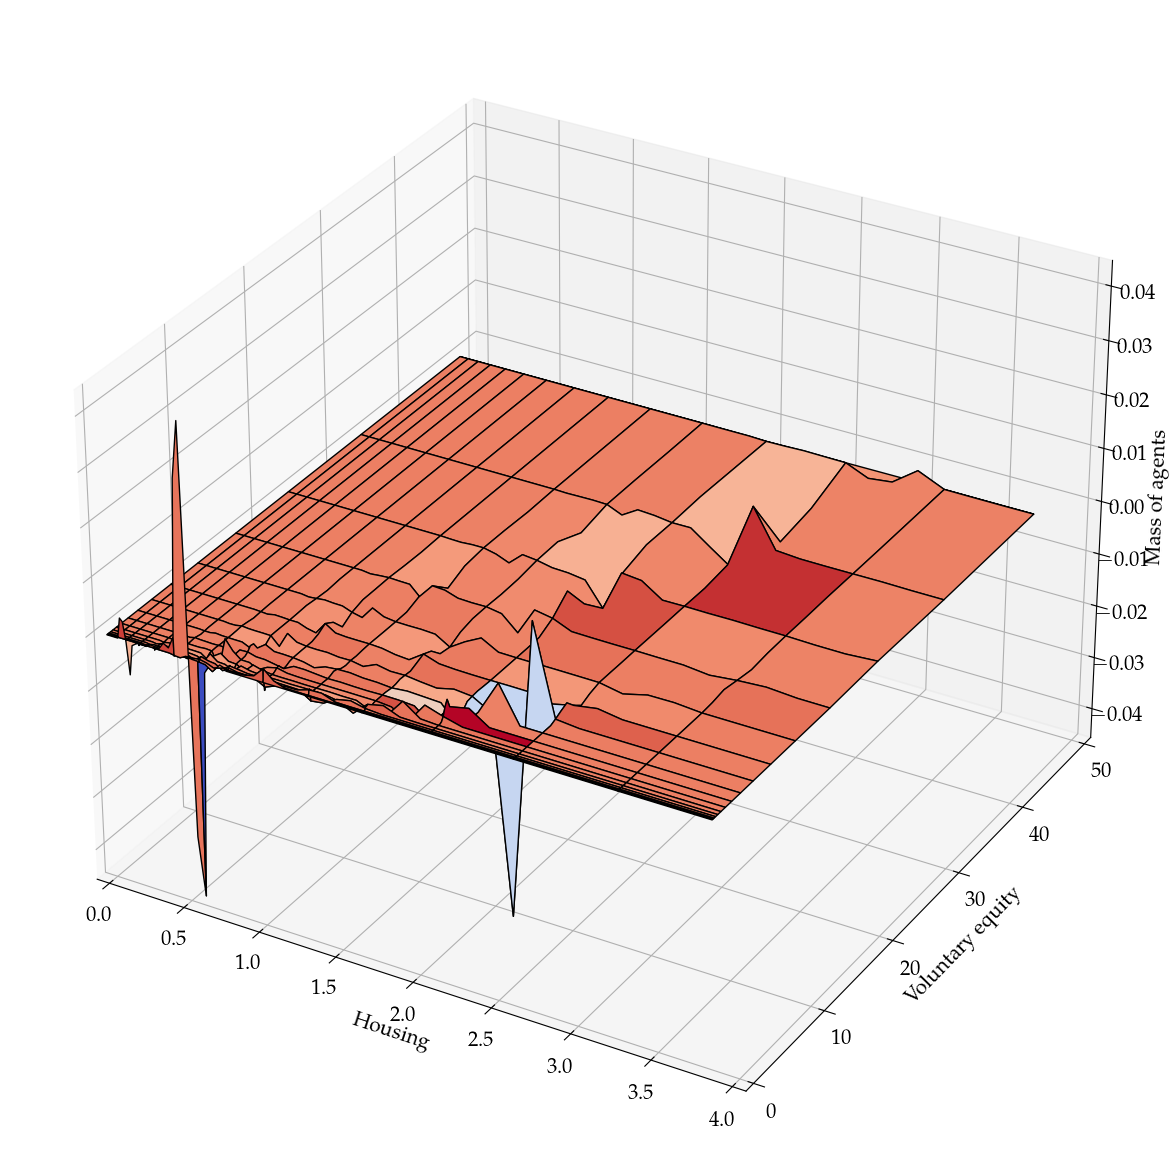

In [160]:
# c_dist = np.zeros((model_lin['baseline'].internals[hh_name]['c_bhat'].shape))
# print(c_dist.shape)

def get_distribution(model_ss, irf, hh_name):
    c_dist = np.zeros((irf.internals[hh_name]['c_bhat'].shape))
    h_dist = np.zeros((irf.internals[hh_name]['c_bhat'].shape))
    b_dist = np.zeros((irf.internals[hh_name]['c_bhat'].shape))
    dist = np.zeros((irf.internals[hh_name]['c_bhat'].shape))
    dist_beg = np.zeros((irf.internals[hh_name]['c_bhat'].shape))
    for t in range(T):
        dist[t] = (model_ss.internals[hh_name]['D'] + irf.internals[hh_name]['D'][t])
        dist_beg[t] = (model_ss.internals[hh_name]['Dbeg'] + irf.internals[hh_name]['Dbeg'][t])
        c_dist[t] = (model_ss.internals[hh_name]['D'] + irf.internals[hh_name]['D'][t]) \
                  * (model_ss.internals[hh_name]['c_bhat'] + irf.internals[hh_name]['c_bhat'][t])
        h_dist[t] = (model_ss.internals[hh_name]['D'] + irf.internals[hh_name]['D'][t]) \
            * (model_ss.internals[hh_name]['h_bhat'] + irf.internals[hh_name]['h_bhat'][t])
        b_dist[t] = (model_ss.internals[hh_name]['D'] + irf.internals[hh_name]['D'][t]) \
            * (model_ss.internals[hh_name]['h_bhat'] + irf.internals[hh_name]['h_bhat'][t])
    return c_dist, h_dist, b_dist, dist, dist_beg

c_dist, h_dist, b_dist, dist, dist_beg = get_distribution(model_lin['baseline'], irf_nonlin['pos_100bps'], hh_name)
c_dist_ss = model_lin['baseline'].internals[hh_name]['D']*model_lin['baseline'].internals[hh_name]['c_bhat']

c_dist_bmarg = np.sum(c_dist, axis = (1,3))
c_dist_ss_bmarg = np.sum(c_dist_ss, axis = (0,2))

plots.plot_c_dist(model_lin['baseline'], c_dist, 1, hh_name, 'c_bhat', z_plot = None, dev_ss = True)

In [165]:
from copy import deepcopy
dtheta = np.zeros(T)
sig_theta = 0.03
rho_theta = 0.65
dtheta = sig_theta * rho_theta**np.arange(T)

irf_nonlin['theta_shock'] = hank.solve_impulse_nonlinear(model_lin['baseline'], unknowns, targets, {'theta': dtheta},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

_, _, _, _, dist_beg = get_distribution(model_lin['baseline'], irf_nonlin['theta_shock'], hh_name)

model_lin['theta_dist'] = deepcopy(model_lin['baseline'])
model_lin['theta_dist'].internals[hh_name]['Dbeg'] = dist_beg[1]
model_lin['theta_dist'].internals[hh_name]['D'] = dist_beg[1]

In [187]:
irf_nonlin['state_dep_shock'] = hank.solve_impulse_nonlinear(ss_lin['baseline'], unknowns, targets, {'epsm': dtheta},
                                                 internals = {hh_name}, verbose = True, options={'taylor': {'verbose': False}},
                                                 ss_initial=ss_lin['highwealth'], maxit = 200)

Solving Housing HANK for ['pi', 'w', 'N', 'qh'] to hit ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']


ValueError: max() arg is an empty sequence

(6, 50, 70)
(50, 70)


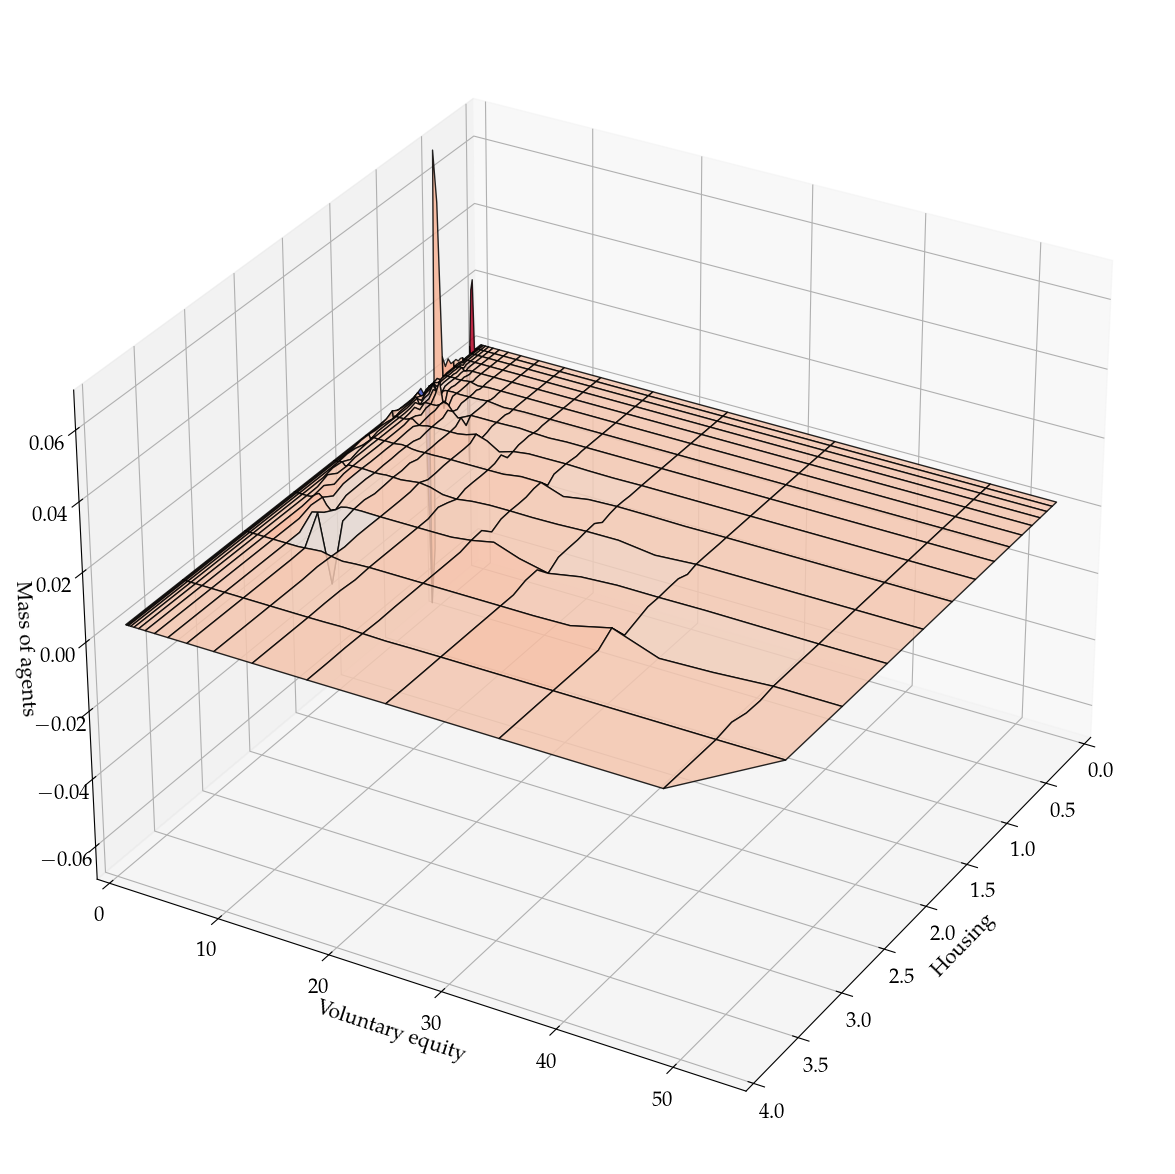

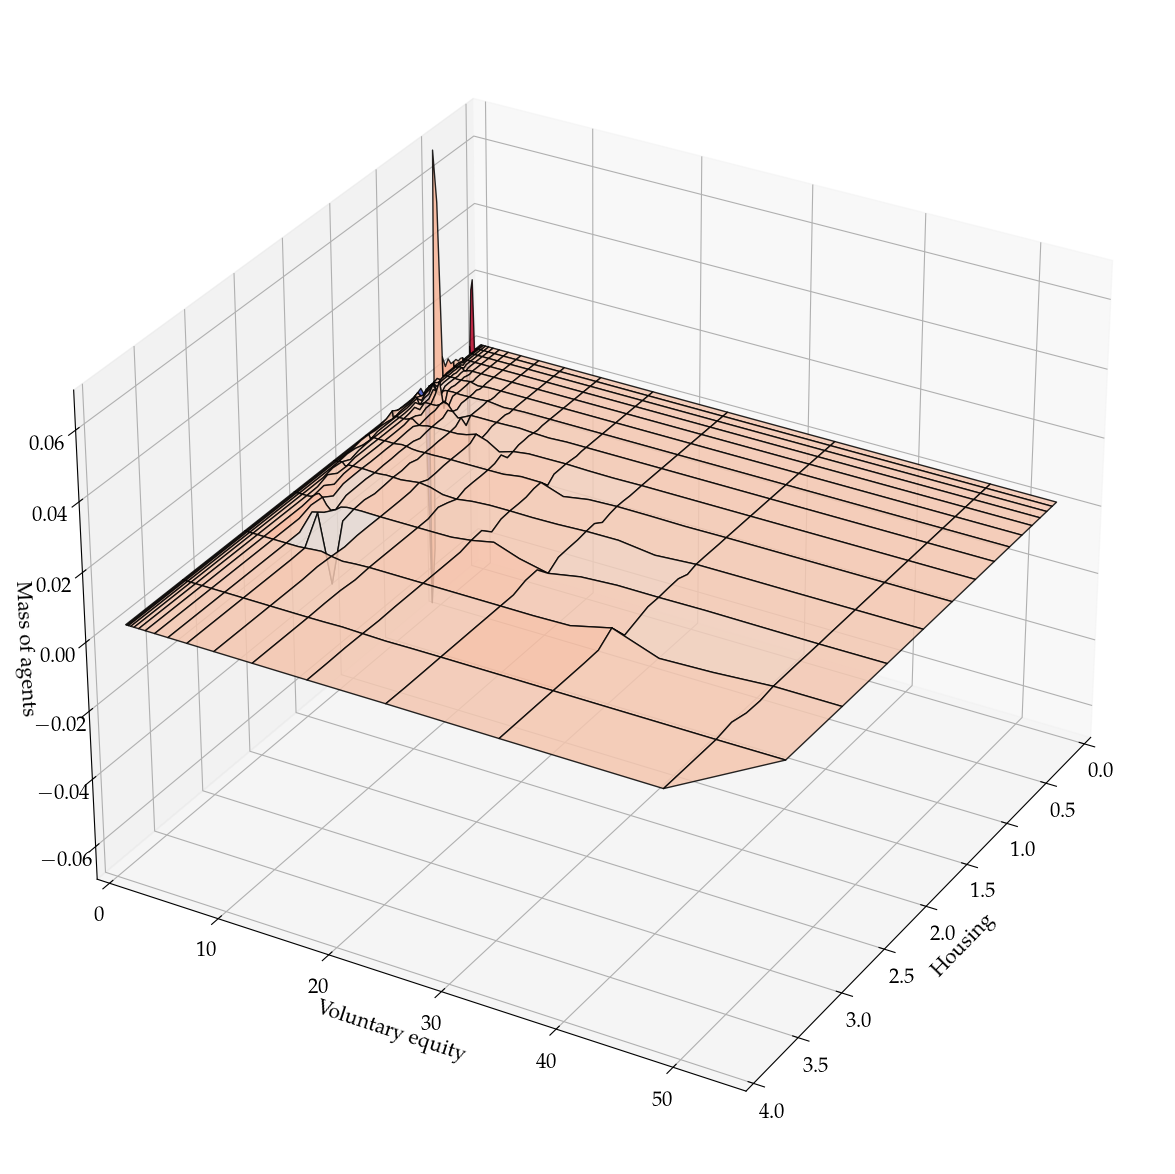

In [164]:
def distribution_3d(model_ss, dist, hh_name, dev_ss = False):
    XX, YY = np.meshgrid(model_ss.internals[hh_name]['h_bhat_grid'],model_ss.internals[hh_name]['b_bhat_grid'])

    if dev_ss:
        dist = dist - model_ss.internals[hh_name]['D']
    else:
        dist = dist
    bdmargdist = np.sum(dist, axis=0)
    print(bdmargdist.shape)
    b_lim = 55
    h_lim = 4
    bdmargdist[model_ss.internals[hh_name]['b_bhat_grid'] > b_lim] = np.nan
    bdmargdist[:,model_ss.internals[hh_name]['h_bhat_grid'] > h_lim] = np.nan

    fig = plt.figure(figsize=(12, 16))
    ax = fig.add_subplot(111, projection='3d')
    surf2 = ax.plot_surface(XX, YY, bdmargdist, cmap='coolwarm', alpha=0.85, label = ' z = 0',
                            edgecolor='k', rcount = 20, ccount = 20)
    ax.set_xlabel('Housing')
    ax.set_ylabel('Voluntary equity')
    ax.set_zlabel('Mass of agents')
    ax.set_xlim(0, h_lim)
    ax.set_ylim(0, b_lim)
    ax.view_init(elev=30, azim=30)

    fig.tight_layout()
    plt.show()

    return fig

print(dist[0].shape)
distribution_3d(model_lin['baseline'], dist_beg[1], hh_name, dev_ss = True)


-8.385186797888441e-07
2.2896703403861536e-12 2.305413848527892e-12
217520.61855514284 216005.51756396113
0.9990236472755358 0.9990244857942155
0.9931710707160922


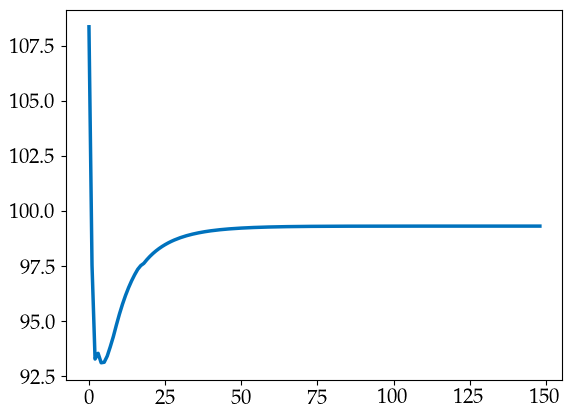

In [451]:
def c_inequality(model_ss, irf, hh_name):
    T = len(irf['C_BHAT'])
    var_c = np.zeros(T)

    c_dist_ss = model_ss.internals[hh_name]['D'] * model_ss.internals[hh_name]['c_bhat']
    c_dist_ss = np.where(c_dist_ss != 0, c_dist_ss, np.nan)

    log_c_dist_ss = np.log(100 + c_dist_ss)
    for t in range(T):
        c_dist = (model_ss.internals[hh_name]['D'] + irf.internals[hh_name]['D'][t]) \
               * (model_ss.internals[hh_name]['c_bhat'] + irf.internals[hh_name]['c_bhat'][t])
        
        c_dist = np.where(c_dist != 0, c_dist, np.nan)
        log_c_dist = np.log(100 + c_dist)
        # var_c[t] = (np.nanvar(log_c_dist) - np.nanvar(log_c_dist_ss))
        var_c[t] = (np.nanvar(log_c_dist))/np.nanvar(log_c_dist_ss)
    print(np.nansum(c_dist - c_dist_ss))
    print(np.nanvar(log_c_dist), np.nanvar(log_c_dist_ss))
    print(np.nansum(log_c_dist), np.nansum(log_c_dist_ss))
    print(np.nansum(c_dist), np.nansum(c_dist_ss))
    return var_c

var_c = c_inequality(model_lin['baseline'], irf_nonlin['neg_100bps'], hh_name)

plt.plot(100*var_c[:149])
print(np.sum(var_c[149]))

In [188]:
# compare the response of linear vs nonlinear solution for expansionary shocks
irf_lin['neg_100bps'] = hank.solve_impulse_linear(model_lin['baseline'], unknowns, targets, {'epsm': -dr_nonlin_large})

In [518]:
blocks_decomp = [hh2, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
                 utils.mkt_clearing_decomp, utils.nkpc, utils.qhouse_lag_decomp, utils.gamma_prime]

hank_decomp = create_model(blocks_decomp, name="Housing HANK")
model_lin['no_colcons'] = hank_decomp.steady_state(ss_lin['baseline'])

irf_lin['no_colcons'] = hank_decomp.solve_impulse_linear(model_lin['no_colcons'], unknowns, targets, {'epsm': dr})

In [73]:
print(np.sum(100*(irf_lin['baseline']['C_BHAT'][0] - irf_lin['no_colcons']['C_BHAT'][0])/model_lin['baseline']['C_BHAT']))
print(f"Impact consumption effect: {100*irf_lin['baseline']['C_BHAT'][0]/model_lin['baseline']['C_BHAT']:.1f}")
print(f"Impact consumption effect: {100*irf_lin['baseline']['qh'][0]/model_lin['baseline']['qh']:.1f}")

-0.14065240303468002
Impact consumption effect: -0.8
Impact consumption effect: -0.9


In [173]:
dr_nonlin = np.zeros(T)
sig_r_nonlin = 0.0029 # 0.01
dr_nonlin[0] = sig_r_nonlin

dr_nonlin_large = np.zeros(T)
sig_r_nonlin_large = 0.01
dr_nonlin_large[0] = sig_r_nonlin_large

model_lin['noborrow']['rhom'] = 0.95
model_lin['baseline']['rhom'] = 0.95
irf_nonlin['neg_noborr'] = hank.solve_impulse_nonlinear(model_lin['baseline'], unknowns, targets, {'epsm': -dr_nonlin_large},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})
irf_nonlin['pos_noborr'] = hank.solve_impulse_nonlinear(model_lin['baseline'], unknowns, targets, {'epsm': dr_nonlin_large},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})
model_lin['baseline']['rhom'] = 0.73

In [209]:
model_lin['baseline']['rhom'] = 0.73

sig_theta = 0.02
rho_theta = 0.95
dtheta = sig_theta * rho_theta ** np.arange(T)

irf_nonlin['theta_plus_epsm'] = hank.solve_impulse_nonlinear(model_lin['baseline'], unknowns, targets, {'theta': dtheta, 'epsm': dr},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

irf_nonlin['theta'] = hank.solve_impulse_nonlinear(model_lin['baseline'], unknowns, targets, {'theta': dtheta},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

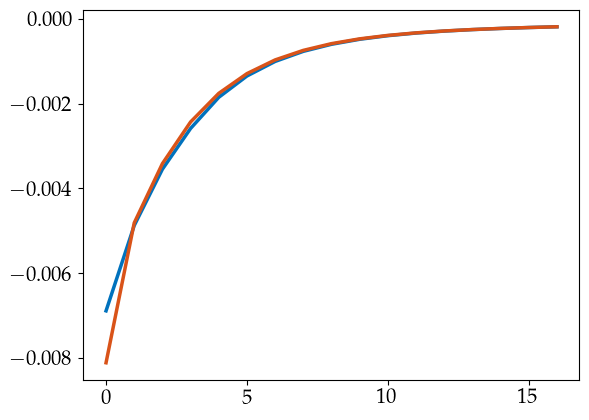

In [211]:
plt.plot(irf_nonlin['theta_plus_epsm']['C_BHAT'][:H] - irf_nonlin['theta']['C_BHAT'][:H])
plt.plot(irf_nonlin['pos']['C_BHAT'][:H])

## The effects of LTV-shocks

In [188]:
cali_lowltv = cali_main.copy()
cali_lowltv['gamma'] = 0.85
# cali_lowltv['sigma_z'] = 0.92 #0.6
# cali_lowltv['nB'] = 70
# cali_lowltv['nZ'] = 11
# cali_lowltv['bmax'] = 200 #90
# cali_lowltv['hmax'] = 20

ss_lin['ltv_baseline'] = hank_ss.solve_steady_state(cali_lowltv, unknowns_ss, targets_ss, solver="hybr")
model_lin['ltv_baseline'] = hank.steady_state(ss_lin['ltv_baseline'])

c:\Users\thoma\OneDrive\Skrivebord\KU\9. semester\Thesis\Code\Model\HANK\sequence-jacobian\notebooks\hh_housing_v3.py:260: RuntimeWarning: invalid value encountered in power


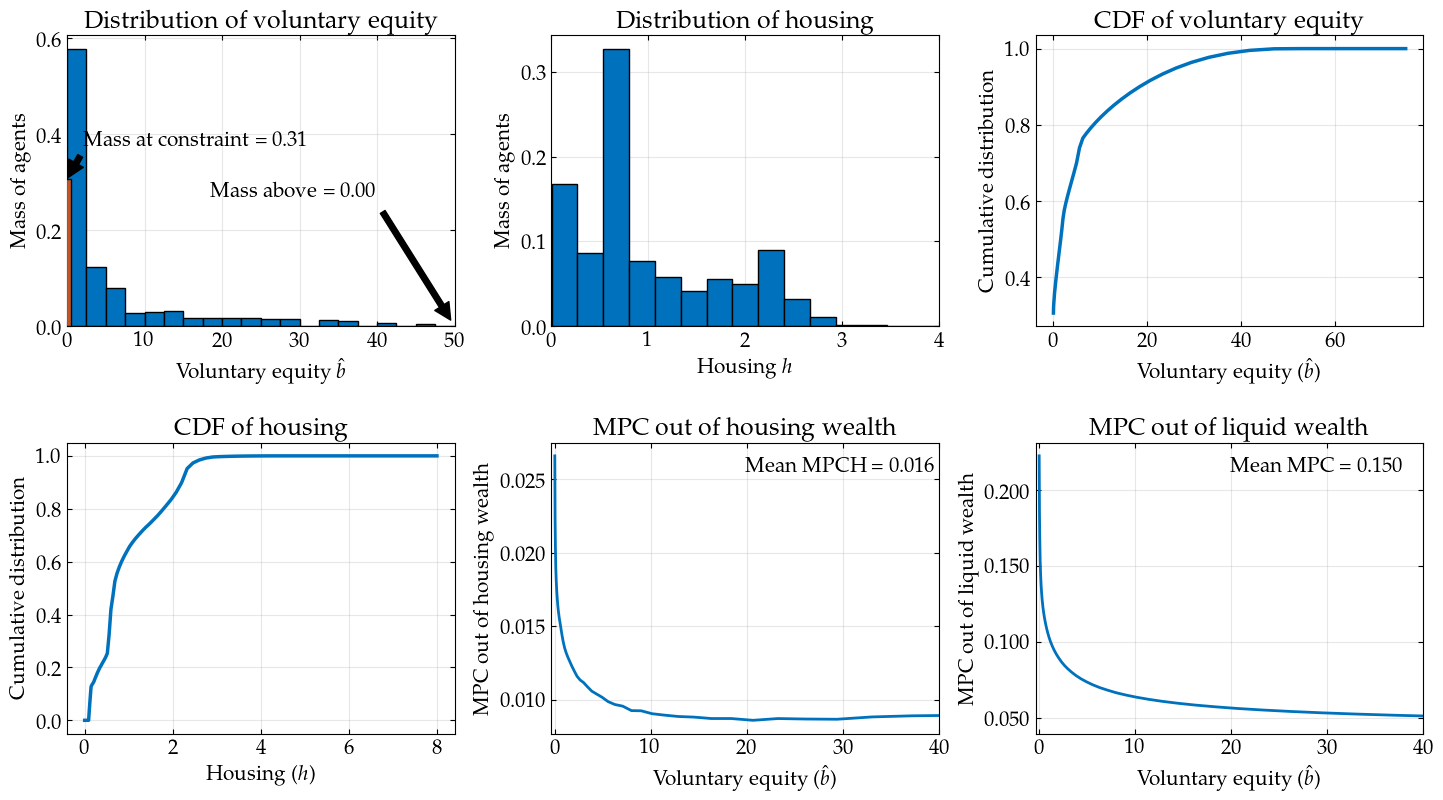

In [90]:
fig = plots.steady_state_dist(model_lin['ltv_baseline'], hh_name)

In [96]:
def consumption_decomp_ltv(Js, irfs, hh_name, do_assert = True):
    # empty namespace to store decompositions
    decomp = SimpleNamespace()

    # empty dictionary to store decompositions
    decomp_dict = {}
    
    # input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'r_opp', 'qh_col', 'gamma', 'gamma_p']
    input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p', 'r_opp', 'qh_col']
    for k in input_list_decomp:
        setattr(decomp, f'dC_d{k}', Js[hh_name]['C_BHAT'][k] @ irfs[k])

    # print(type(decomp))
    decomp_dict = vars(decomp)

    tot_response = 0

    for (key, value) in decomp_dict.items():
        tot_response += value

    decomp_dict['housing'] = decomp.dC_dqh #+ decomp.dC_dqh_lag
    decomp_dict['indirect'] = decomp.dC_dN + decomp.dC_dTax + decomp.dC_dDiv + decomp.dC_dw
    decomp_dict['direct'] = decomp.dC_dr + decomp.dC_dr_opp
    decomp_dict['collateral'] = decomp.dC_dqh_lag + decomp.dC_dqh_col + decomp.dC_dgamma + decomp.dC_dgamma_p
    decomp_dict['total'] = tot_response

    if do_assert:
        assert np.allclose(decomp_dict['total'], irfs['C_BHAT']), f"Total response does not match the IRF"

    return decomp_dict

In [94]:
sig_gamma = 0.1
rho_gamma = 0.95
T_gam = 300
dgamma = sig_gamma * rho_gamma ** np.arange(T_gam)

irf_ltv_shock = {}

# model_lin['ltv_baseline']['phi'] = 1.27 #1.01
# model_lin['ltv_baseline']['rhom'] = 0.73 #0
irf_ltv_shock['neg_rho95'] = hank.solve_impulse_nonlinear(model_lin['ltv_baseline'], unknowns, targets, {'gamma': -dgamma},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})
irf_ltv_shock['pos_rho95'] = hank.solve_impulse_nonlinear(model_lin['ltv_baseline'], unknowns, targets, {'gamma': dgamma},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

sig_gamma = 0.1
rho_gamma = 0.6
T_gam = 300
dgamma = sig_gamma * rho_gamma ** np.arange(T_gam)

irf_ltv_shock['neg_rho60'] = hank.solve_impulse_nonlinear(model_lin['ltv_baseline'], unknowns, targets, {'gamma': -dgamma},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})
irf_ltv_shock['pos_rho60'] = hank.solve_impulse_nonlinear(model_lin['ltv_baseline'], unknowns, targets, {'gamma': dgamma},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

In [ ]:
ltv_decomp = {}
sig_gamma = 0.1
rho_gamma = 0.60
T_gam = 300
dgamma = sig_gamma * rho_gamma ** np.arange(T_gam)

irf_lin['neg_rho60'] = hank.solve_impulse_linear(model_lin['ltv_baseline'], unknowns, targets, {'gamma': -dgamma})
CurlyJs['ltv_baseline'] = {hh_name: hh2.jacobian(model_lin['ltv_baseline'], inputs=input_list, outputs=output_list, T=T_gam)}
ltv_decomp['neg_rho60'] = consumption_decomp_ltv(CurlyJs['ltv_baseline'], irf_lin['neg_rho60'], hh_name, do_assert = False)

sig_gamma = 0.1
rho_gamma = 0.95
T_gam = 300
dgamma_95 = sig_gamma * rho_gamma ** np.arange(T_gam)
irf_lin['neg_rho95'] = hank.solve_impulse_linear(model_lin['ltv_baseline'], unknowns, targets, {'gamma': -dgamma_95})
# CurlyJs['ltv_baseline'] = {hh_name: hh2.jacobian(model_lin['ltv_baseline'], inputs=input_list, outputs=output_list, T=T_gam)}
ltv_decomp['neg_rho95'] = consumption_decomp_ltv(CurlyJs['ltv_baseline'], irf_lin['neg_rho95'], hh_name, do_assert = False)

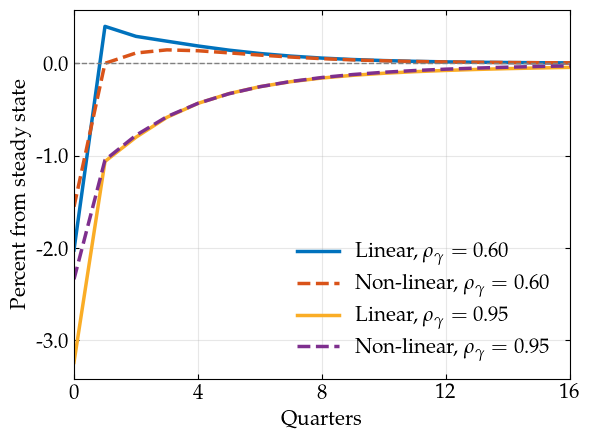

In [115]:
fig = plots.linear_nonlinear_ltv(model_lin, irf_lin, irf_ltv_shock)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'LinearVsNonLinearLTV_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

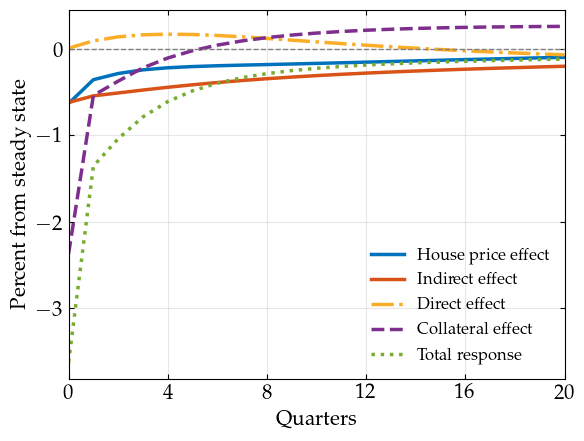

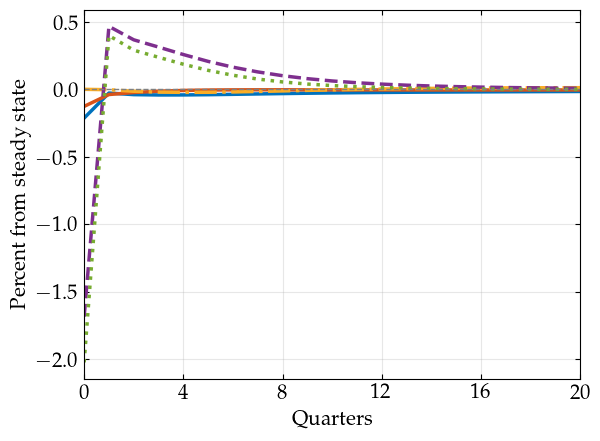

In [119]:
fig = plot_decomp_single(ltv_decomp['neg_rho95'], model_lin['ltv_baseline'], H = 21)
save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'CDecompLTV_rho95_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

fig = plot_decomp_single(ltv_decomp['neg_rho60'], model_lin['ltv_baseline'], H = 21, legend=False)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'CDecompLTV_rho60_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

In [193]:
cali_lowltv = cali_main.copy()
cali_lowltv['gamma'] = 0.85

ss_lin['lowltv'] = hank_ss.solve_steady_state(cali_lowltv, unknowns_ss, targets_ss, solver="hybr")
model_lin['lowltv'] = hank.steady_state(ss_lin['lowltv'])

In [ ]:
gamma_shock_perm = hank.solve_impulse_nonlinear(model_lin['lowltv'], unknowns, targets, {'epsm': np.full(T_gam, 0)},
                                                 internals = {hh_name}, verbose = True, options={'taylor': {'verbose': False}},
                                                 ss_initial=model_lin['baseline'], maxit = 200)

Solving Housing HANK for ['pi', 'w', 'N', 'qh'] to hit ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']


ValueError: max() arg is an empty sequence

### Distribution stuff

In [163]:
C_BHAT = fast_aggregate(model_lin['ltv_baseline'].internals[hh_name]['D'] + irf_ltv_shock['neg_rho60'].internals[hh_name]['D'],
                        model_lin['ltv_baseline'].internals[hh_name]['c_bhat'] + irf_ltv_shock['neg_rho60'].internals[hh_name]['c_bhat'])

C_BHAT = C_BHAT - model_lin['ltv_baseline']['C_BHAT']

In [166]:
c_dist_ss = model_lin['ltv_baseline'].internals[hh_name]['D'] * model_lin['ltv_baseline'].internals[hh_name]['c_bhat']
print(c_dist_ss.shape)
print(np.sum(c_dist_ss))
print(model_lin['ltv_baseline']['C_BHAT'] - np.sum(c_dist_ss))

(6, 50, 70)
0.9990683219396553
-1.1102230246251565e-16


In [204]:
t = 299
c_dist_ss = model_lin['ltv_baseline'].internals[hh_name]['D'] * model_lin['ltv_baseline'].internals[hh_name]['c_bhat']

c_dist = (model_lin['ltv_baseline'].internals[hh_name]['D'] + irf_ltv_shock['neg_rho60'].internals[hh_name]['D'][t]) \
       * (model_lin['ltv_baseline'].internals[hh_name]['c_bhat'] + irf_ltv_shock['neg_rho60'].internals[hh_name]['c_bhat'][t])

c_dist = c_dist - c_dist_ss

c_dist_fast = fast_aggregate(model_lin['ltv_baseline'].internals[hh_name]['D'] + irf_ltv_shock['neg_rho60'].internals[hh_name]['D'],
                             model_lin['ltv_baseline'].internals[hh_name]['c_bhat'] + irf_ltv_shock['neg_rho60'].internals[hh_name]['c_bhat'])
c_dist_fast = c_dist_fast - model_lin['ltv_baseline']['C_BHAT']

print(np.sum(c_dist))
print(c_dist.shape)
print(f"C_BHAT: {C_BHAT[t]}, c_dist: {np.sum(c_dist)}, c_dist_fast: {c_dist_fast[t]}")
print(f"Aggregation error: {C_BHAT[t] - np.sum(c_dist)}")
print(f"Aggregation error: {np.sum(c_dist) - c_dist_fast[t]}")

1.049409867539483e-09
(6, 50, 70)
C_BHAT: 1.0494098923174988e-09, c_dist: 1.049409867539483e-09, c_dist_fast: 1.0494098923174988e-09
Aggregation error: 2.477801575083302e-17
Aggregation error: -2.477801575083302e-17


In [187]:
c_dist_ss_with_nan = np.where(c_dist_ss == 0, np.nan, c_dist_ss)
print(np.nansum(c_dist_ss_with_nan))
print(np.sum(c_dist_ss))
log_c_dist_ss = np.log(c_dist_ss_with_nan)
print(np.sum(log_c_dist_ss))

0.9990683219396553
0.9990683219396553
nan


1.049409867539483e-09


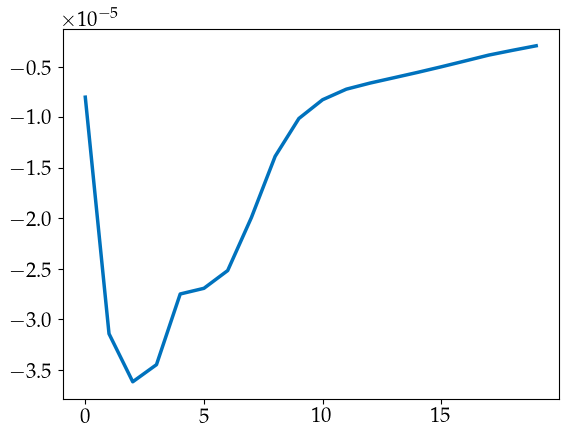

In [203]:
def c_inequality(model_ss, irf, hh_name):
    T = len(irf['C_BHAT'])
    var_c = np.zeros(T)

    c_dist_ss = model_ss.internals[hh_name]['D'] * model_ss.internals[hh_name]['c_bhat']
    c_dist_ss = np.where(c_dist_ss != 0, c_dist_ss, np.nan)

    log_c_dist_ss = np.log(1 + c_dist_ss)
    for t in range(T):
        c_dist = (model_ss.internals[hh_name]['D'] + irf.internals[hh_name]['D'][t]) \
               * (model_ss.internals[hh_name]['c_bhat'] + irf.internals[hh_name]['c_bhat'][t])
        
        c_dist = np.where(c_dist != 0, c_dist, np.nan)
        log_c_dist = np.log(1+ c_dist)
        var_c[t] = np.nanvar(log_c_dist) - np.nanvar(log_c_dist_ss)
    print(np.nansum(c_dist - c_dist_ss))
    return var_c

var_c = c_inequality(model_lin['ltv_baseline'], irf_ltv_shock['neg_rho60'], hh_name)

plt.plot(100*var_c[:20])

In [205]:
print(np.nanvar(log_c_dist_ss))

4204.153854336777


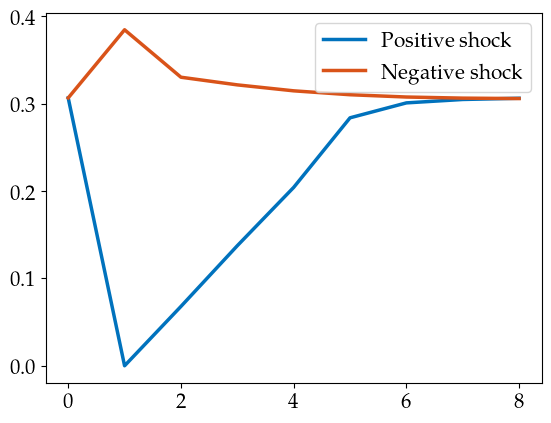

In [45]:
irf_ltv_shock['neg_rho60'].internals[hh_name]['c_bhat'].shape

constrained_share_pos = []
constrained_share_neg = []
fig, ax = plt.subplots()
H = 9
for t in range(T):
    bmarg_pos = np.sum(model_lin['ltv_baseline'].internals[hh_name]['D'] + irf_ltv_shock['pos_rho60'].internals[hh_name]['D'][t], axis = (0,2))
    cons_share = bmarg_pos[0]
    constrained_share_pos.append(cons_share)

    bmarg_neg = np.sum(model_lin['ltv_baseline'].internals[hh_name]['D'] + irf_ltv_shock['neg_rho60'].internals[hh_name]['D'][t], axis = (0,2))
    cons_share = bmarg_neg[0]
    constrained_share_neg.append(cons_share)

ax.plot(constrained_share_pos[:H], label='Positive shock')
ax.plot(constrained_share_neg[:H], label='Negative shock')
ax.legend()

In [20]:
def consumption_decomp_ltv(Js, irfs, hh_name, do_assert = True):
    # empty namespace to store decompositions
    decomp = SimpleNamespace()

    # empty dictionary to store decompositions
    decomp_dict = {}
    
    # input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'r_opp', 'qh_col', 'gamma', 'gamma_p']
    input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p', 'r_opp', 'qh_col']
    for k in input_list_decomp:
        setattr(decomp, f'dC_d{k}', Js[hh_name]['C_BHAT'][k] @ irfs[k])

    # print(type(decomp))
    decomp_dict = vars(decomp)

    tot_response = 0

    for (key, value) in decomp_dict.items():
        tot_response += value

    decomp_dict['housing'] = decomp.dC_dqh #+ decomp.dC_dqh_lag
    decomp_dict['indirect'] = decomp.dC_dN + decomp.dC_dTax + decomp.dC_dDiv + decomp.dC_dw
    decomp_dict['direct'] = decomp.dC_dr + decomp.dC_dr_opp
    decomp_dict['collateral'] = decomp.dC_dqh_lag + decomp.dC_dqh_col + decomp.dC_dgamma + decomp.dC_dgamma_p
    decomp_dict['total'] = tot_response

    if do_assert:
        assert np.allclose(decomp_dict['total'], irfs['C_BHAT']), f"Total response does not match the IRF"

    return decomp_dict

In [92]:
sig_gamma = 0.1
rho_gamma = 0.60
T_gam = 300
dgamma = sig_gamma * rho_gamma ** np.arange(T_gam)

irf_lin['ltv_baseline'] = hank.solve_impulse_linear(model_lin['ltv_baseline'], unknowns, targets, {'gamma': -dgamma})
CurlyJs['ltv_baseline'] = {hh_name: hh2.jacobian(model_lin['ltv_baseline'], inputs=input_list, outputs=output_list, T=T_gam)}

sig_gamma = 0.1
rho_gamma = 0.95
T_gam = 300
dgamma_95 = sig_gamma * rho_gamma ** np.arange(T_gam)
irf_lin['ltv_95'] = hank.solve_impulse_linear(model_lin['ltv_baseline'], unknowns, targets, {'gamma': -dgamma_95})

KeyboardInterrupt: 

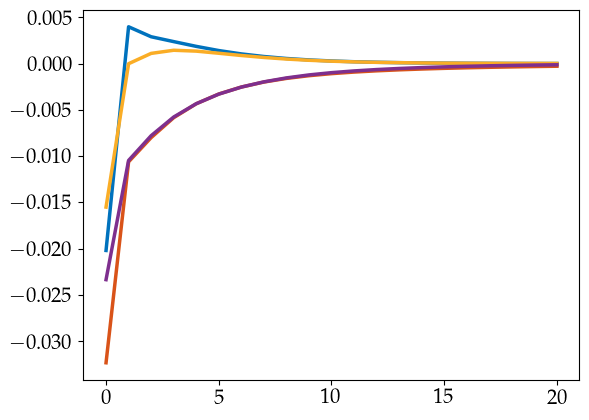

In [42]:
# plt.plot(CurlyJs['ltv_baseline'][hh_name]['C_BHAT']['gamma'][:,0])
plt.plot(irf_lin['ltv_baseline']['C_BHAT'][:21])
plt.plot(irf_lin['ltv_95']['C_BHAT'][:21])
plt.plot(irf_ltv_shock['neg_rho60']['C_BHAT'][:21])
plt.plot(irf_ltv_shock['neg_rho95']['C_BHAT'][:21])

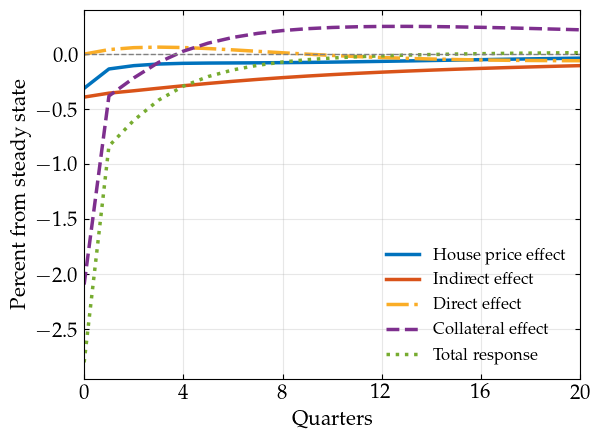

In [44]:
ltv_decomp = consumption_decomp_ltv(CurlyJs['ltv_baseline'], irf_ltv_shock['neg_rho95'], hh_name, do_assert = False)
fig = plot_decomp_single(ltv_decomp, model_lin['ltv_baseline'], H = 21)

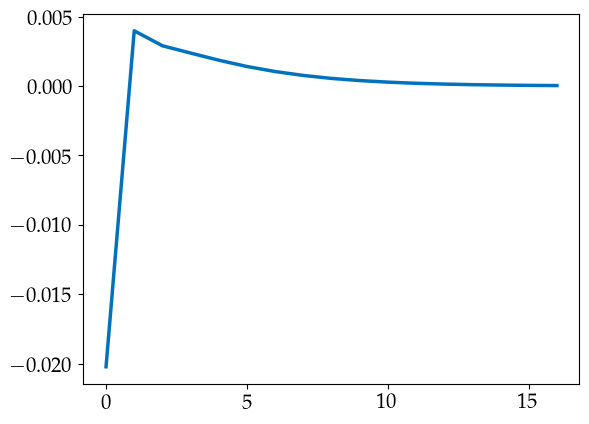

In [328]:
plt.plot(irf_lin['ltv_baseline']['C_BHAT'][:H])

In [156]:
print(-irf_ltv_shock['neg_rho95']['C_BHAT'][0]/irf_ltv_shock['pos_rho95']['C_BHAT'][0])

2.00824987554906


## Plots

### Steady state

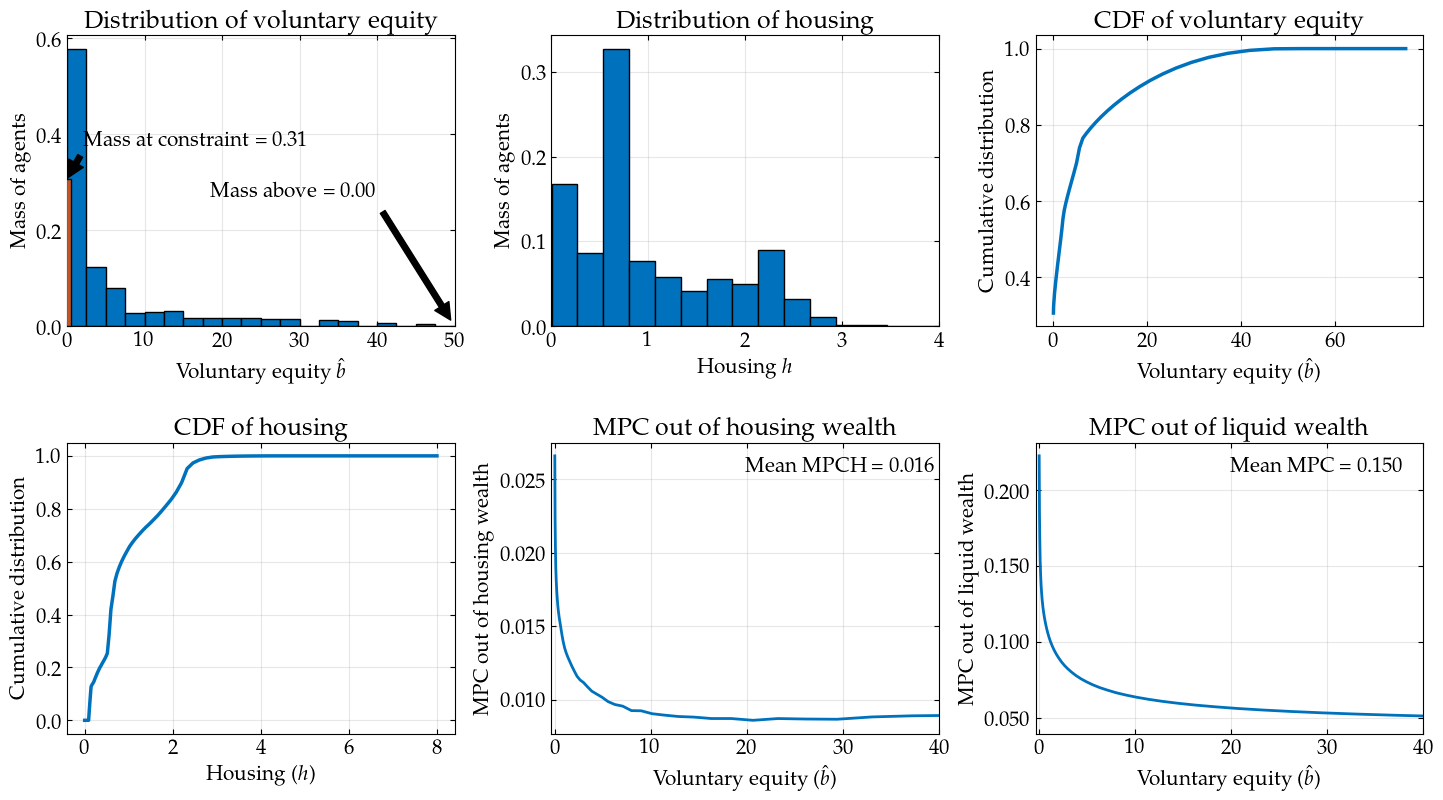

In [86]:
fig = plots.steady_state_dist(model_lin['baseline'], hh_name)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'SteadyStateDist_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

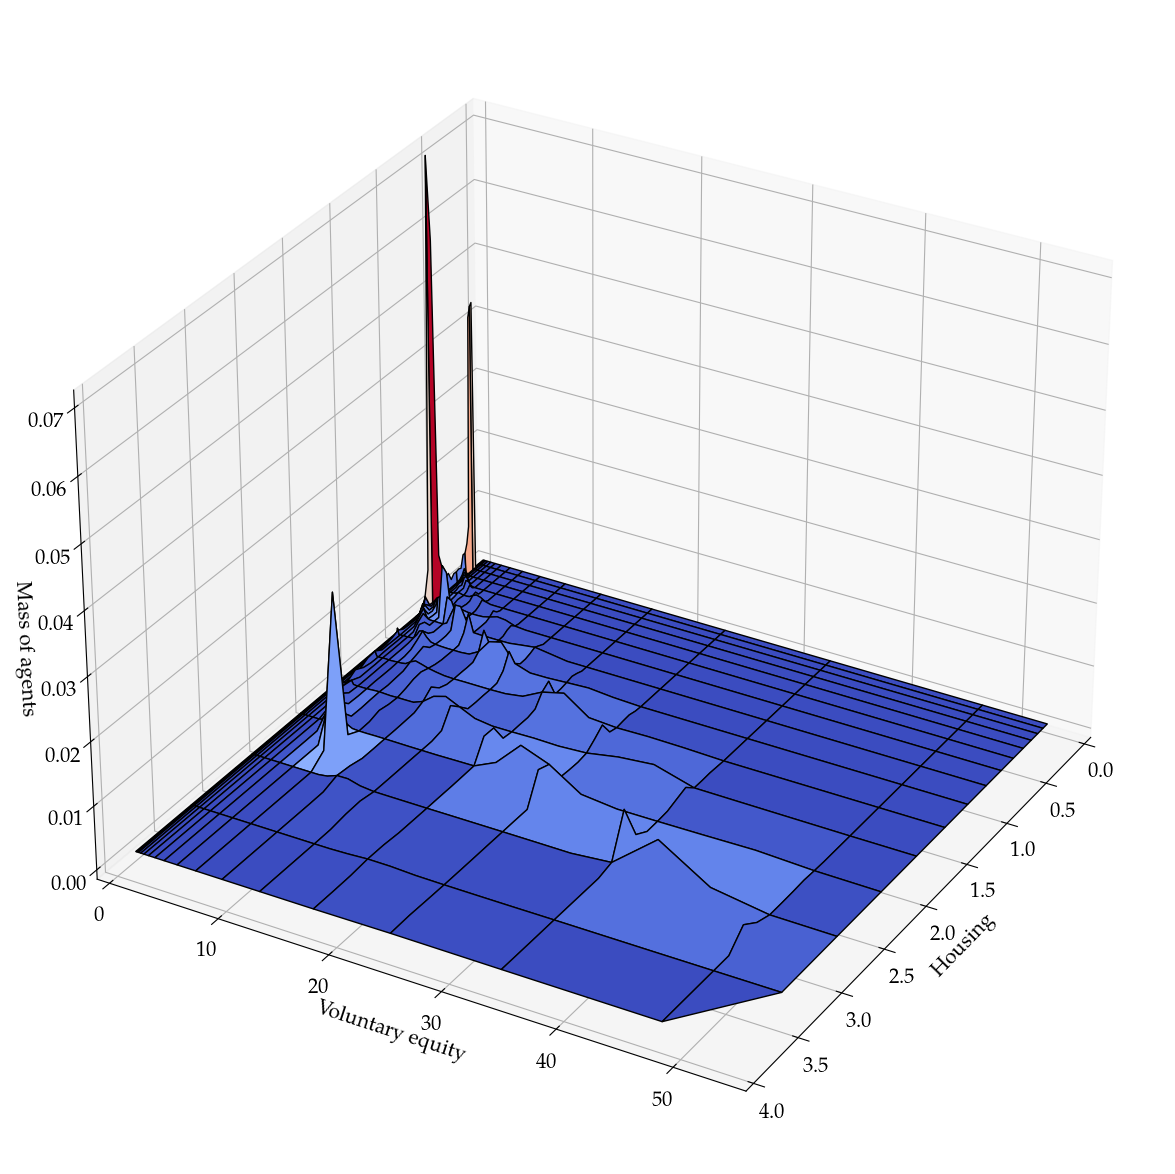

In [87]:
fig = plots.bh_distribution_3d(model_lin['baseline'], hh_name)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'BH_SteadyStateDist_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

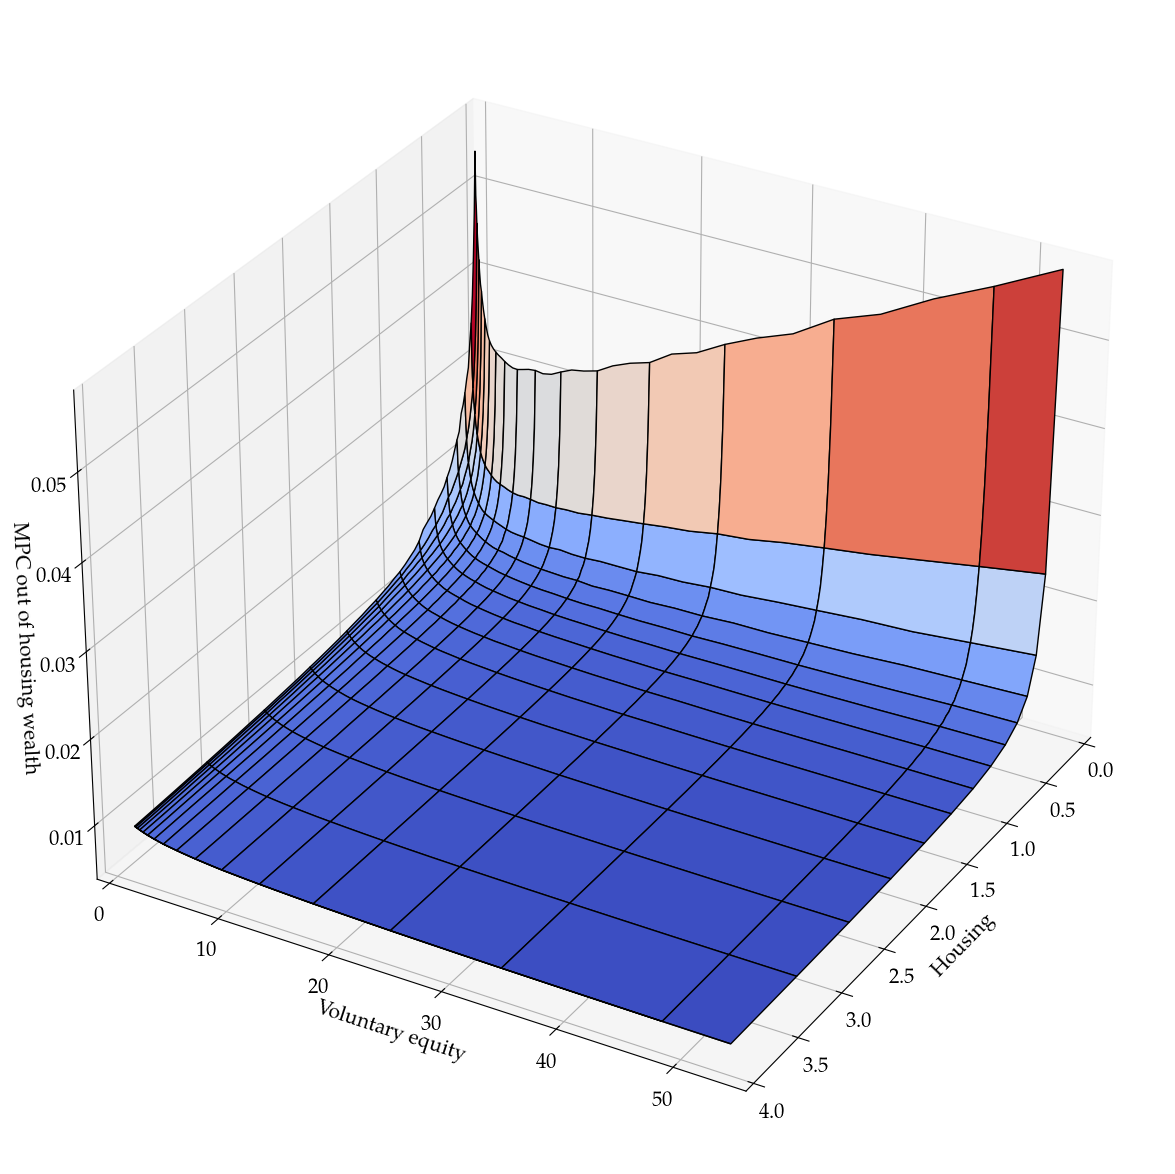

In [196]:
fig = plots.mpch_dist(model_lin['baseline'], hh_name, b_plot_start=3)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'MPCH_dist_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Baseline calibration

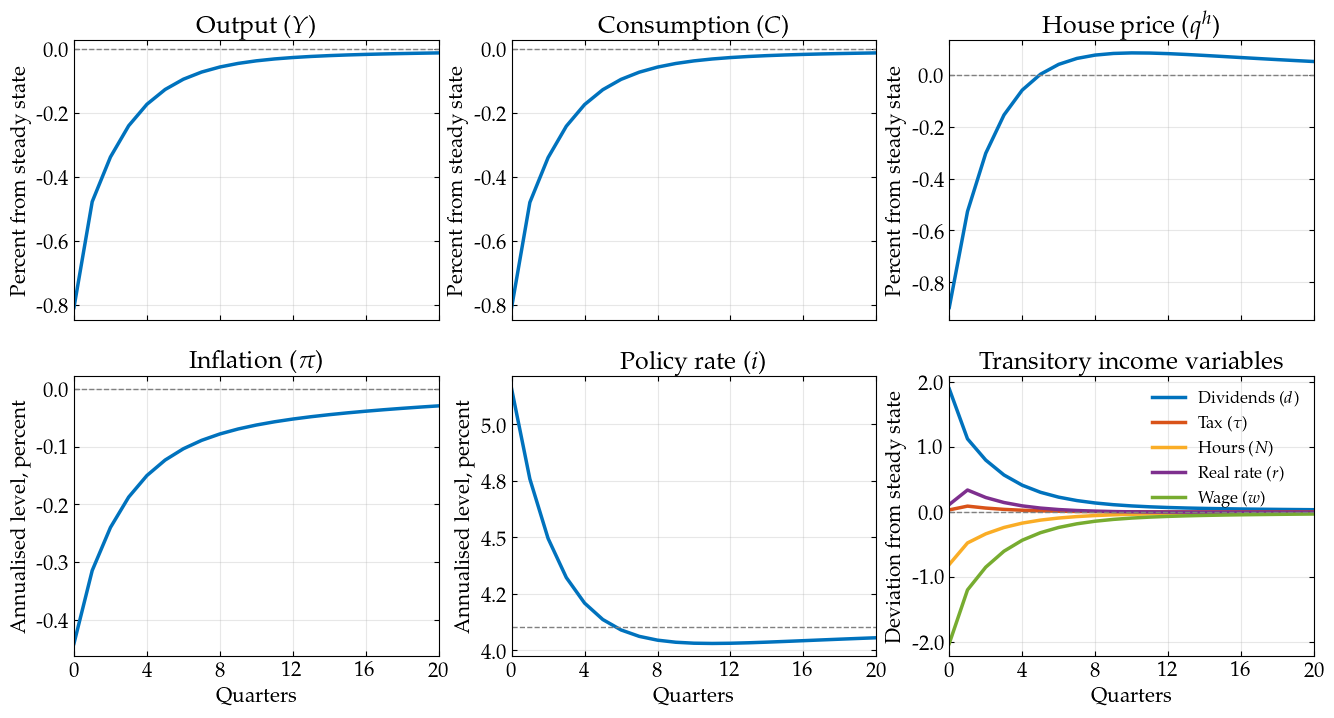

In [ ]:
fig = plots.linear_irf_baseline(irf_lin['baseline'], model_lin['baseline'], H = 21)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'linearIRFBaseline_v2.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

In [547]:
print(100*c_decomp['baseline']['collateral'][0]/c_decomp['baseline']['total'][0])

15.091340938398522


In [548]:
write_table = False
if write_table:
    plots.cumulative_effects(c_decomp['baseline'], model_lin['baseline'])

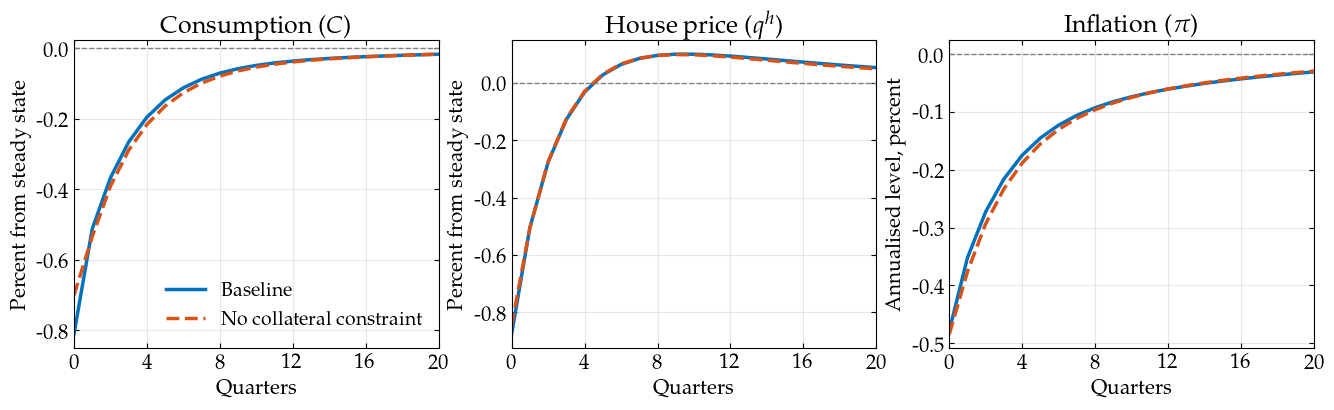

In [520]:
alt_plot = {'C_BHAT': r'Consumption ($C$)', 'qh': r'House price ($q^h$)', 'pi': r'Inflation ($\pi$)'}

fig = plots.linear_irf_nocol(irf_lin['baseline'], irf_lin['no_colcons'], model_lin['baseline'], alt_plot=alt_plot, H = 21)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'linearIRFNoColCons_v2.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

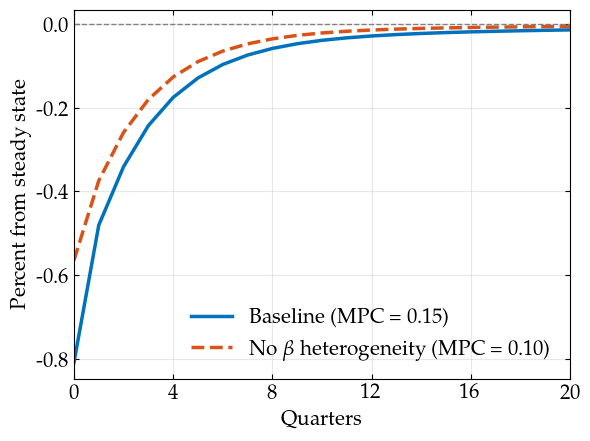

In [ ]:
legend_text = [f"Baseline (MPC = {model_lin['baseline']['MPC']:.2f})", fr"No $\beta$ heterogeneity  (MPC = {model_lin['alt']['MPC']:.2f})"]
fig = plots.generic_twoirfs(irf_lin['baseline'], irf_lin['alt'], model_lin['baseline'], model_lin['alt'], 'C_BHAT', legend_text, H = 21)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'CLowMPCvsHighMPC.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

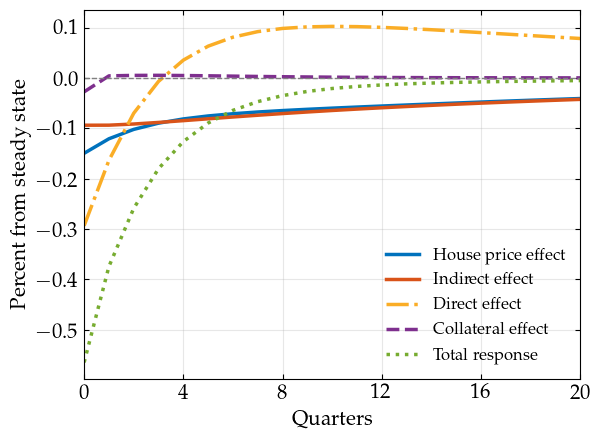

In [70]:
decomp_test = consumption_decomp(CurlyJs['alt'], irf_lin['alt'], hh_name, do_assert = True)
fig = plot_decomp_single(decomp_test, model_lin['alt'], H = 21)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'CDecompLowMpc_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

In [83]:
write_table = True
if write_table:
    plots.cumulative_effects(decomp_test, model_lin['alt'])

\begin{tabular}{lrrrrr}
\hline
 Effect      &     0 &     3 &     7 &    11 &    15 \\
\hline
 Total       & -0.56 & -1.38 & -1.71 & -1.81 & -1.85 \\
 House price & -0.15 & -0.46 & -0.76 & -1    & -1.21 \\
 Collateral  & -0.03 & -0.01 &  0    &  0.01 &  0.01 \\
 Indirect    & -0.09 & -0.37 & -0.69 & -0.95 & -1.17 \\
 Direct      & -0.29 & -0.53 & -0.26 &  0.14 &  0.53 \\
\hline
\end{tabular}
\begin{tabular}{lrrrrr}
\hline
 Effect      &   0 &   3 &   7 &   11 &   15 \\
\hline
 House price &  27 &  34 &  44 &   56 &   66 \\
 Collateral  &   5 &   1 &  -0 &   -0 &   -1 \\
 Indirect    &  17 &  27 &  40 &   53 &   63 \\
 Direct      &  52 &  39 &  15 &   -8 &  -28 \\
\hline
\end{tabular}


### Sensitivities

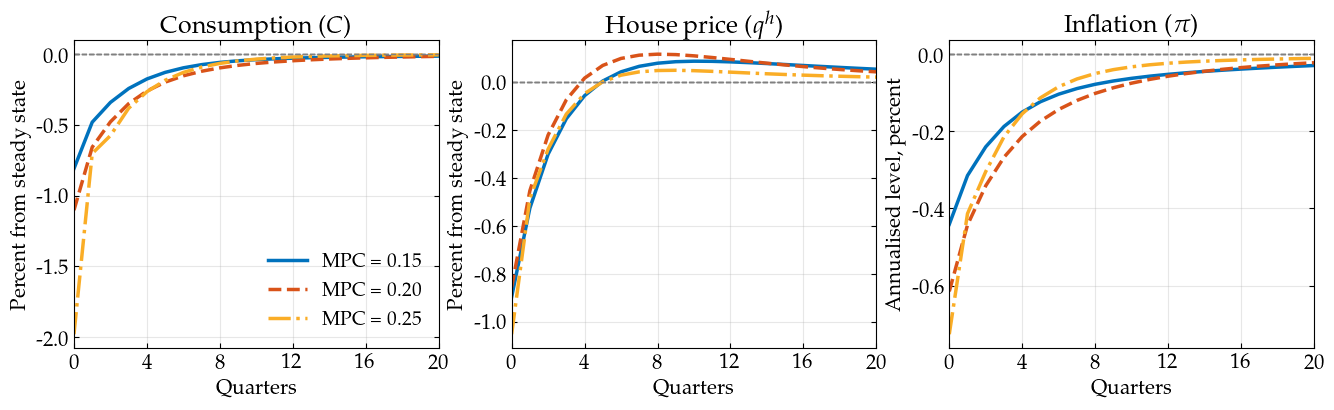

In [114]:
fig = plots.linear_irf_diffmpc(irf_lin, model_lin)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'DifferentMPCsIRFs.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

1. **$\gamma$ sensitivities**

In [ ]:
fig = plots.linear_irf_diffgamma(irf_lin, model_lin, gamma_names, gamma_list,alt_plot = None, H = 21)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'DifferentGamma_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

Plotting the consumption decomposition for different values of $\gamma$

In [ ]:
compare_decomp = False
if compare_decomp:
    for gamma_name in gamma_names:
        fig = plot_decomp_single(c_decomp[gamma_name], model_lin[gamma_name], H = 21)

2. **$\kappa$ sensitivities**

In [ ]:
fig = plots.linear_irf_diffkappa(irf_lin, model_lin['baseline'], kappa_names, kappa_list, alt_plot = None, H = 21)

3. **$\phi$ sensitivities**

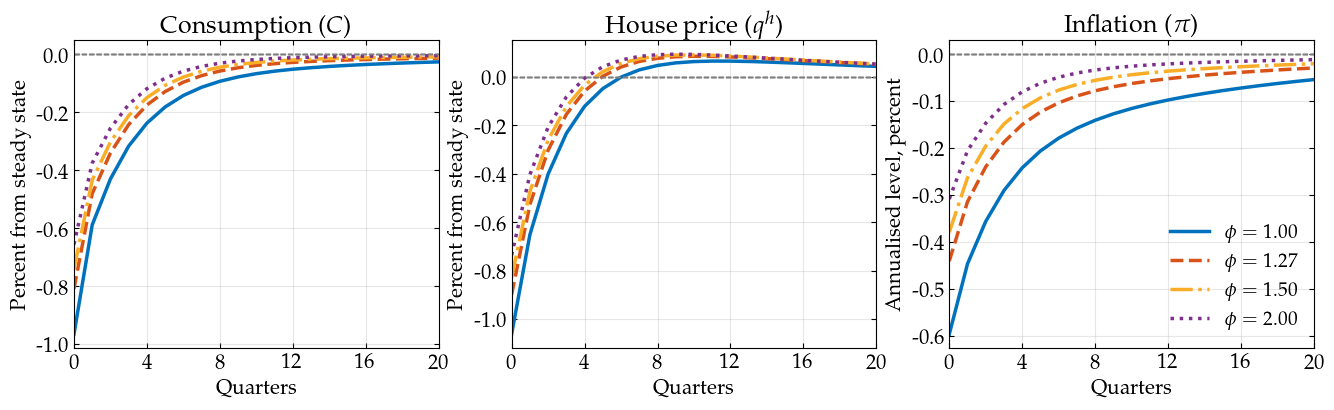

In [ ]:
fig = plots.linear_irf_diffphi(irf_lin, model_lin['baseline'], phi_names, phi_list, alt_plot = None, H = 21)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'DifferentPhi_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Housing wealth state dependence

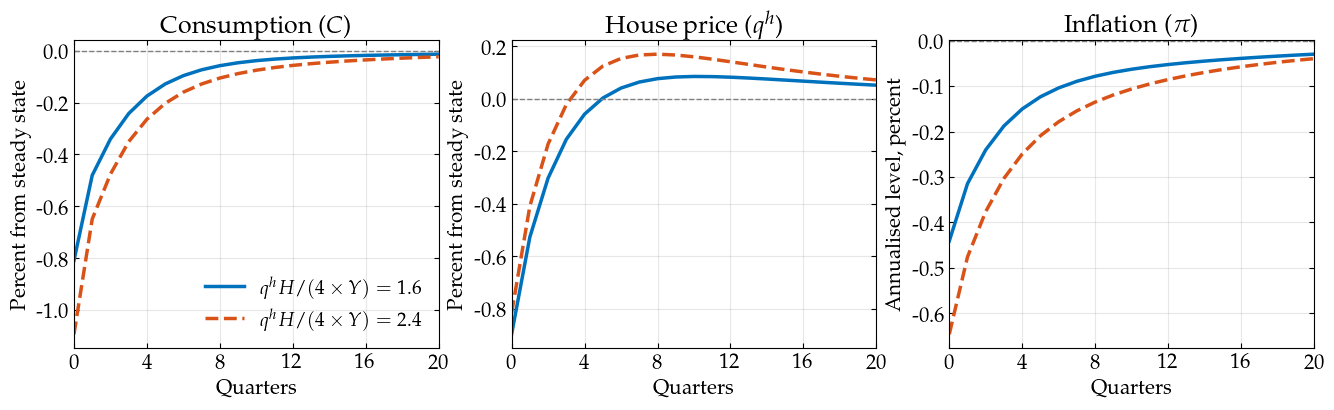

In [83]:
fig = plots.linear_irf_statedependence(irf_lin['baseline'], irf_lin['highwealth'], model_lin['baseline'], model_lin['highwealth'])

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'REStateDependence_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

In [158]:
print(f"Difference between qhH = 1.6 and qhH = 2.4")
print(f"Impact difference (%-points): {100*(irf_lin['baseline']['C_BHAT'][0] - irf_lin['highwealth']['C_BHAT'][0])}")
print(f"Impact difference (%): {100*(irf_lin['baseline']['C_BHAT'][0] - irf_lin['highwealth']['C_BHAT'][0])/irf_lin['baseline']['C_BHAT'][0]}")
print(f"1-year difference (%-points): {100*(np.cumsum(irf_lin['baseline']['C_BHAT'][:4] - irf_lin['highwealth']['C_BHAT'][:4])[3])}")

Difference between qhH = 1.6 and qhH = 2.4
Impact difference (%-points): 0.28315359978266524
Impact difference (%): -35.04820021732693
1-year difference (%-points): 0.6941184800536491


In [143]:
from matplotlib.legend_handler import HandlerTuple
counterfactual_decom_highwealth =  consumption_decomp(CurlyJs['highwealth'], irf_lin['baseline'], hh_name, do_assert=False)

def compare_decomp_counterfactual(c_decomp, model_ss, CurlyJs, irf_lin, counterfactual_decom_highwealth, H = 21):
    fig, ax = plt.subplots()
    colors=['#0072BD', '#D95319', '#FAAD26', '#7E2F8E', '#77AC30', '#4DBEEE','#A2142F', '#000000']

    # counterfactual_decom_highwealth =  consumption_decomp(CurlyJs['highwealth'], irf_lin['baseline'], hh_name, do_assert=False)

    H = 21
    p1 = ax.plot(100*c_decomp['baseline']['housing'][:H]/model_ss['baseline']['C_BHAT'], label='Housing price')
    p2 = ax.plot(100*c_decomp['baseline']['indirect'][:H]/model_ss['baseline']['C_BHAT'], label='Indirect')
    p3 = ax.plot(100*c_decomp['baseline']['direct'][:H]/model_ss['baseline']['C_BHAT'], label='Direct')
    p4 = ax.plot(100*c_decomp['baseline']['collateral'][:H]/model_ss['baseline']['C_BHAT'], label='Collateral')
    # ax.plot(100*c_decomp['baseline']['total'][:H]/model_ss['baseline']['C_BHAT'], label='Total response')

    p9 = ax.plot(100*counterfactual_decom_highwealth['housing'][:H]/model_ss['baseline']['C_BHAT'], color = colors[0], linestyle='dotted')
    p10 = ax.plot(100*counterfactual_decom_highwealth['indirect'][:H]/model_ss['baseline']['C_BHAT'], color = colors[1], linestyle='dotted')
    p11 = ax.plot(100*counterfactual_decom_highwealth['direct'][:H]/model_ss['baseline']['C_BHAT'], color = colors[2], linestyle='dotted')
    p12 = ax.plot(100*counterfactual_decom_highwealth['collateral'][:H]/model_ss['baseline']['C_BHAT'], color = colors[3], linestyle='dotted')
    # ax.plot(100*counterfactual_decom_highwealth['total'][:H]/model_ss['baseline']['C_BHAT'], label='Total response')
    # plt.legend([(p1[0], p9[0]), (p2[0], p10[0]), (p3[0], p11[0]), (p4[0], p12[0])], 
    #         ['Housing price', 'Indirect', 'Direct', 'Collateral'], numpoints=1, 
    #         handler_map={tuple: HandlerTuple(ndivide=None)}, handlelength=5, frameon=False, fontsize = 12)
    ax.set_xlabel('Quarters')
    ax.set_ylabel('Percent from steady state')
    ax.xaxis.set_major_locator(MultipleLocator(4))
    ax.set_xlim(0, H-1)
    ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax.grid(True, alpha = 0.3)
    plt.show()

<class 'types.SimpleNamespace'>


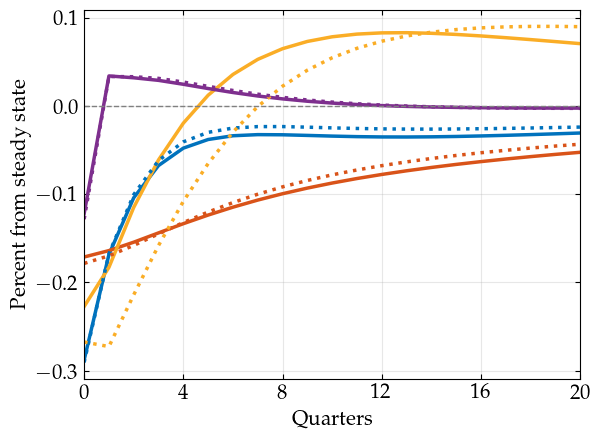

In [147]:
counterfactual_decom_highwealth =  consumption_decomp(CurlyJs['highwealth'], irf_lin['baseline'], hh_name, do_assert=False)
fig = plots.compare_decomp_counterfactual(c_decomp, model_lin, counterfactual_decom_highwealth, H = 21)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'linearIRFDecompDiffWealthCF_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

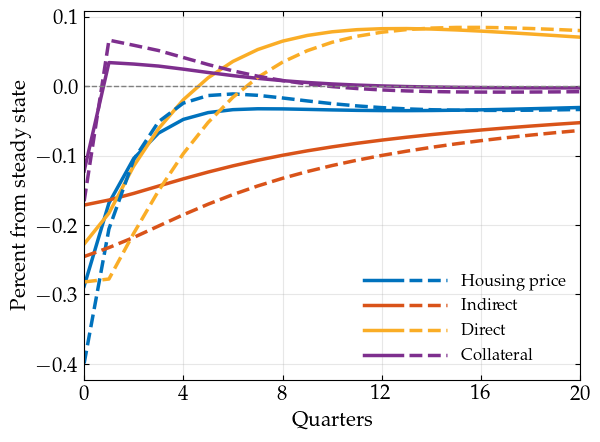

In [ ]:
fig = plots.compare_decomp(c_decomp, model_lin, H = 21)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'linearIRFDecompDiffWealth_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

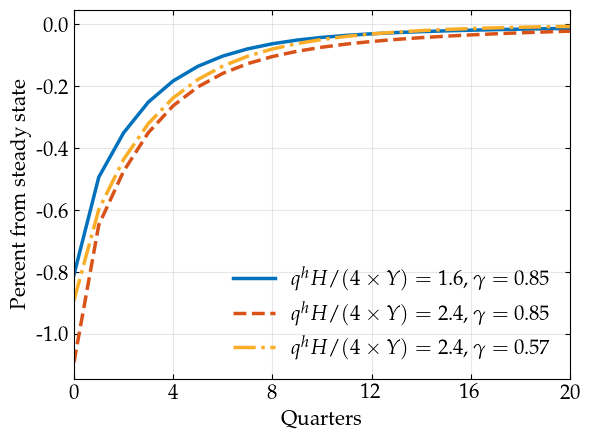

In [399]:
fig = plots.changeLTV_creditcapacity(irf_lin, model_lin, H = 21)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'ChangeLTV_CreditCapacity_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Sticky wages

In [573]:
hh = hh_housing_v3.hh_housecons_sep
hh_name = hh.name

# add hetinputs to the model
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])
hh2 = hh1.add_hetoutputs([utils.compute_mpc])

common_block = [hh2, utils.taylor, utils.real_rate, utils.fiscal, utils.qhouse_lag, utils.gamma_prime]
blocks_sw = [utils.real_wage, utils.mkt_clearing_wage, utils.nkpc_wage, utils.firm_wage]

blocks_sw = common_block + blocks_sw 

unknowns_sw = ['pi', 'N', 'qh']
targets_sw = ['nkpc_res', 'asset_mkt', 'house_mkt']

hank_ss_sw = create_model(blocks_sw, name="Housing HANK SS")
hank_sw = create_model(blocks_sw, name="Sticky Wages HANK")

ss_sw = {}
model_sw = {}
irf_sw = {}
c_decomp_sw = {}
CurlyJs_sw = {}

In [574]:
cali_main_sw = {'gamma': 0.85, 'qh': 1.61*4, 'sigma': 2.0, 'alpha': 0.05, 'bmax': 75, 'rhom': 0.73, 'omega': 0.5, 'q': 0.01,
             'hmax': 8, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0,
             'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'muw': 1.2, 'bmin': 0.0,
             'kappaw': 0.0160685, 'rstar': 1.0/0.99 - 1, 'phi': 1.27, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}

unknowns_ss_sw = {'beta_hi': 0.977, 'varphi': 0.836, 'theta': 0.077, 'dbeta': 0.082}

targets_ss_sw = {'goods_mkt': 0, 'nkpc_res': 0, 'house_mkt': 0, 'MPC': 0.15}

ss_sw['baseline']  = hank_ss_sw.solve_steady_state(cali_main_sw, unknowns_ss_sw, targets_ss_sw, solver="hybr")
model_sw['baseline'] = hank_sw.steady_state(ss_sw['baseline'])

In [579]:
sig_gamma = 0.05
rho_gamma = 0.6
dgamma = sig_gamma * rho_gamma ** np.arange(T)

# model_lin['baseline']['rhom'] = 0
model_sw['baseline']['kappaw'] = 0.1
gamma_shock_neg = hank_sw.solve_impulse_nonlinear(model_sw['baseline'], unknowns_sw, targets_sw, {'gamma': -dgamma},
                                                 internals = {hh_name}, verbose = False, options={'taylor': {'verbose': False}})

In [407]:
irf_lin['baseline_sw'] = hank_sw.solve_impulse_linear(model_sw['baseline'], unknowns_sw, targets_sw, {'epsm': dr})
CurlyJs_sw['baseline'] = {hh_name: hh2.jacobian(model_sw['baseline'], inputs=input_list, outputs=output_list, T=T)}
c_decomp_sw['baseline'] = consumption_decomp_sw(CurlyJs_sw['baseline'], irf_lin['baseline_sw'], hh_name, do_assert = True)
# c_decomp_sw['baseline'] = consumption_decomp(CurlyJs_sw['baseline'], irf_lin['baseline_sw'], hh_name, do_assert = True)

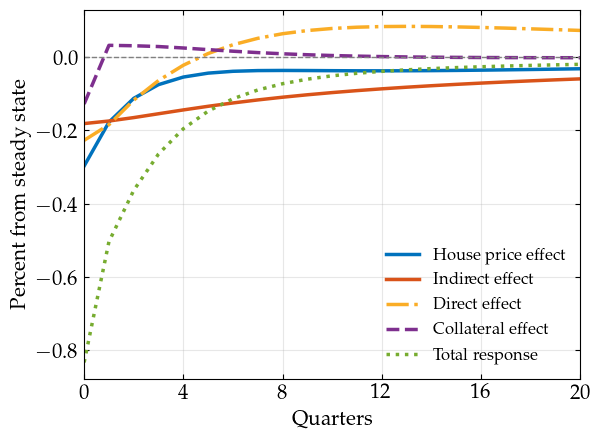

In [408]:
fig = plot_decomp_single(c_decomp_sw['baseline'], model_sw['baseline'], H = 21)

In [ ]:
counterfactual_decom_highwealth =  consumption_decomp(CurlyJs['highwealth'], irf_lin['baseline'], hh_name, do_assert=False)

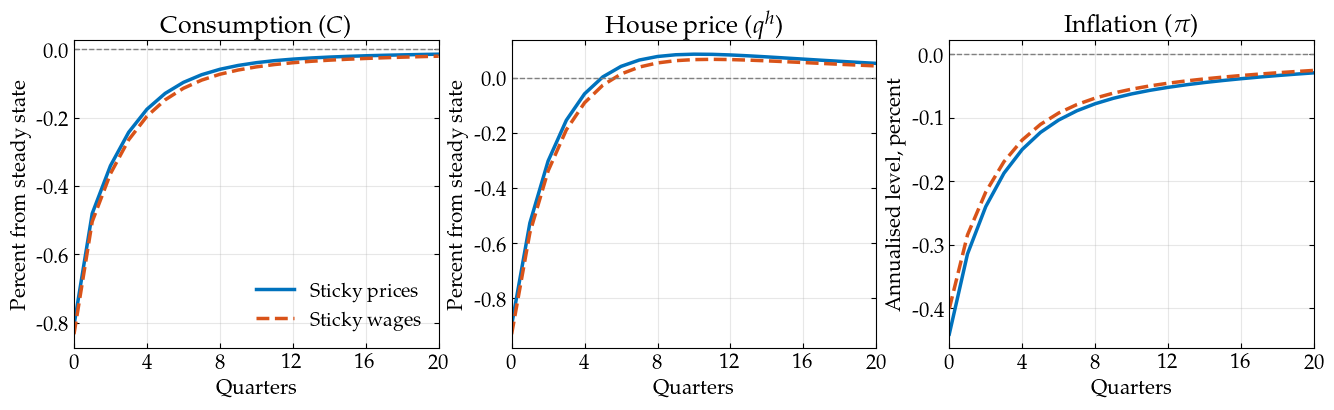

In [ ]:
alt_plot = {'C_BHAT': r'Consumption ($C$)', 'qh': r'House price ($q^h$)', 'pi': r'Inflation ($\pi$)'}
fig = plots.linear_irf_sw(irf_lin['baseline'], irf_lin['baseline_sw'], 
                          model_lin['baseline'], model_sw['baseline'], alt_plot = alt_plot, H = 21)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'StickyWages_v002.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### Non-linear IRFs

I now plot the different effects of positive and negative monetary policy shocks and the different sizes of shocks.

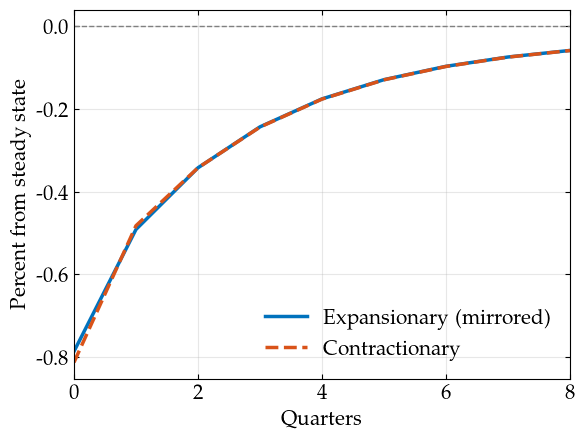

In [366]:
fig = plots.nonlin_consumption(model_lin['baseline'], irf_nonlin, key = 'C_BHAT', H = 9, big_shock = False)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'Nonlin_29bps_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

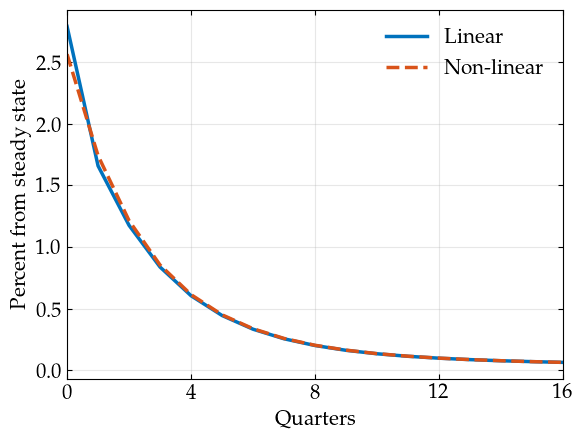

In [199]:
legend_text = ['Linear', 'Non-linear']
fig = plots.generic_twoirfs(irf_lin['neg_100bps'], irf_nonlin['neg_100bps'], model_lin['baseline'],  model_lin['baseline'], 'C_BHAT', legend_text, H = 17)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'NonLinVsLin_100bps.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

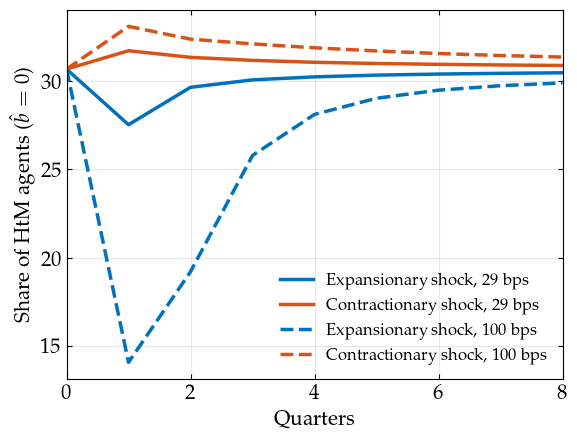

In [ ]:
fig = plots.htm_share(model_lin['baseline'], irf_nonlin, hh_name, T)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'HtMShare_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

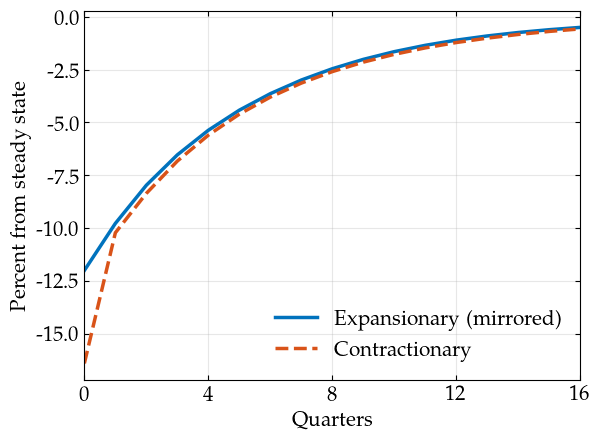

In [ ]:
fig = plots.persistentMPshock(irf_nonlin, model_lin['baseline'])

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'PersistentMPShock_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

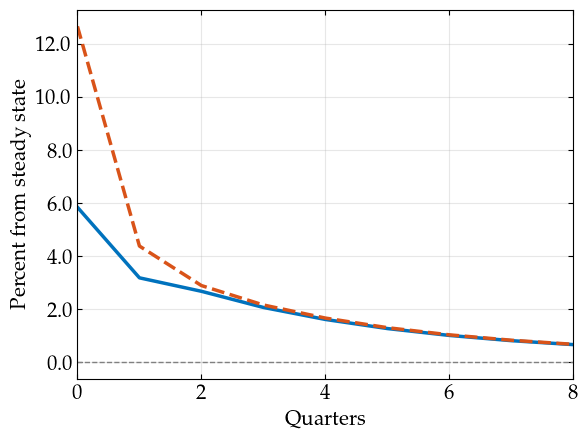

In [ ]:
fig = plots.nonlinear_MPC(model_lin['baseline'], irf_nonlin)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'AverageMPC_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

### LTV shocks

In [ ]:
alt_plot = {'C_BHAT': r'Consumption ($C$)', 'qh': r'House price ($q^h$)', 'r': r'Real rate ($r$)'}
fig = plots.ltvshock(irf_ltv_shock['neg_rho60'], irf_ltv_shock['pos_rho60'], model_lin['ltv_baseline'], model_lin['ltv_baseline'], alt_plot = alt_plot, H = 21)

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"
    fig.savefig(os.path.join(figure_path, 'LTVshock_asymm_rho60_v1.pdf'), dpi=1000, bbox_inches='tight', transparent=True)

KeyError: 'ltv_baseline'

## IRF matching

In [629]:
from scipy.optimize import minimize
from statsmodels.tsa.filters.hp_filter import hpfilter

# Define the path to the Excel file
subfolder = 'Misc'
filename = 'rrshockirfs_v5.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)
H = 16

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='gamma', header = None)

col_name = ['i', 'C_BHAT', 'qh', 'Y', 'pi', 'Investment', 'w', 'Mortgage', 'Rent']
df.columns = col_name

bounds_name = ['lb', 'ub']
col_name_bands = []
for i in bounds_name:
    for j in col_name:
        col_name_bands.append(f'{i}_{j}')
df_bands = pd.read_excel(file_path, sheet_name='gammabands', header = None)
df_bands.columns = col_name_bands

# irf_smooth = pd.DataFrame({'qh': qh_smooth, 'C_BHAT': c_bhat_smooth})

df_se = pd.DataFrame()
for i in range(9):
    df_se[i] = (df_bands.iloc[:,i + 9] - df.iloc[:,i])/0.9945

df_se.columns = col_name
# print(df_se)

vars = ['C_BHAT', 'qh']
empircal_irfs = df[vars][:H]

qh_smooth = hpfilter(empircal_irfs['qh'][:H], lamb=30)[1]
c_bhat_smooth = hpfilter(empircal_irfs['C_BHAT'][:H], lamb=30)[1]
irf_smooth = pd.DataFrame({'qh': qh_smooth, 'C_BHAT': c_bhat_smooth})

df_se = df_se[vars][:H]

df_se = df_se.values.flatten()
W = np.diag(df_se**2)
W_inv = np.linalg.inv(W)

sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

def objective(params):
    # xi, rhom, kappa = params
    xi, rhom = params
    model_lin['baseline']['rhom'] = rhom
    # model['baseline']['kappa'] = kappa

    irfs_match, _ = inattention_irf(xi, model_lin['baseline'], hh2, hank, hh_name, 
                                                    input_list, output_list, unknowns, targets, dr)

    vars = ['C_BHAT', 'qh']
    J_mat = np.zeros((H, len(vars)))

    for idx, key in enumerate(vars):
        J_mat[:,idx] = 100*(irfs_match[key][:H]/model_lin['baseline'][key] - irf_smooth[key][:H])
    J = np.ravel(J_mat)

    return J.T @ W_inv @ J 

# Set the bounds for each variable
# bounds = [(0, 1), (0, 1), (0, 0.3)]  # Example bounds for xi and rhom
bounds = [(0, 1), (0, 1)]  # Example bounds for xi and rhom

# Initial guess for the variables
initial_guess = [0.95, 0.73] 

result = minimize(objective, initial_guess, bounds=bounds)
print("xi =", result.x[0])
print("rhom =", result.x[1])

xi = 0.9932144551280739
rhom = 0.3476517287239891


In [651]:
xi = result.x[0] # 0.9932144551280739
rhom = #result.x[1] # 0.3476517287239891
dr_match = np.zeros(T)
dr_match[0] = 0.01
model_lin['baseline']['rhom'] = rhom
irfs_match, _ = inattention_irf(xi, model_lin['baseline'], hh2, hank, hh_name, 
                                                    input_list, output_list, unknowns, targets, dr_match)

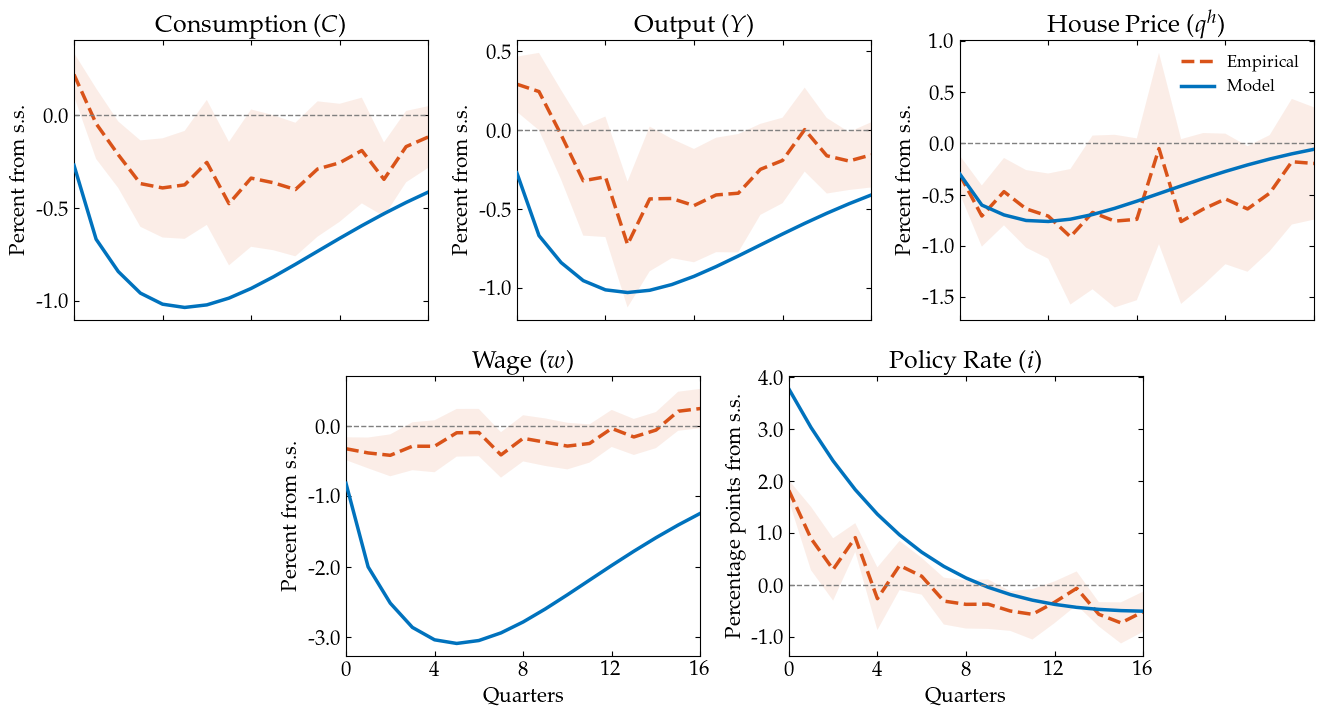

In [652]:
plots.compare_with_empirical(irfs_match, model_lin['baseline'], H = 17)

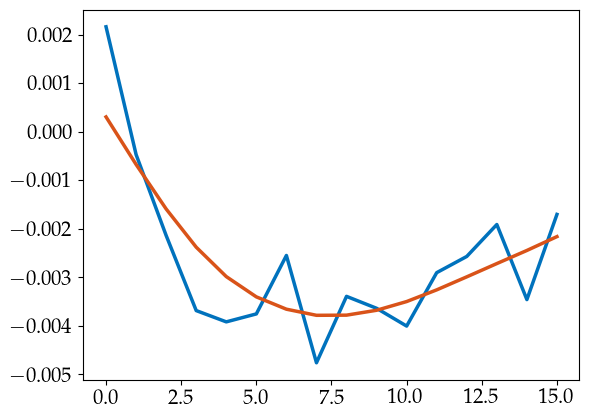

In [627]:
plt.plot(empircal_irfs['C_BHAT'][:H])
plt.plot(c_bhat_smooth)

# Misc.

In [ ]:
plt.plot(model_lin['baseline'].internals[hh_name]['h_bhat_grid'], model_lin['baseline'].internals[hh_name]['chi'][0,1,:])
print(np.min(model_lin['baseline'].internals[hh_name]['chi'][0,40,:]))

def get_PsiHousing_and_deriv(hp, h, alpha, qh):
    """Adjustment cost Psi(hp, h) for housing"""

    # h = h + 1e-8  # avoid division by zero

    Psi = alpha / 2 * ((hp - h)/h)**2*(h*qh)
    Psi1 = (alpha*qh) * (hp - h)/h
    # Psi2 = alpha / 2 * (-2*(hp - h)/h**2 + (hp - h)**2/h**2)
    Psi2 = (alpha*qh) / (2*h**2) * (-2*(hp - h)*hp - (hp - h)**2)

    return Psi, Psi1, Psi2

hp = model_lin['baseline'].internals[hh_name]['h_bhat_grid']
h = hp[0]
alpha = model_lin['baseline']['alpha']
qh = model_lin['baseline']['qh']

Psi, Psi1, Psi2 = get_PsiHousing_and_deriv(hp, h, alpha, qh)

plt.plot(hp, Psi)
plt.plot(hp, Psi1)
# plt.plot(hp, Psi2)